# Forecasting Market Volatility

## <font color='#114B5F'><p><b>Table of Contents</b></p></font>
<ol><li><a href='#Notes-anchor'>Overview</a></li>
    <li><a href='#data-anchor'>Importing Data, Functions and Packages</a></li>
    <li><a href='#data2-anchor'>Exploring the Data</a></li>
        <ol style="list-style-type: lower-roman;"><li><a href='#nan-anchor'>Addressing NaNs</a></li>
        </ol>
    <li><a href='#measure-anchor'>How Measure Success</a>
    <li><a href='#models-anchor'>Modeling</a>
        <ol style="list-style-type: lower-roman;"><li><a href='#garch-anchor'>ARCH/GARCH</a></li>
            <li><a href='#vecm-anchor'>VECM</a></li>
            <li><a href='#ar-anchor'>AR</a></li>
            <li><a href='#arma-anchor'>ARMA</a></li>
        </ol>
    </li>
    <li><a href='#new_strategy-anchor'>Revised Strategy</a>
    <li><a href='#conclusion-anchor'>Conclusion</a>
</ol>

## <font color='#114B5F'><p style="text-align: center;"><a id='Notes-anchor'></a>Overview</p></font>

### Data notes:

1. The data runs from March 2005 through end November 2016. It is daily. 

2. The SPY is the S&P index and you have seen this one before. 

3. The "RealVol" is realized volatility for the past 30 days i.e., the standard deviation of the returns on the S&P index in annualized form. See Dan's notebook on volatility. 

4. The VIX is the CBOE volatility index. The current VIX index value quotes the expected annualized change in the S&P 500 index over the following 30 days, as computed from options-based theory and current options-market data. https://en.wikipedia.org/wiki/VIX

5. The VIXCM30 stands for the VIX 30 day volatility future, i.e., a measure of the VIX forward 30 days, i.e., from 30-60 days. Likewise the VIXCM60 is the 60-day forward future, i.e., a measure of the volatility between 60-90 days out in time. The five futures contracts constitute the "futures curve".

### Project goals:

1. Imagine you are a trader and are interested in building a model for accurately forecasting the five futures prices, i.e., the five points in the volatility curve (VIXCM30, VIXCM60, VIXCM90, VIXCM120, VIXCM150). You can use all the data in the data frame above to come up with a forecasting model. 

2. Devise a metric for this exercise. How would you convince someone with a good metric that the performance of your forecasting is highly accurate. There is no specific known metric, so feel free to look at existing research on volatility forecasting. 

3. You may want to develop rolling forecasts, i.e., choose a reasonable look back period to fit the model and the a reasonable forward forecast. For example, you may want to use a 180-day look back to fit the model and then forecast the next weeks futures prices. (That is just an example, find your best approach.)

## <font color='#114B5F'><p style="text-align: center;"><a id='data-anchor'></a>Importing Data, Functions and Packages</p></font>

### First we will import the data and define functions which will be used throughout the notebook:

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from johansen_test import coint_johansen
from scipy import stats
%matplotlib inline
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # Time Series Analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import copy
import seaborn as sns
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15,8
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import scipy
from scipy import *
import math
from scipy import interpolate
import arch
from arch import arch_model

In [2]:
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [3]:
from statsmodels.tsa.stattools import adfuller

def run_ad_fuller(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print('\nWe fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary')
    else:
        print('\nWe reject the Null Hypothesis (H0) -- the time series is stationary')

In [4]:
from statsmodels.tsa.arima_model import ARMA
from prettytable import PrettyTable as pt
import time

# evaluate an ARMA model
def evaluate_arma_model(X, p, q, metric='BIC'):
    assert metric in ('AIC','BIC','HQIC','MSE')
    try:
        model = ARMA(X, order=(p,q))
        r = model.fit(trend='nc', method='css-mle')
        if metric == 'BIC':    value = r.bic
        elif metric == 'AIC':  value = r.aic
        elif metric == 'HQIC': value = r.hqic
        elif metric == 'MSE':  value = np.mean(r.sigma2) ** .5
        return value
    except:
        return None

In [5]:
def run_grid_over_arma(X, p_lags, q_lags, metric='BIC'):
    header = ['p\q'] + list(map(lambda q: 'q (%d)' % q, q_lags))
    start_time = time.time()
    table = pt(header)
    bad = []
    result = {}
    for p in p_lags:
        row = ['p(%d)' % p]
        for q in q_lags:
            #print(p,q)
            value = evaluate_arma_model(X, p, q, metric=metric)
            if value is None:
                bad += [(p,q)]
                row += ['n/a']
            else:
                row += ['%8.2F' % value]
                result[(p,q)] = value
                
        table.add_row(row)
        print(row)
    print(table)
    end_time = time.time()
    print('bad values: %s' % str(bad))
    print('time required', end_time - start_time)
    return result

In [6]:
from sklearn.metrics import mean_squared_error

def measure_error(actual, pred, label=None, show=True):
    sq_error = mean_squared_error(actual,pred)
    rmse = np.mean(sq_error)**.5
    avg = np.mean(actual)
    errors = {'RMSE': rmse, 'RMSE_pcent': rmse / avg, 'label':label}
    if show:
        for (k,v) in errors.items():
            print('%s = %s' % (k,v))
    return errors

In [7]:
def ts_plot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    run_ad_fuller(y)
    return 

In [8]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, pred, show=True):
    y_true = []
    y_pred = []

    last = actual[0]
    for (a,p) in list(zip(actual, pred))[1:]:
        y_true += [-1 + int(a - last > 0) * 2]
        y_pred += [-1 + int(p - last > 0) * 2]
        last = a
    labels = ['tn', 'fp', 'fn', 'tp']
    cm = confusion_matrix(y_true, y_pred)
    
    print('Confusion Matrix\nRaw')
    print(cm)
    print('Normalized')
    cm_norm = cm / np.sum(cm)
    
    if show:
        print(cm_norm)
        plt.figure()
        plt.imshow(cm,  cmap=plt.cm.Blues)
        plt.colorbar()
        #tick_marks = np.arange(2)
        plt.xticks([-0.5,0.5], ['negative','positive'])
        plt.yticks([-0.5,0.5], ['negative','positive'])
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Manual AR(p) Model Predicted vs. Actual')
    return {'cm': cm, 'cm_norm': cm_norm}

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def run_ljung_box(X,lags=40):
    (_,p_values) = acorr_ljungbox(X, lags=lags, boxpierce=False)
    print('Ljung-Box Test')
    for n,p_value in enumerate(p_values):
        if p_value < .05:
            print('lag: %3d | p_value: %.4f | still has information' % (n+1, p_value))

#### Importing the data

In [56]:
df_data=pd.read_csv('vix_data.csv')
df_data.head()

Date        SPY   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
0  3/23/2005  92.578594  9.120305  14.06  14.506154  15.065909  15.454545   
1  3/24/2005  92.689358  6.457921  13.42  14.225263  14.894773  15.242500   
2  3/28/2005  92.823878  5.578653  13.75  14.398649  14.993636  15.320909   
3  3/29/2005  92.206709  9.290422  14.49  14.931667  15.219773  15.458409   
4  3/30/2005  93.512316  7.313855  13.64  14.428571  15.091364  15.398182   

    VIXCM120   VIXCM150  
0  15.739375  15.955000  
1  15.524375  15.768125  
2  15.586250  15.820625  
3  15.667813  15.864688  
4  15.600312  15.764375

## <font color='#114B5F'><p style="text-align: center;"><a id='data2-anchor'></a>Exploring the Data</p></font>

### Before we jump in we will make sure we understand the data available:

- **Volatility**: The standard deviation of log returns where $ R = log(P_t / P_{t-1}) $
- **Realized Volatility**: The volatility observer for an instrument over a recent window of N periods
    - Note annualized daily volatility would be: $$ \sigma_{annual} =  \sqrt{ 252 } * \sigma_{daily}$$
- **Futures**: $F_0 = P_0$ + "cost of carry"
- **VIX**: One of the most broadly used measure of volatility in the market
    - The VIX calculation weighs the implied volatility of front month options (next monthly expiration to expire) and second month options (second month of monthly options to expire) option implied volatilities. 
    - The weights amount to a 30 day horizon of expiration.
- **VIX Futures**: They represent forward expectations for volatility as well as the demand for insurance against tail events in the market
     - **In Contango**: The VIX futures curve is upward sloping –> the spot VIX price is lower than the front month futures, which in turn are lower than the second month futures and so on.
     - **In Backwardation**: The VIX futures curve is downward sloping– the spot VIX price is higher than the front month futures, which in turn are higher than the second month futures and so on.
     - Note most of the time, VIX Futures are in Contango
- **Why are VIX Futures typically in Contango?**: 
    - https://www.macroption.com/vix-futures-curve/
        - Contango can be interpreted in the way that the market expects the VIX index to increase from its current level going forward
        - Due to the skewed and mean reverting nature of the VIX and volatility in general (long time at low levels, with occasional big but mostly short-lived spikes) VIX Futures are typically in contango. 
        - VIX futures contango is typically sharpest when the spot VIX Index is very low.
        - Backwardation typically occurs when the spot VIX index spikes and the market expects volatility to decrease again in the future.
    - (http://www.bsam.com/volatility-futures-and-sp500-performance/)
        - The Black-Scholes model assumes that stock returns are distributed as a gaussian or normal distribution while actual market returns exhibit fat tails
        - Out of the money strike prices on both call and put options show higher implied volatility which reflects these fat tails
        - The actual frequency occurrence and magnitude of market crashes is larger than what a normal distribution would predict, which is now factored into option prices on the S&P500
        -  The VIX futures theoretically provide a good asymmetric hedge against market risk since downside is limited and upside is substantial. This means that investors are likely willing to pay a premium to buy volatility futures to have some insurance against market drawdowns. That is why the volatility futures markets are typically in contango- reflecting this cost of insurance.

Below we can see how the VIX is mean reverting and skewed right (positively):

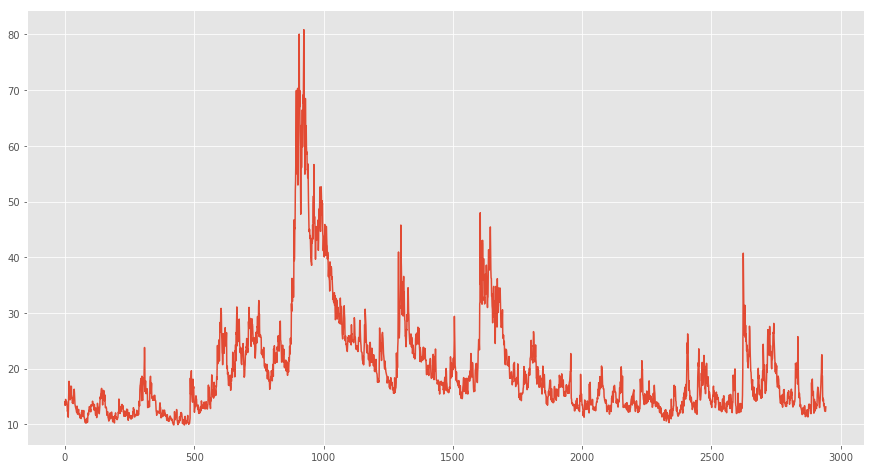

In [11]:
plt.rcParams['figure.figsize'] = 15,8
df_data.VIX.plot()

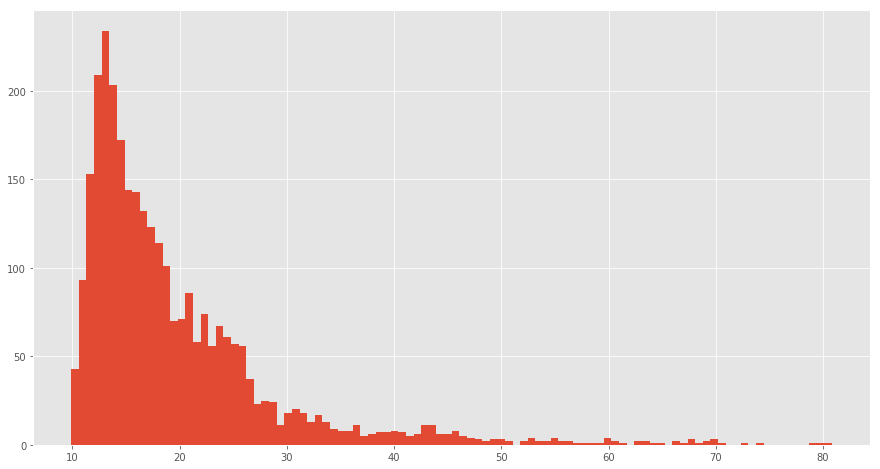

In [12]:
df_data.VIX.hist(bins=100)

### Now we will explore the data:

First let's summarize the data:

In [13]:
len(df_data)

2943

In [14]:
df_data.describe()

SPY      RealVol          VIX      VIXCM30      VIXCM60  \
count  2943.000000  2943.000000  2943.000000  2943.000000  2943.000000   
mean    132.905896    11.228967    19.586290    20.737151    21.419516   
std      41.630454     8.782778     9.433398     7.751411     6.942745   
min      58.030194     1.725931     9.890000    11.763684    12.900000   
25%     102.141627     6.420053    13.455000    15.270175    16.291053   
50%     118.316563     8.551970    16.670000    18.522917    19.500000   
75%     170.156606    12.769802    22.535000    24.030250    24.680550   
max     221.520000   110.821685    80.860000    62.706364    54.465500   

           VIXCM90     VIXCM120    VIXCM150  
count  2943.000000  2915.000000  509.000000  
mean     21.851063    22.277360   17.815324  
std       6.461391     6.149277    4.051598  
min      13.569474    14.047656   14.298125  
25%      16.963577    17.662237   15.432500  
50%      20.193421    20.660526   16.255079  
75%      25.076158    25.684722   18.905000  
max      48.518947    45.061053   37.655000

We can make a few observations from the summary statistics above:
- VIXCM150 has many missing values, as there are only 509 out of 2943 rows filled
- VIXCM120 also has some (but less) values missing
- Looking at the mean values of VIX, VIXCM30, VIXCM60, VIXCM90, and VIXCM120 we can see that the VIX Futures seem to be in Contango.  However, the VIXCM150 mean does not fall in line with this belief.  This is possibly due to all of the missing values though.


Now we will also make some plots to visualize the data:

In [524]:
df_data.set_index('Date', inplace=True)
df_data.head()

SPY   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                     
3/23/2005  92.578594  9.120305  14.06  14.506154  15.065909  15.454545   
3/24/2005  92.689358  6.457921  13.42  14.225263  14.894773  15.242500   
3/28/2005  92.823878  5.578653  13.75  14.398649  14.993636  15.320909   
3/29/2005  92.206709  9.290422  14.49  14.931667  15.219773  15.458409   
3/30/2005  93.512316  7.313855  13.64  14.428571  15.091364  15.398182   

            VIXCM120   VIXCM150  
Date                             
3/23/2005  15.739375  15.955000  
3/24/2005  15.524375  15.768125  
3/28/2005  15.586250  15.820625  
3/29/2005  15.667813  15.864688  
3/30/2005  15.600312  15.764375

Plotting all variables together:

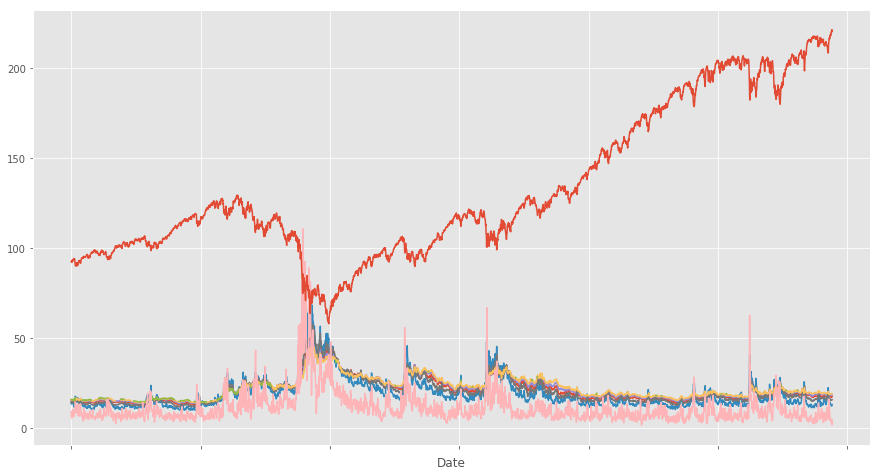

In [16]:
df_data.VIXCM60.plot(label='VIXCM60')
df_data.VIX.plot(label='VIX')
df_data.VIXCM90.plot(label='VIXCM90')
df_data.VIXCM30.plot(label='VIXCM30')
df_data.VIXCM120.plot(label='VIXCM120')
df_data.VIXCM150.plot(label='VIXCM150')
df_data.RealVol.plot(label='RealVol')
df_data.SPY.plot(label='SPY')

Above we can see that SPY is upward trending and all of the VIX variables as well as the realized volatility may be cointegrated.  We can take closer looks below:

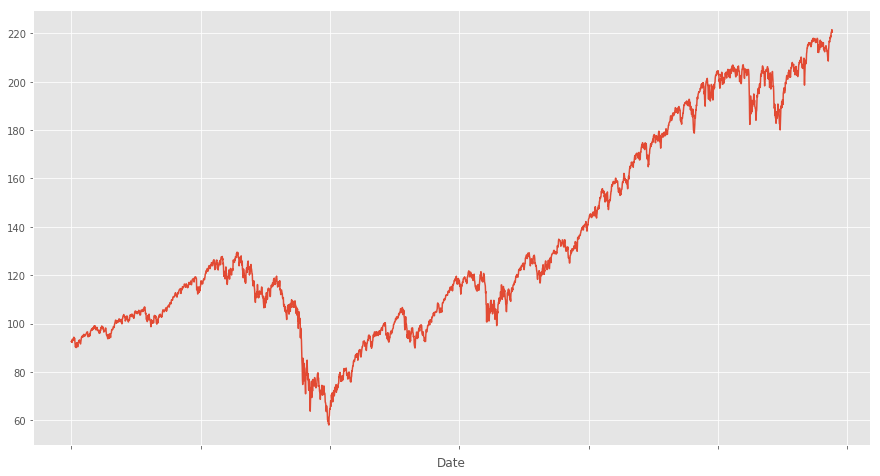

In [17]:
df_data.SPY.plot(label='SPY')

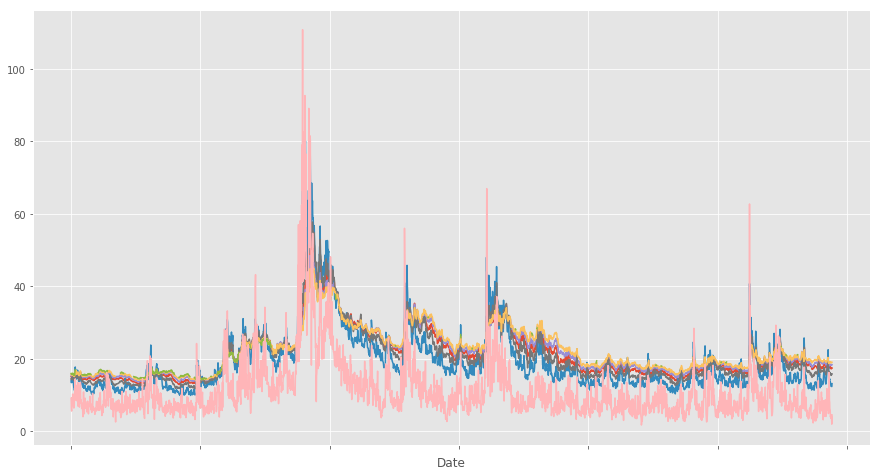

In [18]:
df_data.VIXCM60.plot(label='VIXCM60')
df_data.VIX.plot(label='VIX')
df_data.VIXCM90.plot(label='VIXCM90')
df_data.VIXCM30.plot(label='VIXCM30')
df_data.VIXCM120.plot(label='VIXCM120')
df_data.VIXCM150.plot(label='VIXCM150')
df_data.RealVol.plot(label='RealVol')

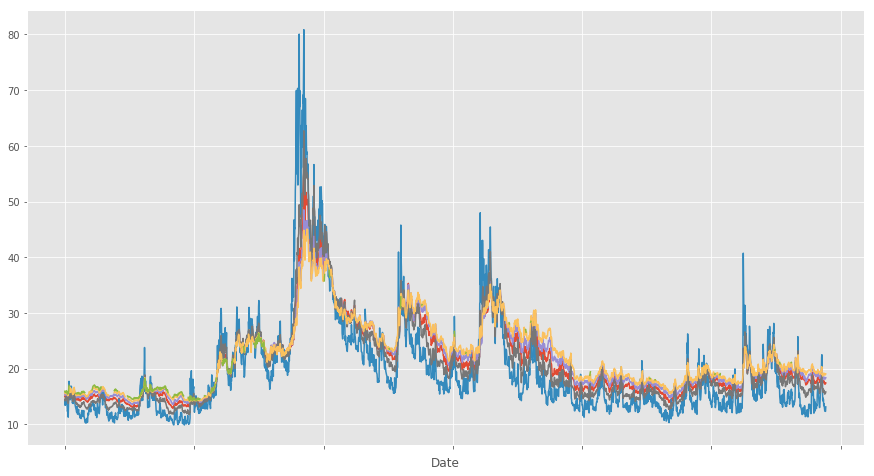

In [19]:
df_data.VIXCM60.plot(label='VIXCM60')
df_data.VIX.plot(label='VIX')
df_data.VIXCM90.plot(label='VIXCM90')
df_data.VIXCM30.plot(label='VIXCM30')
df_data.VIXCM120.plot(label='VIXCM120')
df_data.VIXCM150.plot(label='VIXCM150')

We can see these value seem to be moving together and are likely cointegrated.

## <font color='#114B5F'><p style="text-align: center;"><a id='nan-anchor'></a>Addressing NaNs</p></font>

### Addressing NAs

As we saw in our data exploration, both VIXCM120 and VIXCM150 have missing values.

VIXCM120, has only a handful of missing values, so we can look at where these values appear in the data:

In [525]:
df_data.isna().sum()

SPY            0
RealVol        0
VIX            0
VIXCM30        0
VIXCM60        0
VIXCM90        0
VIXCM120      28
VIXCM150    2434
dtype: int64

Since this variable is only missing data from before 3/8/2006, we could only use data after this date to avoid any issues the missing values could cause. But let's look at where the missing values in VIXCM150 are:

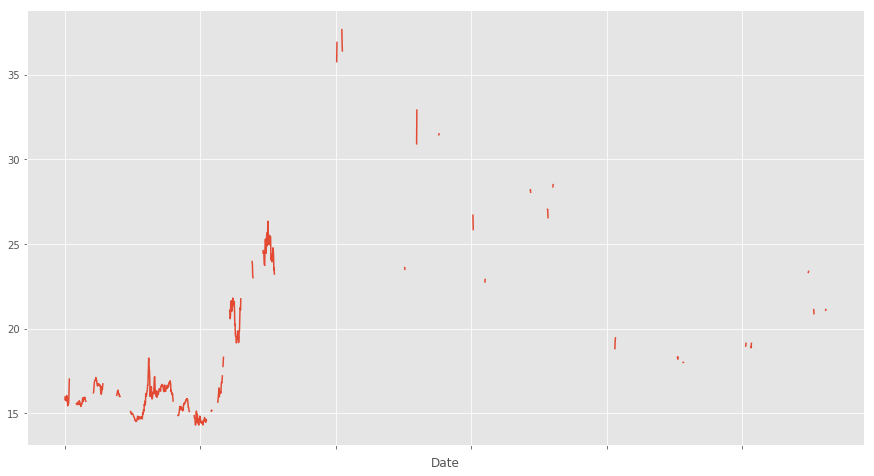

In [21]:
df_data['VIXCM150'].plot()

We can see these missing values are spread all over the data so we can't simply use a portion of the original dataset to avoid this issue- instead we will need to find another way to address the missing values for this variable.  We were able to find a way to extrapolate points on a curve which we can use to fill in missing VIXCM120 and VIXCM150 values.

First we will use all of the VIX, VIXCM30, VIXCM60, and VIXCM90 values on a given day to extrapolate the VIXCM120 values on the missing days.  Then we will use all of the VIX, VIXCM30, VIXCM60, VIXCM90 and VIXCM120 values on a given day to extrapolate the VIXCM150 values on the missing days.

We ran many tests to see how this extrapolation was performing compared to real VIXCM120 and VIXCM150 scores and we very happy this how accurate they were, so we believe this is a secure way to 

In [57]:
for date,row in df_data.iterrows():
    if math.isnan(row['VIXCM120']):
        x=[0,30,60,90]
        y=[row['VIX'],row['VIXCM30'],row['VIXCM60'],row['VIXCM90']]
        f = interpolate.interp1d(x, y, fill_value = "extrapolate")
        new_y=float(f(120))
        df_data.set_value(date, 'VIXCM120', new_y)
        

In [58]:
for date,row in df_data.iterrows():
    if math.isnan(row['VIXCM150']):
        x=[0,30,60,90,120]
        y=[row['VIX'],row['VIXCM30'],row['VIXCM60'],row['VIXCM90'],row['VIXCM120']]
        f = interpolate.interp1d(x, y, fill_value = "extrapolate")
        new_y=float(f(150))
        df_data.set_value(date, 'VIXCM150', new_y)

In [49]:
df_data.isna().sum()

Date        0
SPY         0
RealVol     0
VIX         0
VIXCM30     0
VIXCM60     0
VIXCM90     0
VIXCM120    0
VIXCM150    0
dtype: int64

## <font color='#114B5F'><p style="text-align: center;"><a id='measure-anchor'></a>How Measure Success</p></font>

### Before We Build Models We Will Establish How We Will Measure Their Success:

We will measure the success of a model with by observing the daily PnLs. For any given day, we will advise a direction, to buy (+1) or to sell (-1) a given future.  Then we will multiply the direction by $Future Price_{t}$ - $Future Price_{t-1}$.

For example, if the VIXCM30 was 20 yesterday and the VIXCM30 is 24 today, and our model predicted the VIXCM30 would increase, then the PnL we'd output would be $(24-20)*(+1) = 4$ but if our model predicted the VIXCM30 would have decreased, our PnL output would have been $(24-20)*(-1) = -4$.

In [32]:
def make_money(actual,predicted):
    d = {'Predicted': predicted,
     'Actual': actual}
    PnL_df = pd.DataFrame(d)
    
    Total_PnL =0
    direction=0
    correct=0
    incorrect=0
    
    for i in range(0, (len(PnL_df)-1)):
        if PnL_df['Predicted'][i+1]>PnL_df['Actual'][i]:
            direction=1
        else:
            direction=-1
        daily_PnL= direction*(PnL_df.Actual[i+1]-PnL_df.Actual[i])
        Total_PnL+=daily_PnL
        if daily_PnL>=0:
            correct+=1
        else:
            incorrect+=1
            
    print('Total profit or loss: %.4f' % (Total_PnL))
    print('Number of correct days: %d' % (correct))
    print('total incorrect days: %d' % (incorrect))

## <font color='#114B5F'><p style="text-align: center;"><a id='models-anchor'></a>Modeling</p></font>

### Models To Be Tested:

1) ARCH/GARCH model

2) VECM Model

3) AR Models 

4) ARMA Models 

## <font color='#114B5F'><p style="text-align: center;"><a id='garch-anchor'></a>ARCH/GARCH</p></font>

### ARCH and GARCH Models

With our ARCH and GARCH models we will try to predict the volatility of the SPY daily returns.  Based on these predictions (volatility will increase or decrease), we can make a recommendation about whether to buy or sell each future.

First we will create a new variable for the SPY returns:

ADF Statistic: -12.501615
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


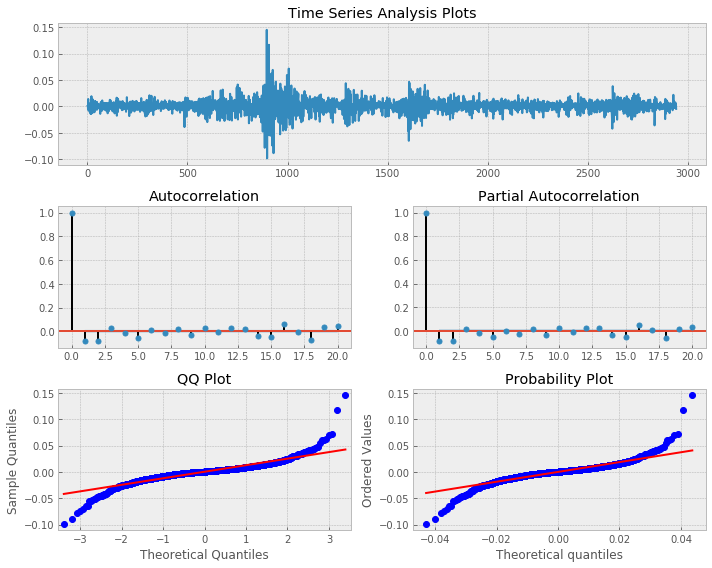

In [468]:
df_data['spy_ret'] = df_data['SPY'].pct_change() 
ts_plot(df_data['spy_ret'].dropna(), lags = 20)

Next we can compute the variance of the returns.  This variable will be used to see how accurate our model is:

ADF Statistic: -4.766926
p-value: 0.000063
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


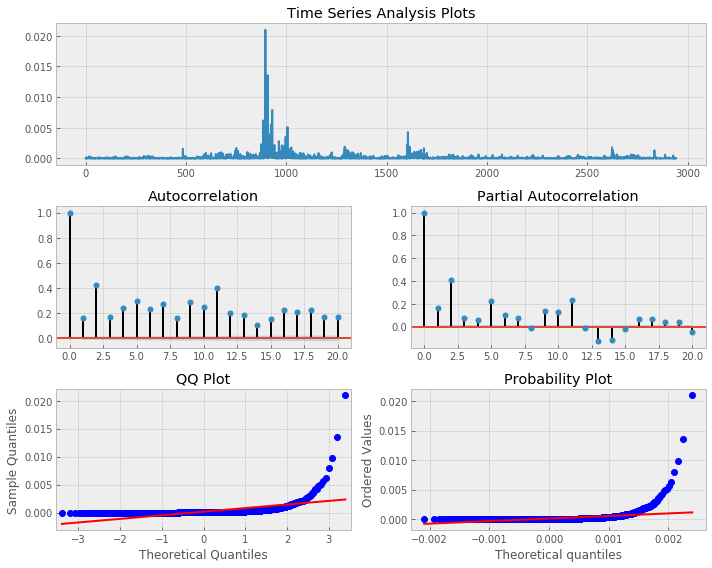

In [469]:
# compute variance
spy_daily_avg = df_data['spy_ret'].mean()
df_data['variance'] = (df_data['spy_ret'] - spy_daily_avg) ** 2
ts_plot(df_data['variance'].dropna(), lags=20)

Now we can run our model.  Please note that we have run a number of ARCH and GARCH models (with varying orders) using the following code.  We have summarized the results in a table after the code, which will just be run for one of the models.

In [470]:
df_data.reset_index(inplace=True)

In [471]:
train,test = train_test_split(df_data, test_size=0.2, shuffle=False)

In [472]:
df_data['Date'] = pd.to_datetime(df_data['Date'])
lst = [0,29,59,89,119,149] # VIXCM nth values

In [512]:
H = train['spy_ret'].dropna()[-180:].tolist()
#H = train['spy_logret'].dropna()[-180:].tolist()
ACTUAL = []
PRED = []
for date,row in test.iterrows():
    am = arch_model(H, vol='Arch', p=1, mean='Constant')
    #am = arch_model(H, vol='Garch', p=3,q=2, dist='Normal',mean='Constant')
    f = am.fit()
    fc = f.forecast(horizon=150)
    ACTUAL += [row['variance']]
    PRED += [fc.variance.values[-1][lst]]
    #print(date,ACTUAL[-1],PRED[-1])
    H += [row['spy_ret']]
    H = H[1:]

Iteration:      1,   Func. Count:      5,   Neg. LLF: -659.9420976322722
Iteration:      2,   Func. Count:     17,   Neg. LLF: -660.0753368434889
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -660.0753377375784
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -662.3038993947875
Iteration:      2,   Func. Count:     17,   Neg. LLF: -662.4368207461009
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -662.4368214190276
            Iterations: 3
            Function evaluations: 25
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -655.646871393028
Iteration:      2,   Func. Count:     17,   Neg. LLF: -655.7033109942909
Iteration:      3,   Func. Count:     24,   Neg. LLF: -655.7286575610116
Iteration:      4,   Func. Count:     33,   Neg. LLF: -655.7383757791745

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.8470560679114
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.9047980862209
Iteration:      3,   Func. Count:     25,   Neg. LLF: -652.9132030394405
Iteration:      4,   Func. Count:     34,   Neg. LLF: -652.9147329200343
Iteration:      5,   Func. Count:     41,   Neg. LLF: -652.915463318544
Iteration:      6,   Func. Count:     49,   Neg. LLF: -652.9155194860964
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -652.9155194860865
            Iterations: 6
            Function evaluations: 49
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.0762467825074
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.1071195416826
Iteration:      3,   Func. Count:     26,   Neg. LLF: -652.1076621772175
Iteration:      4,   Func. Count:     33,   Neg. LLF: -652.1526014125025
Iteration:      5,   Func. Count:     41,   Neg. LLF: -652.152

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.7659050297555
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.8339200601217
Iteration:      3,   Func. Count:     25,   Neg. LLF: -653.8340661641085
Iteration:      4,   Func. Count:     33,   Neg. LLF: -653.8368287400006
Iteration:      5,   Func. Count:     41,   Neg. LLF: -653.8417374193965
Iteration:      6,   Func. Count:     48,   Neg. LLF: -653.8423238619855
Iteration:      7,   Func. Count:     56,   Neg. LLF: -653.8430647547218
Iteration:      8,   Func. Count:     61,   Neg. LLF: -653.8434126869214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -653.8434126868774
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.8218614908806
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.893208460891
Iteration:      3,   Func. Count:     26,   Neg. LLF: -653.893

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -657.5005382225817
Iteration:      2,   Func. Count:     17,   Neg. LLF: -657.5631829228405
Iteration:      3,   Func. Count:     25,   Neg. LLF: -657.6160720755558
Iteration:      4,   Func. Count:     33,   Neg. LLF: -657.6194177486296
Iteration:      5,   Func. Count:     40,   Neg. LLF: -657.6202661269544
Iteration:      6,   Func. Count:     48,   Neg. LLF: -657.6212855551237
Iteration:      7,   Func. Count:     53,   Neg. LLF: -657.6213314992976
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -657.6213320053339
            Iterations: 7
            Function evaluations: 55
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -660.8030295819241
Iteration:      2,   Func. Count:     17,   Neg. LLF: -660.8612062282516
Iteration:      3,   Func. Count:     25,   Neg. LLF: -660.861611824671
Iteration:      4,   Func. Count:     33,   Neg. LLF: -660.866

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -659.5776210689435
Iteration:      2,   Func. Count:     17,   Neg. LLF: -659.6405081058016
Iteration:      3,   Func. Count:     25,   Neg. LLF: -659.6498544451362
Iteration:      4,   Func. Count:     32,   Neg. LLF: -659.6668815752219
Iteration:      5,   Func. Count:     40,   Neg. LLF: -659.6673872894473
Iteration:      6,   Func. Count:     46,   Neg. LLF: -659.6679996187197
Iteration:      7,   Func. Count:     51,   Neg. LLF: -659.6680040415179
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -659.6680040415159
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -660.94979376385
Iteration:      2,   Func. Count:     17,   Neg. LLF: -661.0129741055507
Iteration:      3,   Func. Count:     25,   Neg. LLF: -661.0216044556266
Iteration:      4,   Func. Count:     32,   Neg. LLF: -661.0262

Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.3859898771539
Iteration:      2,   Func. Count:     17,   Neg. LLF: -649.5104122355534
Iteration:      3,   Func. Count:     26,   Neg. LLF: -649.5108472356878
Iteration:      4,   Func. Count:     33,   Neg. LLF: -649.5187741558833
Iteration:      5,   Func. Count:     41,   Neg. LLF: -649.5187779292498
Iteration:      6,   Func. Count:     46,   Neg. LLF: -649.5188578227564
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -649.5188578227702
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.4320671307988
Iteration:      2,   Func. Count:     17,   Neg. LLF: -649.5770448825115
Iteration:      3,   Func. Count:     26,   Neg. LLF: -649.577118372875
Iteration:      4,   Func. Count:     33,   Neg. LLF: -649.578102911356
Iteration:      5,   Func. Count:     38,   Neg. LLF: -649.5781

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.2331023640592
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.2380165608331
Iteration:      3,   Func. Count:     26,   Neg. LLF: -652.2380535425148
Iteration:      4,   Func. Count:     33,   Neg. LLF: -652.2387175499433
Iteration:      5,   Func. Count:     40,   Neg. LLF: -652.238729241707
Iteration:      6,   Func. Count:     46,   Neg. LLF: -652.239046132257
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -652.2390461321772
            Iterations: 6
            Function evaluations: 57
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -651.9119785494333
Iteration:      2,   Func. Count:     17,   Neg. LLF: -651.9179554252898
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -651.9179554111367
            Iterations: 6
            Function evaluations: 17
            Gradient evalua

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.3754468787081
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.3913995315455
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -653.3913995160278
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.2146230034845
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.2346889871287
Iteration:      3,   Func. Count:     24,   Neg. LLF: -653.251770072003
Iteration:      4,   Func. Count:     33,   Neg. LLF: -653.25177366973
Iteration:      5,   Func. Count:     41,   Neg. LLF: -653.2524165116581
Iteration:      6,   Func. Count:     49,   Neg. LLF: -653.2524192578003
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -653.2524193428462
            Iterations: 6
            Function evaluations: 53
            Gradient evaluat

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.7491939350816
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.7731091885528
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -652.7731091827466
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -651.6128800720891
Iteration:      2,   Func. Count:     17,   Neg. LLF: -651.6266625389292
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -651.6266625276852
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -651.4573029624041
Iteration:      2,   Func. Count:     17,   Neg. LLF: -651.4789576954627
Iteration:      3,   Func. Count:     24,   Neg. LLF: -651.4830253536446
Iteration:      4,   Func. Count:     32,   Neg. LLF:

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.0268881555879
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.0474215800714
Iteration:      3,   Func. Count:     28,   Neg. LLF: -652.0474237076453
Iteration:      4,   Func. Count:     35,   Neg. LLF: -652.0527320519609
Iteration:      5,   Func. Count:     43,   Neg. LLF: -652.0532060313622
Iteration:      6,   Func. Count:     51,   Neg. LLF: -652.0533784849108
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -652.0533787118105
            Iterations: 7
            Function evaluations: 56
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.0785116050292
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.097662519341
Iteration:      3,   Func. Count:     24,   Neg. LLF: -652.1061183056985
Iteration:      4,   Func. Count:     32,   Neg. LLF: -652.1062797868674
Iteration:      5,   Func. Count:     41,   Neg. LLF: -652.106

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -652.5722148391625
Iteration:      2,   Func. Count:     17,   Neg. LLF: -652.5956206231187
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -652.5956206053556
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.2962572723194
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.3092197733765
Iteration:      3,   Func. Count:     24,   Neg. LLF: -653.3367719909941
Iteration:      4,   Func. Count:     33,   Neg. LLF: -653.3367733334817
Iteration:      5,   Func. Count:     42,   Neg. LLF: -653.3368380069531
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -653.3368380068146
            Iterations: 5
            Function evaluations: 53
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -655.805

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -655.03201718895
Iteration:      2,   Func. Count:     17,   Neg. LLF: -655.0537521464796
Iteration:      3,   Func. Count:     25,   Neg. LLF: -655.0543659924253
Iteration:      4,   Func. Count:     37,   Neg. LLF: -655.055552137881
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -655.0555521256433
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -655.3738071573721
Iteration:      2,   Func. Count:     17,   Neg. LLF: -655.3985885775953
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -655.3985885654639
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -656.0420970992549
Iteration:      2,   Func. Count:     17,   Neg. LLF: -6

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -646.3110712161359
Iteration:      2,   Func. Count:     17,   Neg. LLF: -646.3133044474647
Iteration:      3,   Func. Count:     25,   Neg. LLF: -646.3222518260402
Iteration:      4,   Func. Count:     33,   Neg. LLF: -646.3222590802343
Iteration:      5,   Func. Count:     41,   Neg. LLF: -646.3223863471537
Iteration:      6,   Func. Count:     47,   Neg. LLF: -646.3224046769883
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -646.3224046770099
            Iterations: 6
            Function evaluations: 47
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -647.7452624518749
Iteration:      2,   Func. Count:     17,   Neg. LLF: -647.7483321343068
Iteration:      3,   Func. Count:     26,   Neg. LLF: -647.7492118246098
Iteration:      4,   Func. Count:     35,   Neg. LLF: -647.7534234759319
Iteration:      5,   Func. Count:     43,   Neg. LLF: -647.75

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -653.2509211854706
Iteration:      2,   Func. Count:     17,   Neg. LLF: -653.2558499485351
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -653.2558499421586
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -654.536566876011
Iteration:      2,   Func. Count:     17,   Neg. LLF: -654.5393856749245
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -654.5393856675594
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -654.6897824275787
Iteration:      2,   Func. Count:     17,   Neg. LLF: -654.6920530482637
Iteration:      3,   Func. Count:     26,   Neg. LLF: -654.6920829994333
Iteration:      4,   Func. Count:     38,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -648.706694870179
Iteration:      2,   Func. Count:     17,   Neg. LLF: -648.7081914995907
Iteration:      3,   Func. Count:     25,   Neg. LLF: -648.7103909275115
Iteration:      4,   Func. Count:     34,   Neg. LLF: -648.7128836571916
Iteration:      5,   Func. Count:     43,   Neg. LLF: -648.7131804718654
Iteration:      6,   Func. Count:     55,   Neg. LLF: -648.7133401305284
Iteration:      7,   Func. Count:     62,   Neg. LLF: -648.7472189526981
Iteration:      8,   Func. Count:     69,   Neg. LLF: -648.7483145790804
Iteration:      9,   Func. Count:     76,   Neg. LLF: -648.7490772111452
Iteration:     10,   Func. Count:     83,   Neg. LLF: -648.7498020518681
Iteration:     11,   Func. Count:     91,   Neg. LLF: -648.749948469527
Iteration:     12,   Func. Count:     96,   Neg. LLF: -648.7510147231403
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -648.7510149964098
            Iter

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -644.6361114695692
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -644.6361114584888
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      5,   Neg. LLF: -644.9282932728665
Iteration:      2,   Func. Count:     17,   Neg. LLF: -644.9298614267218
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -644.9298614102563
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -644.7182489904662
Iteration:      2,   Func. Count:     17,   Neg. LLF: -644.7191028610941
Iteration:      3,   Func. Count:     24,   Neg. LLF: -644.728344969979
Iteration:      4,   Func. Count:     32,   Neg. LLF: -644.7283686993665
Iteration:      5,   Func. Count:     40,   Neg. LLF: -

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -640.0420003179918
Iteration:      2,   Func. Count:     17,   Neg. LLF: -640.0432927410393
Iteration:      3,   Func. Count:     24,   Neg. LLF: -640.0563798692112
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -640.0563800808305
            Iterations: 4
            Function evaluations: 32
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -639.7720009552286
Iteration:      2,   Func. Count:     17,   Neg. LLF: -639.7759613958779
Iteration:      3,   Func. Count:     24,   Neg. LLF: -639.784401601203
Iteration:      4,   Func. Count:     32,   Neg. LLF: -639.7846201313985
Iteration:      5,   Func. Count:     40,   Neg. LLF: -639.7846883274979
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -639.7846883274617
            Iterations: 5
            Function evaluations: 51
            Gradient evaluations: 5

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -632.7657226484457
Iteration:      2,   Func. Count:     17,   Neg. LLF: -632.7658592199462
Iteration:      3,   Func. Count:     25,   Neg. LLF: -632.790041788824
Iteration:      4,   Func. Count:     32,   Neg. LLF: -632.7916921101548
Iteration:      5,   Func. Count:     41,   Neg. LLF: -632.7916991519406
Iteration:      6,   Func. Count:     47,   Neg. LLF: -632.7921387456245
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -632.7921390028637
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -633.3053963378418
Iteration:      2,   Func. Count:     17,   Neg. LLF: -633.3054019900362
Iteration:      3,   Func. Count:     25,   Neg. LLF: -633.3240232946397
Iteration:      4,   Func. Count:     34,   Neg. LLF: -633.3243958454201
Iteration:      5,   Func. Count:     41,   Neg. LLF: -633.326

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -632.1701246217718
Iteration:      2,   Func. Count:     17,   Neg. LLF: -632.170128877402
Iteration:      3,   Func. Count:     25,   Neg. LLF: -632.199602413486
Iteration:      4,   Func. Count:     35,   Neg. LLF: -632.2003296176613
Iteration:      5,   Func. Count:     42,   Neg. LLF: -632.2088003634108
Iteration:      6,   Func. Count:     49,   Neg. LLF: -632.208988521393
Iteration:      7,   Func. Count:     54,   Neg. LLF: -632.2089904154852
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -632.208990415474
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.1766975773489
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.1767953067458
Iteration:      3,   Func. Count:     24,   Neg. LLF: -631.2001931810989
Iteration:      4,   Func. Count:     36,   Neg. LLF: -631.200222

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -630.8236738376646
            Iterations: 3
            Function evaluations: 30
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.1889016298417
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.1889254527389
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -631.1889254347998
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.3796736640834
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.3798538894454
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -631.3798538694407
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.3363

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      3,   Func. Count:     27,   Neg. LLF: -631.3193680073587
Iteration:      4,   Func. Count:     39,   Neg. LLF: -631.3193800539149
Iteration:      5,   Func. Count:     46,   Neg. LLF: -631.3365894513129
Iteration:      6,   Func. Count:     56,   Neg. LLF: -631.336635934252
Iteration:      7,   Func. Count:     65,   Neg. LLF: -631.3378172294781
Iteration:      8,   Func. Count:     72,   Neg. LLF: -631.3382924456445
Iteration:      9,   Func. Count:     80,   Neg. LLF: -631.3385999467314
Iteration:     10,   Func. Count:     86,   Neg. LLF: -631.338912766653
Iteration:     11,   Func. Count:     91,   Neg. LLF: -631.3389137858057
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -631.3389137858123
            Iterations: 14
            Function evaluations: 91
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.3743160797424
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.37

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.1877191969332
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.1877712245062
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -631.1877712051967
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.2424368407156
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.2429921259873
Iteration:      3,   Func. Count:     24,   Neg. LLF: -631.2604221669328
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -631.260422807113
            Iterations: 4
            Function evaluations: 31
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -629.2841610105766
Iteration:      2,   Func. Count:     17,   Neg. LLF: -629.2868642227963
Iteration:      3,   Func. Count:     25,   Neg. LLF: -629.2884

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -625.7669671279057
Iteration:      2,   Func. Count:     17,   Neg. LLF: -625.7839732065154
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -625.7839732075755
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -625.316816744963
Iteration:      2,   Func. Count:     17,   Neg. LLF: -625.3294357871174
Iteration:      3,   Func. Count:     26,   Neg. LLF: -625.3294937164961
Iteration:      4,   Func. Count:     33,   Neg. LLF: -625.348738481056
Iteration:      5,   Func. Count:     41,   Neg. LLF: -625.3502669659149
Iteration:      6,   Func. Count:     48,   Neg. LLF: -625.3514310182597
Iteration:      7,   Func. Count:     56,   Neg. LLF: -625.3514808471986
Iteration:      8,   Func. Count:     63,   Neg. LLF: -625.3514841273964
Optimization terminated successfully.    (Exit mode 0)

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      2,   Func. Count:     17,   Neg. LLF: -618.1497398216704
Iteration:      3,   Func. Count:     25,   Neg. LLF: -618.1643910581954
Iteration:      4,   Func. Count:     33,   Neg. LLF: -618.1646253592025
Iteration:      5,   Func. Count:     40,   Neg. LLF: -618.1711619276008
Iteration:      6,   Func. Count:     48,   Neg. LLF: -618.1712917402056
Iteration:      7,   Func. Count:     53,   Neg. LLF: -618.1712938073151
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -618.171293807311
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.9443561455694
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.9447454912026
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.9689420636778
Iteration:      4,   Func. Count:     32,   Neg. LLF: -617.9694018395924
Iteration:      5,   Func. Count:     40,   Neg. LLF: -617.969

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.7828747197866
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.785667202962
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.8018628993217
Iteration:      4,   Func. Count:     32,   Neg. LLF: -617.8022431317634
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -617.8022431318269
            Iterations: 4
            Function evaluations: 43
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.7522291373377
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.754535272941
Iteration:      3,   Func. Count:     26,   Neg. LLF: -617.7545897332152
Iteration:      4,   Func. Count:     38,   Neg. LLF: -617.7546406486748
Iteration:      5,   Func. Count:     48,   Neg. LLF: -617.7546689091021
Iteration:      6,   Func. Count:     55,   Neg. LLF: -617.7713001462182
Iteration:      7,   Func. Count:     63,   Neg. LLF: -617.7716

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.5093005460674
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.511809728026
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.5225743730699
Iteration:      4,   Func. Count:     31,   Neg. LLF: -617.5234395720261
Iteration:      5,   Func. Count:     38,   Neg. LLF: -617.5237752460362
Iteration:      6,   Func. Count:     47,   Neg. LLF: -617.5240014396607
Iteration:      7,   Func. Count:     52,   Neg. LLF: -617.5241517385207
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -617.5241517385095
            Iterations: 7
            Function evaluations: 52
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.2768689583211
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.2805149614303
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.283473465347
Positive directional derivative for linesearch    (Exit mode 8)

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.5442590471339
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.5502755551065
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.5625432320895
Iteration:      4,   Func. Count:     32,   Neg. LLF: -617.5633609013546
Iteration:      5,   Func. Count:     40,   Neg. LLF: -617.5634163805114
Iteration:      6,   Func. Count:     48,   Neg. LLF: -617.56342188844
Iteration:      7,   Func. Count:     53,   Neg. LLF: -617.5634229074385
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -617.5634229074346
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -616.9686539378316
Iteration:      2,   Func. Count:     17,   Neg. LLF: -616.9868539938482
Iteration:      3,   Func. Count:     25,   Neg. LLF: -616.9912242307805
Iteration:      4,   Func. Count:     32,   Neg. LLF: -616.9930

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -621.6638288095187
Iteration:      2,   Func. Count:     17,   Neg. LLF: -621.6767861199934
Iteration:      3,   Func. Count:     24,   Neg. LLF: -621.6910350191458
Iteration:      4,   Func. Count:     31,   Neg. LLF: -621.6928887955114
Iteration:      5,   Func. Count:     39,   Neg. LLF: -621.692910057207
Iteration:      6,   Func. Count:     46,   Neg. LLF: -621.6935428435552
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -621.6935429123029
            Iterations: 6
            Function evaluations: 49
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -621.1676411232609
Iteration:      2,   Func. Count:     17,   Neg. LLF: -621.1759442303502
Iteration:      3,   Func. Count:     24,   Neg. LLF: -621.1997934502301
Iteration:      4,   Func. Count:     32,   Neg. LLF: -621.1998328708644
Iteration:      5,   Func. Count:     40,   Neg. LLF: -621.199

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.0138734983462
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.0156094503106
Iteration:      3,   Func. Count:     26,   Neg. LLF: -617.01593637277
Iteration:      4,   Func. Count:     38,   Neg. LLF: -617.0162550559311
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -617.0162550407014
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -616.9602622153836
Iteration:      2,   Func. Count:     17,   Neg. LLF: -616.9620553108432
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -616.9620552951792
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -616.9947813923013
Iteration:      2,   Func. Count:     17,   Neg. LLF: -

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -616.9368951820823
Iteration:      2,   Func. Count:     17,   Neg. LLF: -616.9392142038644
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -616.9392141894116
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -616.9053426038581
Iteration:      2,   Func. Count:     17,   Neg. LLF: -616.9073805542687
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -616.9073805394572
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.8723157707168
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.874469421007
Iteration:      3,   Func. Count:     24,   Neg. LLF: -615.878735587926
Iteration:      4,   Func. Count:     32,   Neg. LLF: -

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.2360511168179
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.2379785402394
Iteration:      3,   Func. Count:     24,   Neg. LLF: -615.2390689253267
Iteration:      4,   Func. Count:     32,   Neg. LLF: -615.2393247560576
Iteration:      5,   Func. Count:     41,   Neg. LLF: -615.2393263470781
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -615.2393263474033
            Iterations: 5
            Function evaluations: 52
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.5794588733806
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.5817816227118
Iteration:      3,   Func. Count:     24,   Neg. LLF: -615.5841159996342
Iteration:      4,   Func. Count:     32,   Neg. LLF: -615.5843842874888
Iteration:      5,   Func. Count:     41,   Neg. LLF: -615.5843897468073
Optimization terminated successfully.    (Exit mode 0)
      

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.3497622296895
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.3504505487256
Iteration:      3,   Func. Count:     25,   Neg. LLF: -615.3506082283911
Iteration:      4,   Func. Count:     32,   Neg. LLF: -615.3536766511879
Iteration:      5,   Func. Count:     40,   Neg. LLF: -615.3537792261881
Iteration:      6,   Func. Count:     48,   Neg. LLF: -615.3537905854655
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -615.3537905855014
            Iterations: 6
            Function evaluations: 48
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.2461501394835
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.2462467342482
Iteration:      3,   Func. Count:     24,   Neg. LLF: -615.2465720714879
Iteration:      4,   Func. Count:     32,   Neg. LLF: -615.2472957272748
Iteration:      5,   Func. Count:     40,   Neg. LLF: -615.24

Iteration:      3,   Func. Count:     24,   Neg. LLF: -620.3451315542834
Iteration:      4,   Func. Count:     31,   Neg. LLF: -620.3541301350771
Iteration:      5,   Func. Count:     39,   Neg. LLF: -620.354227016343
Iteration:      6,   Func. Count:     47,   Neg. LLF: -620.354237616065
Iteration:      7,   Func. Count:     52,   Neg. LLF: -620.3542420170643
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -620.3542420170653
            Iterations: 7
            Function evaluations: 52
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -621.6414860338543
Iteration:      2,   Func. Count:     17,   Neg. LLF: -621.648159290863
Iteration:      3,   Func. Count:     25,   Neg. LLF: -621.6485708823675
Iteration:      4,   Func. Count:     32,   Neg. LLF: -621.649704750443
Iteration:      5,   Func. Count:     40,   Neg. LLF: -621.6502440822517
Optimization terminated successfully.    (Exit mode 0)
          

Iteration:      1,   Func. Count:      5,   Neg. LLF: -625.4844420248805
Iteration:      2,   Func. Count:     17,   Neg. LLF: -625.4900576840689
Iteration:      3,   Func. Count:     26,   Neg. LLF: -625.4901441576338
Iteration:      4,   Func. Count:     32,   Neg. LLF: -625.4920155190024
Iteration:      5,   Func. Count:     37,   Neg. LLF: -625.4929048287125
Iteration:      6,   Func. Count:     43,   Neg. LLF: -625.492923525317
Iteration:      7,   Func. Count:     48,   Neg. LLF: -625.4929273853547
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -625.4929273853572
            Iterations: 7
            Function evaluations: 48
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -625.5421644323218
Iteration:      2,   Func. Count:     17,   Neg. LLF: -625.5481036523681
Iteration:      3,   Func. Count:     26,   Neg. LLF: -625.5481336276026
Iteration:      4,   Func. Count:     33,   Neg. LLF: -625.549

Iteration:      1,   Func. Count:      5,   Neg. LLF: -623.2832659656315
Iteration:      2,   Func. Count:     17,   Neg. LLF: -623.2931265536258
Iteration:      3,   Func. Count:     26,   Neg. LLF: -623.2937375250049
Iteration:      4,   Func. Count:     32,   Neg. LLF: -623.3073586644978
Iteration:      5,   Func. Count:     38,   Neg. LLF: -623.3075908772357
Iteration:      6,   Func. Count:     44,   Neg. LLF: -623.3086691724595
Iteration:      7,   Func. Count:     49,   Neg. LLF: -623.3086802614052
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -623.3086802613839
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -621.8506717754212
Iteration:      2,   Func. Count:     17,   Neg. LLF: -621.8588969627034
Iteration:      3,   Func. Count:     25,   Neg. LLF: -621.8614940389543
Iteration:      4,   Func. Count:     31,   Neg. LLF: -621.89

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -600.2850369594495
Iteration:      2,   Func. Count:     17,   Neg. LLF: -600.7200422799884
Iteration:      3,   Func. Count:     29,   Neg. LLF: -600.7200768301298
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -600.720076822363
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -599.8503231879239
Iteration:      2,   Func. Count:     17,   Neg. LLF: -600.1729292067384
Iteration:      3,   Func. Count:     29,   Neg. LLF: -600.1729387563016
Iteration:      4,   Func. Count:     36,   Neg. LLF: -600.1809985704865
Iteration:      5,   Func. Count:     43,   Neg. LLF: -600.1814706301559
Iteration:      6,   Func. Count:     51,   Neg. LLF: -600.1814817803975
Iteration:      7,   Func. Count:     58,   Neg. LLF: -600.1817370300023
Iteration:      8,   Func. Count:     63,   Neg. LLF:

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -596.9246713460133
Iteration:      2,   Func. Count:     17,   Neg. LLF: -597.5810089431386
Iteration:      3,   Func. Count:     29,   Neg. LLF: -597.5813152199021
Iteration:      4,   Func. Count:     36,   Neg. LLF: -597.6009314172068
Iteration:      5,   Func. Count:     43,   Neg. LLF: -597.6226301196928
Iteration:      6,   Func. Count:     55,   Neg. LLF: -597.6226499290048
Iteration:      7,   Func. Count:     63,   Neg. LLF: -597.6258731080824
Iteration:      8,   Func. Count:     70,   Neg. LLF: -597.6327345232313
Iteration:      9,   Func. Count:     78,   Neg. LLF: -597.6329796660989
Iteration:     10,   Func. Count:     83,   Neg. LLF: -597.6329943749165
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -597.632994374928
            Iterations: 12
            Function evaluations: 83
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -596.2

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -594.7022429462068
Iteration:      2,   Func. Count:     17,   Neg. LLF: -595.3011178458171
Iteration:      3,   Func. Count:     24,   Neg. LLF: -595.3038842911409
Iteration:      4,   Func. Count:     30,   Neg. LLF: -595.306334975242
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -595.3063349710051
            Iterations: 4
            Function evaluations: 41
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -593.5341478683158
Iteration:      2,   Func. Count:     17,   Neg. LLF: -594.1452736792241
Iteration:      3,   Func. Count:     26,   Neg. LLF: -594.14535638997
Iteration:      4,   Func. Count:     33,   Neg. LLF: -594.1535724035257
Iteration:      5,   Func. Count:     41,   Neg. LLF: -594.153737757485
Iteration:      6,   Func. Count:     46,   Neg. LLF: -594.15375836424
Optimization terminated successfully.    (Exit mode 0)
            

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -593.4642448990677
Iteration:      2,   Func. Count:     17,   Neg. LLF: -593.9616820815447
Iteration:      3,   Func. Count:     25,   Neg. LLF: -593.963058392809
Iteration:      4,   Func. Count:     32,   Neg. LLF: -593.9730308042219
Iteration:      5,   Func. Count:     41,   Neg. LLF: -593.9730340657082
Iteration:      6,   Func. Count:     46,   Neg. LLF: -593.9730674546583
Iteration:      7,   Func. Count:     51,   Neg. LLF: -593.9730881575229
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -593.9730881575344
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -594.0011257889662
Iteration:      2,   Func. Count:     17,   Neg. LLF: -594.6025039466167
Iteration:      3,   Func. Count:     26,   Neg. LLF: -594.6033432043162
Iteration:      4,   Func. Count:     32,   Neg. LLF: -594.608

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.9761902297207
Iteration:      2,   Func. Count:     17,   Neg. LLF: -591.4539717336189
Iteration:      3,   Func. Count:     26,   Neg. LLF: -591.4542417242474
Iteration:      4,   Func. Count:     32,   Neg. LLF: -591.482707340419
Iteration:      5,   Func. Count:     39,   Neg. LLF: -591.482792669369
Iteration:      6,   Func. Count:     45,   Neg. LLF: -591.4838412683387
Iteration:      7,   Func. Count:     50,   Neg. LLF: -591.483844616859
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -591.4838446168645
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.5231045438568
Iteration:      2,   Func. Count:     17,   Neg. LLF: -588.9457357178387
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -588.9457357210466
            Iterat

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -587.3092906122961
Iteration:      2,   Func. Count:     17,   Neg. LLF: -587.6232539704636
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -587.623253974072
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -586.8671968624844
Iteration:      2,   Func. Count:     17,   Neg. LLF: -587.2007884756558
Iteration:      3,   Func. Count:     28,   Neg. LLF: -587.2007898596702
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -587.2007898751637
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -586.8393157577771
Iteration:      2,   Func. Count:     17,   Neg. LLF: -587.1782705117428
Positive directional derivative for linesearch    (Exi

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive direc

Iteration:      1,   Func. Count:      5,   Neg. LLF: -587.8473445509843
Iteration:      2,   Func. Count:     17,   Neg. LLF: -588.1967785689985
Iteration:      3,   Func. Count:     28,   Neg. LLF: -588.1967800234911
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -588.1967800355931
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.1674302041172
Iteration:      2,   Func. Count:     17,   Neg. LLF: -588.5551806924914
Iteration:      3,   Func. Count:     26,   Neg. LLF: -588.5553784170202
Iteration:      4,   Func. Count:     38,   Neg. LLF: -588.5555908017936
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -588.5555908011876
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF:

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.9001171246696
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.2783682421589
Iteration:      3,   Func. Count:     25,   Neg. LLF: -589.2796088562951
Iteration:      4,   Func. Count:     32,   Neg. LLF: -589.2880790977949
Iteration:      5,   Func. Count:     40,   Neg. LLF: -589.3031141258839
Iteration:      6,   Func. Count:     52,   Neg. LLF: -589.3031583703969
Iteration:      7,   Func. Count:     59,   Neg. LLF: -589.308616926058
Iteration:      8,   Func. Count:     71,   Neg. LLF: -589.3180700569703
Iteration:      9,   Func. Count:     78,   Neg. LLF: -589.3312465465162
Iteration:     10,   Func. Count:     86,   Neg. LLF: -589.3315659644541
Iteration:     11,   Func. Count:     94,   Neg. LLF: -589.3321677956583
Iteration:     12,   Func. Count:    101,   Neg. LLF: -589.3321746825875
Iteration:     13,   Func. Count:    106,   Neg. LLF: -589.3322373512301
Iteration:     14,   Func. Count:    111,   Neg. LLF

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -591.7820505320425
Iteration:      2,   Func. Count:     17,   Neg. LLF: -592.2301815028563
Iteration:      3,   Func. Count:     29,   Neg. LLF: -592.2301873034419
Iteration:      4,   Func. Count:     36,   Neg. LLF: -592.271093385011
Iteration:      5,   Func. Count:     43,   Neg. LLF: -592.2804964215004
Iteration:      6,   Func. Count:     51,   Neg. LLF: -592.2809357162844
Iteration:      7,   Func. Count:     59,   Neg. LLF: -592.2810888650112
Iteration:      8,   Func. Count:     64,   Neg. LLF: -592.2811516536135
Iteration:      9,   Func. Count:     69,   Neg. LLF: -592.2811561370912
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -592.2811561370913
            Iterations: 10
            Function evaluations: 69
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -591.6602484826944
Iteration:      2,   Func. Count:     17,   Neg. LLF: -592.08

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.0099352099983
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.4183838534545
Iteration:      3,   Func. Count:     25,   Neg. LLF: -590.4213446143583
Iteration:      4,   Func. Count:     34,   Neg. LLF: -590.424885332023
Iteration:      5,   Func. Count:     41,   Neg. LLF: -590.4378670113508
Iteration:      6,   Func. Count:     53,   Neg. LLF: -590.4453187653379
Iteration:      7,   Func. Count:     60,   Neg. LLF: -590.464667514613
Iteration:      8,   Func. Count:     67,   Neg. LLF: -590.4703295534318
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -590.4703299574744
            Iterations: 9
            Function evaluations: 72
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.7888116886404
Iteration:      2,   Func. Count:     17,   Neg. LLF: -591.1808059383809
Positive directional derivative for linesearch    (Exit mode 8)

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive direc

Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.4475677092692
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.8522845369946
Iteration:      3,   Func. Count:     26,   Neg. LLF: -590.8525050737106
Iteration:      4,   Func. Count:     38,   Neg. LLF: -590.852774738853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -590.8527747442669
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.3717172639352
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.7628380233473
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -590.7628380293368
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.4543340555358
Iteration:      2,   Func. Count:     17,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive direc

Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.131504293096
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.5338510740089
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -589.5338510885931
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.3359327729834
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.722256479299
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -589.7222564940339
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.3326356297719
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.7119091784018
Iteration:      3,   Func. Count:     26,   Neg. LLF: -589.7123358151532
Iteration:      4,   Func. Count:     38,   Neg. LLF: -

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.4638699392767
Iteration:      2,   Func. Count:     17,   Neg. LLF: -588.81636422697
Iteration:      3,   Func. Count:     24,   Neg. LLF: -588.8299133112146
Iteration:      4,   Func. Count:     31,   Neg. LLF: -588.8374720090419
Iteration:      5,   Func. Count:     38,   Neg. LLF: -588.839365885693
Iteration:      6,   Func. Count:     47,   Neg. LLF: -588.83936777194
Iteration:      7,   Func. Count:     53,   Neg. LLF: -588.8396555056394
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -588.8396555056477
            Iterations: 7
            Function evaluations: 53
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.340305730184
Iteration:      2,   Func. Count:     17,   Neg. LLF: -588.7007662226101
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -588.7007662475911
            Iteration

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive direc

Iteration:      3,   Func. Count:     29,   Neg. LLF: -589.1616175986962
Iteration:      4,   Func. Count:     36,   Neg. LLF: -589.2036918329529
Iteration:      5,   Func. Count:     48,   Neg. LLF: -589.2189501597406
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -589.2189501490691
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.0744070971882
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.5790785258804
Iteration:      3,   Func. Count:     29,   Neg. LLF: -589.579081881853
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -589.5790818772899
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.1306255875475
Iteration:      2,   Func. Count:     17,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.9916881035546
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.5446617593333
Iteration:      3,   Func. Count:     25,   Neg. LLF: -590.5456731690667
Iteration:      4,   Func. Count:     32,   Neg. LLF: -590.5542447815947
Iteration:      5,   Func. Count:     40,   Neg. LLF: -590.5543757974633
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -590.5543758081026
            Iterations: 5
            Function evaluations: 47
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -588.9296976759908
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.5282719941673
Iteration:      3,   Func. Count:     25,   Neg. LLF: -589.5288635051884
Iteration:      4,   Func. Count:     32,   Neg. LLF: -589.5310792888574
Iteration:      5,   Func. Count:     41,   Neg. LLF: -589.5310970385186
Iteration:      6,   Func. Count:     46,   Neg. LLF: -589.53

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -586.053852578268
Iteration:      2,   Func. Count:     17,   Neg. LLF: -586.457419512763
Iteration:      3,   Func. Count:     25,   Neg. LLF: -586.4596942833998
Iteration:      4,   Func. Count:     31,   Neg. LLF: -586.4734107816391
Iteration:      5,   Func. Count:     39,   Neg. LLF: -586.473684011756
Iteration:      6,   Func. Count:     44,   Neg. LLF: -586.4777469658995
Iteration:      7,   Func. Count:     49,   Neg. LLF: -586.4783433623363
Iteration:      8,   Func. Count:     54,   Neg. LLF: -586.4783443810086
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -586.4783443810062
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -586.0596833532718
Iteration:      2,   Func. Count:     17,   Neg. LLF: -586.4657828566831
Iteration:      3,   Func. Count:     25,   Neg. LLF: -586.46655

Iteration:      1,   Func. Count:      5,   Neg. LLF: -578.1377658194212
Iteration:      2,   Func. Count:     17,   Neg. LLF: -578.4858909097741
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -578.4858908961351
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -575.5751055271651
Iteration:      2,   Func. Count:     17,   Neg. LLF: -576.0940791285734
Iteration:      3,   Func. Count:     25,   Neg. LLF: -576.0995494449007
Iteration:      4,   Func. Count:     32,   Neg. LLF: -576.0998612943124
Iteration:      5,   Func. Count:     40,   Neg. LLF: -576.1000714074945
Iteration:      6,   Func. Count:     45,   Neg. LLF: -576.1002702415851
Iteration:      7,   Func. Count:     51,   Neg. LLF: -576.100287279434
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -576.1002878385767
            Iter

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -574.2668071057344
Iteration:      2,   Func. Count:     17,   Neg. LLF: -574.7342033481063
Iteration:      3,   Func. Count:     24,   Neg. LLF: -574.7467602694028
Iteration:      4,   Func. Count:     32,   Neg. LLF: -574.7610996670691
Iteration:      5,   Func. Count:     44,   Neg. LLF: -574.7612023038545
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -574.7612022869578
            Iterations: 9
            Function evaluations: 44
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -570.9935947525379
Iteration:      2,   Func. Count:     17,   Neg. LLF: -571.3684274306343
Iteration:      3,   Func. Count:     24,   Neg. LLF: -571.4117172470158
Iteration:      4,   Func. Count:     31,   Neg. LLF: -571.417261384934
Iteration:      5,   Func. Count:     39,   Neg. LLF: -571.4174671042208
Iteration:      6,   Func. Count:     47,   Neg. LLF:

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -569.250328457035
Iteration:      2,   Func. Count:     17,   Neg. LLF: -569.6053181738945
Iteration:      3,   Func. Count:     25,   Neg. LLF: -569.6127712906548
Iteration:      4,   Func. Count:     32,   Neg. LLF: -569.6130653837597
Iteration:      5,   Func. Count:     40,   Neg. LLF: -569.613096186601
Iteration:      6,   Func. Count:     45,   Neg. LLF: -569.6130975866349
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -569.6130975866377
            Iterations: 6
            Function evaluations: 45
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -568.3441728122765
Iteration:      2,   Func. Count:     17,   Neg. LLF: -568.6957459164007
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -568.695745910444
            Iterations: 6
            Function evaluations: 17
            Gradient evaluat

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -565.8068521610885
Iteration:      2,   Func. Count:     17,   Neg. LLF: -566.0950987539454
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -566.0950987256263
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -566.0935281475001
Iteration:      2,   Func. Count:     17,   Neg. LLF: -566.375292067804
Iteration:      3,   Func. Count:     25,   Neg. LLF: -566.386657381693
Iteration:      4,   Func. Count:     33,   Neg. LLF: -566.3866803144335
Iteration:      5,   Func. Count:     41,   Neg. LLF: -566.3867188115303
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -566.3867188115285
            Iterations: 5
            Function evaluations: 41
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: -565.51684

Iteration:      1,   Func. Count:      5,   Neg. LLF: -554.9206039057533
Iteration:      2,   Func. Count:     16,   Neg. LLF: -554.9863368070743
Iteration:      3,   Func. Count:     23,   Neg. LLF: -555.0145259189865
Iteration:      4,   Func. Count:     31,   Neg. LLF: -555.0154834960958
Iteration:      5,   Func. Count:     38,   Neg. LLF: -555.0565799429902
Iteration:      6,   Func. Count:     46,   Neg. LLF: -555.0568128533733
Iteration:      7,   Func. Count:     51,   Neg. LLF: -555.0572577829284
Iteration:      8,   Func. Count:     56,   Neg. LLF: -555.0573568946206
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -555.0573568946234
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -553.8981858658453
Iteration:      2,   Func. Count:     16,   Neg. LLF: -553.9510343749207
Iteration:      3,   Func. Count:     23,   Neg. LLF: -553.98

Iteration:      2,   Func. Count:     16,   Neg. LLF: -549.6459358372641
Iteration:      3,   Func. Count:     25,   Neg. LLF: -549.6462234744542
Iteration:      4,   Func. Count:     31,   Neg. LLF: -549.655352014207
Iteration:      5,   Func. Count:     38,   Neg. LLF: -549.6828183159089
Iteration:      6,   Func. Count:     45,   Neg. LLF: -549.6865399170309
Iteration:      7,   Func. Count:     50,   Neg. LLF: -549.6866337947449
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -549.6866337947438
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -549.6080061747916
Iteration:      2,   Func. Count:     16,   Neg. LLF: -549.7023781273581
Iteration:      3,   Func. Count:     25,   Neg. LLF: -549.7026581881835
Iteration:      4,   Func. Count:     31,   Neg. LLF: -549.7119376993758
Iteration:      5,   Func. Count:     38,   Neg. LLF: -549.739

Iteration:      1,   Func. Count:      5,   Neg. LLF: -551.1144303768399
Iteration:      2,   Func. Count:     16,   Neg. LLF: -551.2501818816652
Iteration:      3,   Func. Count:     23,   Neg. LLF: -551.2793252035054
Iteration:      4,   Func. Count:     34,   Neg. LLF: -551.3175969805936
Iteration:      5,   Func. Count:     41,   Neg. LLF: -551.3238312820604
Iteration:      6,   Func. Count:     48,   Neg. LLF: -551.3245202530812
Iteration:      7,   Func. Count:     56,   Neg. LLF: -551.3417588222339
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -551.3417594327207
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -552.516240371001
Iteration:      2,   Func. Count:     16,   Neg. LLF: -552.6495334970448
Iteration:      3,   Func. Count:     23,   Neg. LLF: -552.6957113742992
Iteration:      4,   Func. Count:     31,   Neg. LLF: -552.695

Iteration:      1,   Func. Count:      5,   Neg. LLF: -551.599731077632
Iteration:      2,   Func. Count:     16,   Neg. LLF: -551.7271202911973
Iteration:      3,   Func. Count:     27,   Neg. LLF: -551.7704983681109
Iteration:      4,   Func. Count:     38,   Neg. LLF: -551.7850756361463
Iteration:      5,   Func. Count:     49,   Neg. LLF: -551.7900198322066
Iteration:      6,   Func. Count:     56,   Neg. LLF: -551.8154339784077
Iteration:      7,   Func. Count:     64,   Neg. LLF: -551.8154555904257
Iteration:      8,   Func. Count:     72,   Neg. LLF: -551.8175993905165
Iteration:      9,   Func. Count:     79,   Neg. LLF: -551.8176302848888
Iteration:     10,   Func. Count:     84,   Neg. LLF: -551.8176372651545
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -551.8176372651506
            Iterations: 13
            Function evaluations: 84
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      5,   Neg. LLF: -551.8

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -552.3274451960735
Iteration:      2,   Func. Count:     16,   Neg. LLF: -552.4717807963211
Iteration:      3,   Func. Count:     27,   Neg. LLF: -552.5229255103776
Iteration:      4,   Func. Count:     38,   Neg. LLF: -552.5408571337557
Iteration:      5,   Func. Count:     45,   Neg. LLF: -552.5794478174676
Iteration:      6,   Func. Count:     52,   Neg. LLF: -552.5863584681163
Iteration:      7,   Func. Count:     59,   Neg. LLF: -552.6047324284825
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -552.6047324415806
            Iterations: 9
            Function evaluations: 66
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -552.6375217080597
Iteration:      2,   Func. Count:     16,   Neg. LLF: -552.7794867567188
Iteration:      3,   Func. Count:     27,   Neg. LLF: -552.8310220204521
Iteration:      4,   Func. Count:     38,   Neg. LLF: -552.84

Iteration:      1,   Func. Count:      5,   Neg. LLF: -555.339754177468
Iteration:      2,   Func. Count:     16,   Neg. LLF: -555.3574601305995
Iteration:      3,   Func. Count:     24,   Neg. LLF: -555.364380836462
Iteration:      4,   Func. Count:     31,   Neg. LLF: -555.3741929905175
Iteration:      5,   Func. Count:     39,   Neg. LLF: -555.3906553516013
Iteration:      6,   Func. Count:     46,   Neg. LLF: -555.3907470694721
Iteration:      7,   Func. Count:     51,   Neg. LLF: -555.3908165652763
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -555.3908165652911
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -560.6493247161106
Iteration:      2,   Func. Count:     16,   Neg. LLF: -560.6503804059578
Iteration:      3,   Func. Count:     23,   Neg. LLF: -560.6552423701789
Iteration:      4,   Func. Count:     31,   Neg. LLF: -560.6556

Iteration:      1,   Func. Count:      5,   Neg. LLF: -579.0379425393028
Iteration:      2,   Func. Count:     17,   Neg. LLF: -579.0379676294015
Iteration:      3,   Func. Count:     25,   Neg. LLF: -579.0392323094434
Iteration:      4,   Func. Count:     31,   Neg. LLF: -579.0561787790768
Iteration:      5,   Func. Count:     39,   Neg. LLF: -579.0563256775099
Iteration:      6,   Func. Count:     44,   Neg. LLF: -579.0570859115983
Iteration:      7,   Func. Count:     49,   Neg. LLF: -579.0570954152554
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -579.05709541527
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -579.3566791714285
Iteration:      2,   Func. Count:     17,   Neg. LLF: -579.3567003441586
Iteration:      3,   Func. Count:     25,   Neg. LLF: -579.3576873551974
Iteration:      4,   Func. Count:     31,   Neg. LLF: -579.3715

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      4,   Func. Count:     35,   Neg. LLF: -588.3902408363215
Iteration:      5,   Func. Count:     43,   Neg. LLF: -588.3937749591356
Iteration:      6,   Func. Count:     50,   Neg. LLF: -588.3945197406586
Iteration:      7,   Func. Count:     58,   Neg. LLF: -588.394543902841
Iteration:      8,   Func. Count:     63,   Neg. LLF: -588.3947326308275
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -588.3947326307939
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -589.2992103249123
Iteration:      2,   Func. Count:     17,   Neg. LLF: -589.3085167466986
Iteration:      3,   Func. Count:     26,   Neg. LLF: -589.3090757240286
Iteration:      4,   Func. Count:     33,   Neg. LLF: -589.3178951028758
Iteration:      5,   Func. Count:     40,   Neg. LLF: -589.3179022568604
Iteration:      6,   Func. Count:     45,   Neg. LLF: -589.317

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -580.6027227790146
Iteration:      2,   Func. Count:     17,   Neg. LLF: -580.6032531268243
Iteration:      3,   Func. Count:     25,   Neg. LLF: -580.6121841036997
Iteration:      4,   Func. Count:     32,   Neg. LLF: -580.6384432521866
Iteration:      5,   Func. Count:     41,   Neg. LLF: -580.6384497621764
Iteration:      6,   Func. Count:     46,   Neg. LLF: -580.6384586006141
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -580.6384586006302
            Iterations: 6
            Function evaluations: 46
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: -580.7447378128622
Iteration:      2,   Func. Count:     17,   Neg. LLF: -580.747359582245
Iteration:      3,   Func. Count:     25,   Neg. LLF: -580.7516685445394
Iteration:      4,   Func. Count:     32,   Neg. LLF: -580.7815902515163
Optimization terminated successfully.    (Exit mode 0)
       

Iteration:      1,   Func. Count:      5,   Neg. LLF: -584.1582628757537
Iteration:      2,   Func. Count:     17,   Neg. LLF: -584.1587833654664
Iteration:      3,   Func. Count:     26,   Neg. LLF: -584.1591551427812
Iteration:      4,   Func. Count:     32,   Neg. LLF: -584.1879263855058
Iteration:      5,   Func. Count:     40,   Neg. LLF: -584.1885581703054
Iteration:      6,   Func. Count:     45,   Neg. LLF: -584.2107316581221
Iteration:      7,   Func. Count:     50,   Neg. LLF: -584.2107730214705
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -584.21077302149
            Iterations: 7
            Function evaluations: 50
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -584.1426782313695
Iteration:      2,   Func. Count:     17,   Neg. LLF: -584.1433693084093
Iteration:      3,   Func. Count:     26,   Neg. LLF: -584.143799465591
Iteration:      4,   Func. Count:     32,   Neg. LLF: -584.16635

Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.3373263705436
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.3493954660976
Iteration:      3,   Func. Count:     25,   Neg. LLF: -590.3509712010703
Iteration:      4,   Func. Count:     31,   Neg. LLF: -590.398072548311
Iteration:      5,   Func. Count:     39,   Neg. LLF: -590.3981582918719
Iteration:      6,   Func. Count:     45,   Neg. LLF: -590.408613451398
Iteration:      7,   Func. Count:     50,   Neg. LLF: -590.4087227002649
Iteration:      8,   Func. Count:     55,   Neg. LLF: -590.4087398292277
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -590.4087398292296
            Iterations: 8
            Function evaluations: 55
            Gradient evaluations: 8
Iteration:      1,   Func. Count:      5,   Neg. LLF: -590.1473430428821
Iteration:      2,   Func. Count:     17,   Neg. LLF: -590.1559415061192
Iteration:      3,   Func. Count:     25,   Neg. LLF: -590.1579

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -592.0014237539554
Iteration:      2,   Func. Count:     17,   Neg. LLF: -592.0264998219138
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -592.0264997929435
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -593.0291003244613
Iteration:      2,   Func. Count:     17,   Neg. LLF: -593.0836311972586
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -593.0836311678279
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -595.2218177137199
Iteration:      2,   Func. Count:     17,   Neg. LLF: -595.2533855456054
Iteration:      3,   Func. Count:     26,   Neg. LLF: -595.2539271005218
Iteration:      4,   Func. Count:     32,   Neg. LLF:

Iteration:      1,   Func. Count:      5,   Neg. LLF: -605.8444344729246
Iteration:      2,   Func. Count:     17,   Neg. LLF: -605.8885108736739
Iteration:      3,   Func. Count:     27,   Neg. LLF: -605.8885124680264
Iteration:      4,   Func. Count:     39,   Neg. LLF: -605.8885151557674
Iteration:      5,   Func. Count:     47,   Neg. LLF: -605.9053977898366
Iteration:      6,   Func. Count:     55,   Neg. LLF: -605.9083563049617
Iteration:      7,   Func. Count:     62,   Neg. LLF: -605.9381471339195
Iteration:      8,   Func. Count:     71,   Neg. LLF: -605.9381553437704
Iteration:      9,   Func. Count:     76,   Neg. LLF: -605.9382677829409
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -605.9382677829589
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 9
Iteration:      1,   Func. Count:      5,   Neg. LLF: -606.4312135694452
Iteration:      2,   Func. Count:     17,   Neg. LLF: -606.4

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -601.416632001706
Iteration:      2,   Func. Count:     17,   Neg. LLF: -601.4405609933917
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -601.4405609745118
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -602.6835901695233
Iteration:      2,   Func. Count:     17,   Neg. LLF: -602.7229663264936
Iteration:      3,   Func. Count:     24,   Neg. LLF: -602.7587122292248
Iteration:      4,   Func. Count:     36,   Neg. LLF: -602.7587400033558
Iteration:      5,   Func. Count:     44,   Neg. LLF: -602.7587991199116
Iteration:      6,   Func. Count:     56,   Neg. LLF: -602.7588072006338
Iteration:      7,   Func. Count:     64,   Neg. LLF: -602.7730197495312
Iteration:      8,   Func. Count:     71,   Neg. LLF: -602.788111231532
Iteration:      9,   Func. Count:     79,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -610.046710015832
Iteration:      2,   Func. Count:     17,   Neg. LLF: -610.1311367361291
Iteration:      3,   Func. Count:     28,   Neg. LLF: -610.1311634627996
Iteration:      4,   Func. Count:     40,   Neg. LLF: -610.1311898279438
Iteration:      5,   Func. Count:     48,   Neg. LLF: -610.1313409198735
Iteration:      6,   Func. Count:     59,   Neg. LLF: -610.1313681043948
Iteration:      7,   Func. Count:     67,   Neg. LLF: -610.141391549743
Iteration:      8,   Func. Count:     74,   Neg. LLF: -610.1418913643126
Iteration:      9,   Func. Count:     82,   Neg. LLF: -610.1423085788442
Iteration:     10,   Func. Count:     88,   Neg. LLF: -610.142574746908
Iteration:     11,   Func. Count:     93,   Neg. LLF: -610.1425956052639
Iteration:     12,   Func. Count:     98,   Neg. LLF: -610.1425977812305
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -610.1425977812303
            Itera

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)



Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -614.2591432866368
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -615.2727251546045
Iteration:      2,   Func. Count:     17,   Neg. LLF: -615.3494199599108
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -615.3494199328121
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -617.1716915120267
Iteration:      2,   Func. Count:     17,   Neg. LLF: -617.2316960729258
Iteration:      3,   Func. Count:     24,   Neg. LLF: -617.2382650710667
Iteration:      4,   Func. Count:     36,   Neg. LLF: -617.2382683829601
Iteration:      5,   Func. Count:     44,   Neg. LLF: -617.2391035081997
Iteration:      6,   Func. Count:     51,   Neg. LLF

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -619.8306775748156
Iteration:      2,   Func. Count:     17,   Neg. LLF: -619.8837892868178
Iteration:      3,   Func. Count:     25,   Neg. LLF: -619.8841605001817
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -619.8841604755527
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -620.4980457044692
Iteration:      2,   Func. Count:     17,   Neg. LLF: -620.5749776244415
Iteration:      3,   Func. Count:     24,   Neg. LLF: -620.5803643512418
Iteration:      4,   Func. Count:     36,   Neg. LLF: -620.5803725468893
Iteration:      5,   Func. Count:     45,   Neg. LLF: -620.5811630182047
Iteration:      6,   Func. Count:     52,   Neg. LLF: -620.581738940366
Iteration:      7,   Func. Count:     57,   Neg. LLF: -620.5818761290132
Iteration:      8,   Func. Count:     63,   Neg. LLF:

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -629.0680838602498
Iteration:      2,   Func. Count:     17,   Neg. LLF: -629.0691956440855
Iteration:      3,   Func. Count:     25,   Neg. LLF: -629.0877123709606
Iteration:      4,   Func. Count:     34,   Neg. LLF: -629.0910328967559
Iteration:      5,   Func. Count:     41,   Neg. LLF: -629.103471433813
Iteration:      6,   Func. Count:     49,   Neg. LLF: -629.1035693510805
Iteration:      7,   Func. Count:     54,   Neg. LLF: -629.1035744040937
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -629.1035744040705
            Iterations: 7
            Function evaluations: 54
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -631.3510714324575
Iteration:      2,   Func. Count:     17,   Neg. LLF: -631.3720742739858
Iteration:      3,   Func. Count:     24,   Neg. LLF: -631.3855347649502
Iteration:      4,   Func. Count:     32,   Neg. LLF: -631.387

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -636.7994615638936
Iteration:      2,   Func. Count:     17,   Neg. LLF: -636.8044049421646
Iteration:      3,   Func. Count:     24,   Neg. LLF: -636.8088132220439
Iteration:      4,   Func. Count:     32,   Neg. LLF: -636.8089484443628
Iteration:      5,   Func. Count:     39,   Neg. LLF: -636.8116373021787
Iteration:      6,   Func. Count:     47,   Neg. LLF: -636.811644397237
Iteration:      7,   Func. Count:     52,   Neg. LLF: -636.8116569517861
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -636.8116569516759
            Iterations: 7
            Function evaluations: 52
            Gradient evaluations: 7
Iteration:      1,   Func. Count:      5,   Neg. LLF: -638.5677323025056
Iteration:      2,   Func. Count:     17,   Neg. LLF: -638.5816064685434
Iteration:      3,   Func. Count:     24,   Neg. LLF: -638.5821988516706
Iteration:      4,   Func. Count:     31,   Neg. LLF: -638.582

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -640.480080734946
Iteration:      2,   Func. Count:     17,   Neg. LLF: -640.5053390549131
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -640.5053390315817
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -642.5658432732579
Iteration:      2,   Func. Count:     17,   Neg. LLF: -642.5658497539399
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -642.5658497423126
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -644.0844340704798
Iteration:      2,   Func. Count:     17,   Neg. LLF: -644.0995548131893
Iteration:      3,   Func. Count:     27,   Neg. LLF: -644.0996550548036
Iteration:      4,   Func. Count:     35,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -642.6335994315144
Iteration:      2,   Func. Count:     17,   Neg. LLF: -642.6418876251796
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -642.6418876186349
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -642.8521870250383
Iteration:      2,   Func. Count:     17,   Neg. LLF: -642.8599308729622
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -642.8599308686639
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -642.9438354269907
Iteration:      2,   Func. Count:     17,   Neg. LLF: -642.9543714651497
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -642.9543714613312
       

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.0926433968732
Iteration:      2,   Func. Count:     17,   Neg. LLF: -649.0930812570989
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -649.0930812677888
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -648.5758566527763
Iteration:      2,   Func. Count:     17,   Neg. LLF: -648.5763935630093
Iteration:      3,   Func. Count:     26,   Neg. LLF: -648.5765555875469
Iteration:      4,   Func. Count:     34,   Neg. LLF: -648.5807497380806
Iteration:      5,   Func. Count:     43,   Neg. LLF: -648.582741620269
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -648.5827416268519
            Iterations: 9
            Function evaluations: 43
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      5,   Neg. LLF: 

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      1,   Func. Count:      5,   Neg. LLF: -648.6378861311113
Iteration:      2,   Func. Count:     17,   Neg. LLF: -648.6386211859137
Iteration:      3,   Func. Count:     28,   Neg. LLF: -648.6386250411597
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -648.6386253064709
            Iterations: 5
            Function evaluations: 37
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.7141755670041
Iteration:      2,   Func. Count:     17,   Neg. LLF: -649.714918029051
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -649.7149180266252
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -649.7918599565039
Iteration:      2,   Func. Count:     17,   Neg. LLF: -649.793160769481
Iteration:      3,   Func. Count:     28,   Neg. LLF: -649.79316

/Users/austincostello1/anaconda3/lib/python3.6/site-packages/arch/univariate/base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [513]:
PRED_1 = np.reshape(PRED, (589,6))

Let's check how the model is performing:

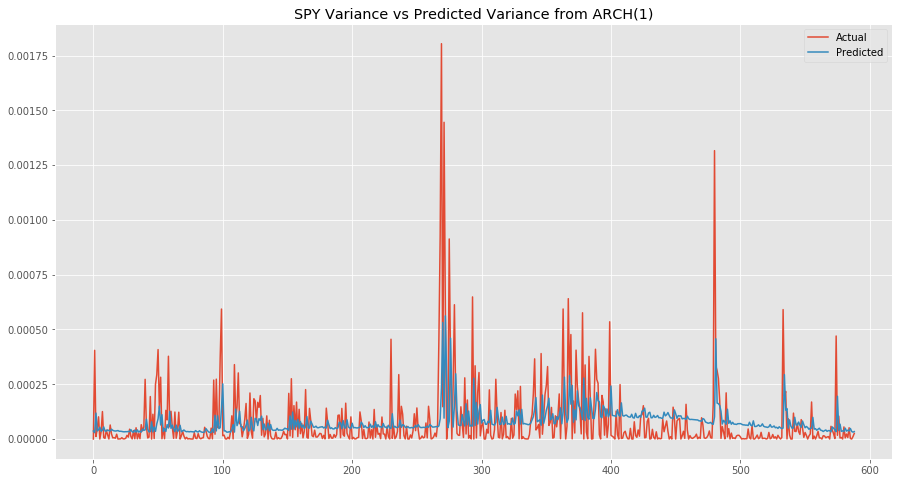

In [515]:
PRED_1[:,0]
plt.plot(ACTUAL, label='Actual')
plt.plot(PRED_1[:,0], label='Predicted')
plt.title("SPY Variance vs Predicted Variance from ARCH(1)")
plt.legend()
plt.savefig("arch.png", bbox_inches='tight')

In [516]:
rolling_ar_errors = measure_error(ACTUAL, PRED_1[:,0], label='RMSE ARCH(1)'  )

RMSE = 0.00015760018121505748
RMSE_pcent = 1.9817494383790915
label = RMSE ARCH(1)


#### Time to check if we made money with this strategy:

In [517]:
## Calculating PNL 
dir = []
for i in range(len(PRED_1)-1):
    for j in range(len(PRED_1[0])):
        if ACTUAL[i] < PRED_1[i+1][j]:
            dir.append(1)
        else:
            dir.append(-1)

In [518]:
dir1=np.reshape(dir, (588, 6))

In [519]:
act_vix_lst = df_data.loc[df_data.Date > '2014-07-29',["VIX","VIXCM30","VIXCM60","VIXCM90","VIXCM120","VIXCM150"]]
act_vix_lst = act_vix_lst.values
diff = np.diff(act_vix_lst, axis=0)

In [520]:
money_accumulated = np.multiply(diff,dir1)
PnL = np.sum(money_accumulated)
print(PnL)

-58.35501325999999


### Summary of ARCH and GARCH Models

model | PnL | RMSE
--|--|--
ARCH(1) | -58.3550| 0.000157
GARCH(1,1) | -78.4006 | 0.000153
GARCH(2,1) | -99.9630| 0.000152
GARCH(2,2) | -91.0460 | 0.000150
GARCH(3,2) | -95.5904 | 0.000152

While our RMSEs look quite strong, none of these models seem to result in a profitable strategy, so we will move onto try VECM models.

## <font color='#114B5F'><p style="text-align: center;"><a id='vecm-anchor'></a>VECM</p></font>

## <font color='#114B5F'><p><b>VECM Models</b></p></font>
<ol><li><a href='#vecm30-anchor'>VIXCM30 </a></li>
    <li><a href='#vecm60-anchor'>VIXCM60 </a></li>
    <li><a href='#vecm90-anchor'>VIXCM90 </a></li>
    <li><a href='#vecm120-anchor'>VIXCM120 </a></li>
    <li><a href='#vecm150-anchor'>VIXCM150 </a></li>
    <li><a href='#vecm_summary-anchor'>Summary of VECM Models</a></li>
</ol>

### <font color='#114B5F'><p style="text-align: center;"><a id='vecm30-anchor'></a>VIXCM30</p></font>

##### VIXCM30

First let's take a look at the plotted data: 

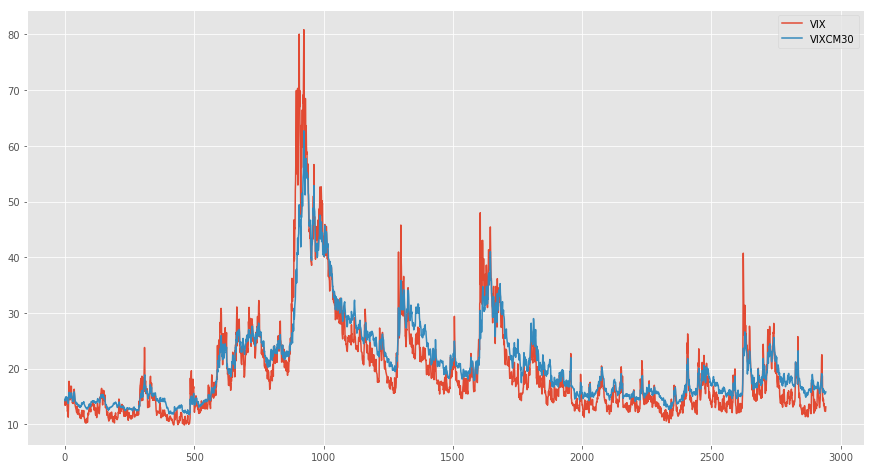

In [132]:
df_data.VIX.plot(label='VIX')
df_data.VIXCM30.plot(label='VIXCM30')
plt.legend()

The two variables look cointegrated, but let's run a Johansen Test to be sure:

In [133]:
d = {'vix': df_data['VIX'],
     'vixcm30':df_data['VIXCM30']
    }
df = pd.DataFrame(d)
c = coint_johansen(df,1,63)
c

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 39.5184 16.1619 18.3985 23.1485
r = 1 	 8.231 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.2874 15.0006 17.1481 21.7465
r = 1 	 8.231 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.77065652 -0.08729355]
 [-0.83501063  0.23909376]]
--------------------------------------------------
eigenvalues:
 [0.0108086 0.0028549]
--------------------------------------------------


The test confirms they are cointegrated so we can build the model:

In [62]:
train,test = train_test_split(df_data, test_size=0.2, shuffle=False)

In [8]:
H = train[['VIX', 'VIXCM30']].dropna()
v = VECM(H, exog=train['SPY'],deterministic='li', k_ar_diff=20)
f = v.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation VIX
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1       -6.127e-05      0.000     -0.151      0.880      -0.001       0.001
L1.VIX         -0.3103      0.042     -7.325      0.000      -0.393      -0.227
L1.VIXCM30      0.2802      0.088      3.169      0.002       0.107       0.453
L2.VIX         -0.2080      0.043     -4.863      0.000      -0.292      -0.124
L2.VIXCM30      0.1658      0.089      1.872      0.061      -0.008       0.339
L3.VIX         -0.1166      0.043     -2.718      0.007      -0.201      -0.033
L3.VIXCM30      0.0563      0.089      0.635      0.525      -0.117       0.230
L4.VIX         -0.1284      0.043     -2.989      0.003      -0.213      -0.044
L4.VIXCM30      0.0175      0.089      0.197      0.843      -0.156       0.191
L5.VIX          0.0449      0.043      1.045      0.296      -0.039       0.129
L5.VIXCM30     -0.2715      0.089     -3.066      0.002      -0.445      -0.098
L6.VIX         -0.0783      0.043     -1.825      0.068      -0.162       0.006
L6.VIXCM30      0.1179      0.089      1.330      0.183      -0.056       0.292
L7.VIX         -0.0661      0.043     -1.543      0.123      -0.150       0.018
L7.VIXCM30     -0.0227      0.089     -0.256      0.798      -0.196       0.151
L8.VIX          0.0640      0.043      1.495      0.135      -0.020       0.148
L8.VIXCM30     -0.1825      0.089     -2.062      0.039      -0.356      -0.009
L9.VIX          0.0832      0.043      1.944      0.052      -0.001       0.167
L9.VIXCM30     -0.2264      0.089     -2.555      0.011      -0.400      -0.053
L10.VIX         0.1476      0.043      3.450      0.001       0.064       0.231
L10.VIXCM30    -0.1111      0.089     -1.252      0.211      -0.285       0.063
L11.VIX         0.1314      0.043      3.065      0.002       0.047       0.215
L11.VIXCM30    -0.2368      0.089     -2.670      0.008      -0.411      -0.063
L12.VIX        -0.0393      0.043     -0.918      0.359      -0.123       0.045
L12.VIXCM30     0.1105      0.089      1.245      0.213      -0.063       0.284
L13.VIX        -0.0114      0.043     -0.267      0.789      -0.095       0.072
L13.VIXCM30    -0.0027      0.089     -0.030      0.976      -0.177       0.171
L14.VIX         0.1181      0.042      2.787      0.005       0.035       0.201
L14.VIXCM30    -0.2756      0.089     -3.112      0.002      -0.449      -0.102
L15.VIX         0.0855      0.042      2.023      0.043       0.003       0.168
L15.VIXCM30    -0.1531      0.089     -1.730      0.084      -0.327       0.020
L16.VIX         0.1011      0.042      2.393      0.017       0.018       0.184
L16.VIXCM30    -0.0786      0.088     -0.888      0.375      -0.252       0.095
L17.VIX         0.0745      0.042      1.772      0.076      -0.008       0.157
L17.VIXCM30    -0.0325      0.088     -0.368      0.713      -0.206       0.141
L18.VIX         0.0057      0.042      0.136      0.892      -0.076       0.087
L18.VIXCM30    -0.0607      0.088     -0.689      0.491      -0.233       0.112
L19.VIX         0.1579      0.041      3.845      0.000       0.077       0.238
L19.VIXCM30    -0.3513      0.088     -4.007      0.000      -0.523      -0.179
L20.VIX         0.0813      0.040      2.047      0.041       0.003       0.159
L20.VIXCM30    -0.1109      0.087     -1.278      0.201      -0.281       0.059
Det. terms outside the coint. relation & lagged endog. parameters for equation VIXCM30
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1           0.0005

Picking up residuals for VIXCM30 series from the model:

In [9]:
# getting the lag to remove residual information
resid_vixcm30 = []
for i in range(len(f.resid)):
    resid_vixcm30 += [f.resid[i][1]]

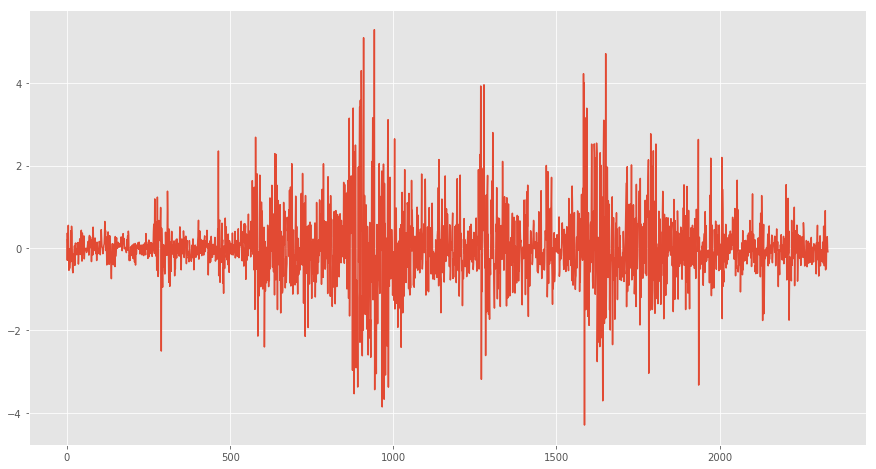

In [18]:
plt.plot(resid_vixcm30)

In [13]:
run_ljung_box(resid_vixcm30, 80)

Ljung-Box Test


No information is left in the residuals!

Now we can check how the model is performing:

In [14]:
H = train[['VIX', 'VIXCM30', 'SPY']].dropna()
res = []
for date, row in test.iterrows(): 
    v = VECM(H[['VIX', 'VIXCM30']], exog=H['SPY'], deterministic='li', k_ar_diff=20)
    f = v.fit()
    res += [f.predict(steps=1, exog_fc=test['SPY'])[0][1]]
    H = H.append(row[['VIX', 'VIXCM30', 'SPY']])
    H = H[1:].dropna()

In [15]:
plot_df = pd.DataFrame()
plot_df['Date'] = test.iloc[:, 0].values
plot_df['VIXCM30_actual'] = test.iloc[:, 4].values
plot_df['VIXCM30_predicted'] = res

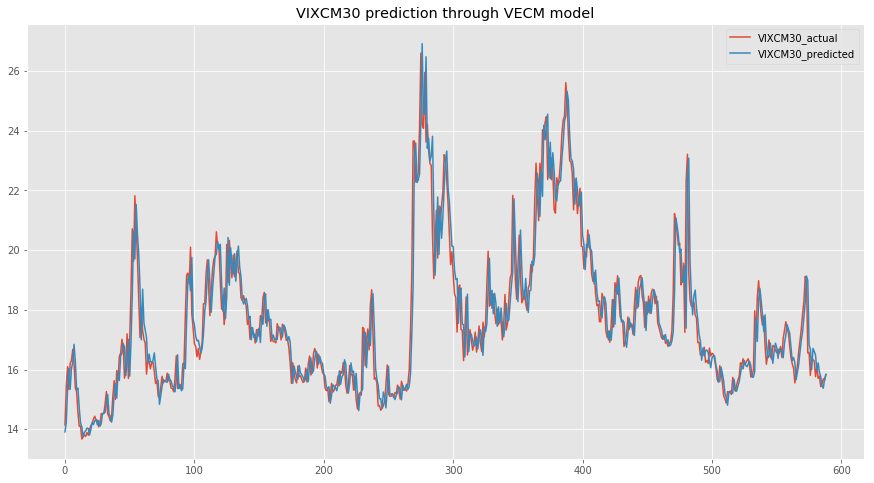

In [19]:
plot_df.VIXCM30_actual.plot()
plot_df.VIXCM30_predicted.plot()
plt.title("VIXCM30 prediction through VECM model")
plt.legend()

Looking closely into a random sample of the predictions:

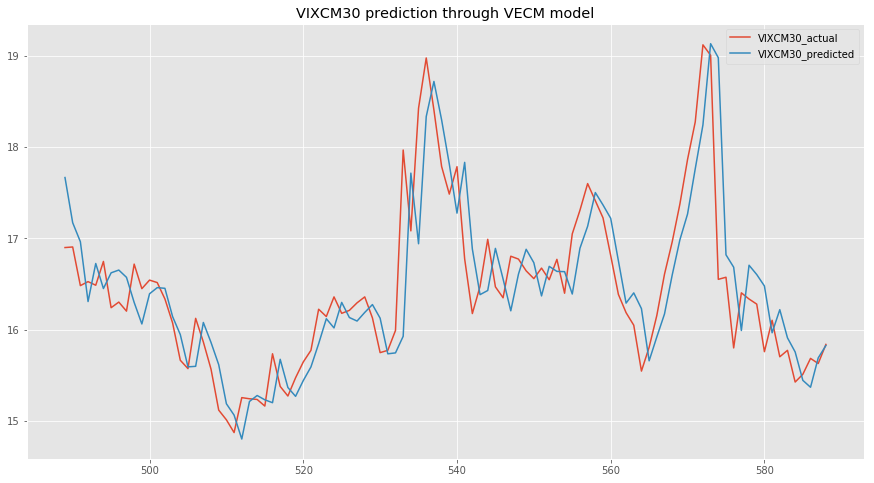

In [20]:
plot_df.VIXCM30_actual[-100:].plot()
plot_df.VIXCM30_predicted[-100:].plot()
plt.title("VIXCM30 prediction through VECM model")
plt.legend()

In [23]:
ar_error2 = measure_error(plot_df['VIXCM30_actual'].values, plot_df['VIXCM30_predicted'].values, label='VECM_30')
print(ar_error2)

RMSE = 0.8218564880183119
RMSE_pcent = 0.04658378560777323
label = VECM_30
{'RMSE': 0.8218564880183119, 'RMSE_pcent': 0.04658378560777323, 'label': 'VECM_30'}


In [26]:
make_money(plot_df.VIXCM30_actual, plot_df.VIXCM30_predicted)

Total profit or loss: 17.6314
Number of correct days: 310
total incorrect days: 278


### <font color='#114B5F'><p style="text-align: center;"><a id='vecm60-anchor'></a>VIXCM60</p></font>

##### VIXCM60

First let's take a look at the plotted data: 

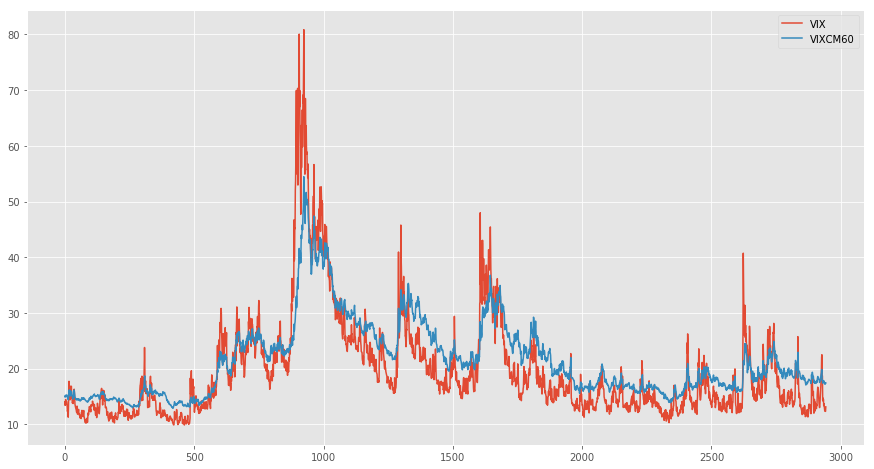

In [20]:
df_data.VIX.plot(label='VIX')
df_data.VIXCM60.plot(label='VIXCM60')
plt.legend()

The two variables look cointegrated, but let's run a Johansen Test to be sure:

In [21]:
d = {'vix': df_data['VIX'],
     'vixcm60':df_data['VIXCM60']
    }
df = pd.DataFrame(d)
c = coint_johansen(df,1,63)
c

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.388 16.1619 18.3985 23.1485
r = 1 	 7.2609 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.1271 15.0006 17.1481 21.7465
r = 1 	 7.2609 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.48077253 -0.10256322]
 [-0.52658657  0.27381262]]
--------------------------------------------------
eigenvalues:
 [0.00800084 0.00251885]
--------------------------------------------------


Now we can build the model:

In [22]:
H = train[['VIX', 'VIXCM60']].dropna()
v = VECM(H, exog=train['SPY'],deterministic='li', k_ar_diff=20)
f = v.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation VIX
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1          -0.0002      0.000     -0.358      0.720      -0.001       0.001
L1.VIX         -0.3074      0.038     -8.014      0.000      -0.383      -0.232
L1.VIXCM60      0.3885      0.111      3.510      0.000       0.172       0.605
L2.VIX         -0.1803      0.039     -4.649      0.000      -0.256      -0.104
L2.VIXCM60      0.1506      0.111      1.357      0.175      -0.067       0.368
L3.VIX         -0.0317      0.039     -0.816      0.414      -0.108       0.044
L3.VIXCM60     -0.1912      0.111     -1.722      0.085      -0.409       0.026
L4.VIX         -0.0966      0.039     -2.486      0.013      -0.173      -0.020
L4.VIXCM60     -0.0289      0.111     -0.261      0.794      -0.246       0.188
L5.VIX          0.0369      0.039      0.950      0.342      -0.039       0.113
L5.VIXCM60     -0.3169      0.111     -2.861      0.004      -0.534      -0.100
L6.VIX         -0.0321      0.039     -0.825      0.409      -0.108       0.044
L6.VIXCM60      0.0223      0.111      0.201      0.841      -0.195       0.240
L7.VIX         -0.0779      0.039     -2.004      0.045      -0.154      -0.002
L7.VIXCM60      0.0392      0.111      0.354      0.724      -0.178       0.257
L8.VIX          0.0485      0.039      1.251      0.211      -0.028       0.125
L8.VIXCM60     -0.1901      0.111     -1.715      0.086      -0.407       0.027
L9.VIX          0.0451      0.039      1.163      0.245      -0.031       0.121
L9.VIXCM60     -0.1629      0.111     -1.469      0.142      -0.380       0.054
L10.VIX         0.1432      0.039      3.687      0.000       0.067       0.219
L10.VIXCM60    -0.1457      0.111     -1.314      0.189      -0.363       0.072
L11.VIX         0.0310      0.039      0.795      0.427      -0.045       0.107
L11.VIXCM60    -0.0177      0.111     -0.160      0.873      -0.235       0.200
L12.VIX        -0.0805      0.039     -2.070      0.038      -0.157      -0.004
L12.VIXCM60     0.2636      0.111      2.380      0.017       0.047       0.481
L13.VIX        -0.0061      0.039     -0.156      0.876      -0.082       0.070
L13.VIXCM60    -0.0395      0.111     -0.356      0.722      -0.257       0.178
L14.VIX         0.1011      0.039      2.616      0.009       0.025       0.177
L14.VIXCM60    -0.3335      0.111     -3.013      0.003      -0.550      -0.117
L15.VIX         0.0588      0.039      1.524      0.127      -0.017       0.135
L15.VIXCM60    -0.1454      0.111     -1.312      0.189      -0.363       0.072
L16.VIX         0.1134      0.039      2.942      0.003       0.038       0.189
L16.VIXCM60    -0.1718      0.111     -1.553      0.121      -0.389       0.045
L17.VIX         0.0410      0.038      1.067      0.286      -0.034       0.116
L17.VIXCM60     0.0449      0.111      0.406      0.685      -0.172       0.262
L18.VIX        -0.0064      0.038     -0.168      0.867      -0.081       0.069
L18.VIXCM60    -0.0661      0.111     -0.598      0.550      -0.283       0.151
L19.VIX         0.1312      0.038      3.471      0.001       0.057       0.205
L19.VIXCM60    -0.3803      0.110     -3.446      0.001      -0.597      -0.164
L20.VIX         0.0642      0.037      1.741      0.082      -0.008       0.136
L20.VIXCM60    -0.1120      0.110     -1.021      0.307      -0.327       0.103
Det. terms outside the coint. relation & lagged endog. parameters for equation VIXCM60
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1           0.0003

In [23]:
# getting the lag to remove residual information
resid_vixcm60 = []
for i in range(len(f.resid)):
    resid_vixcm60 += [f.resid[i][1]]

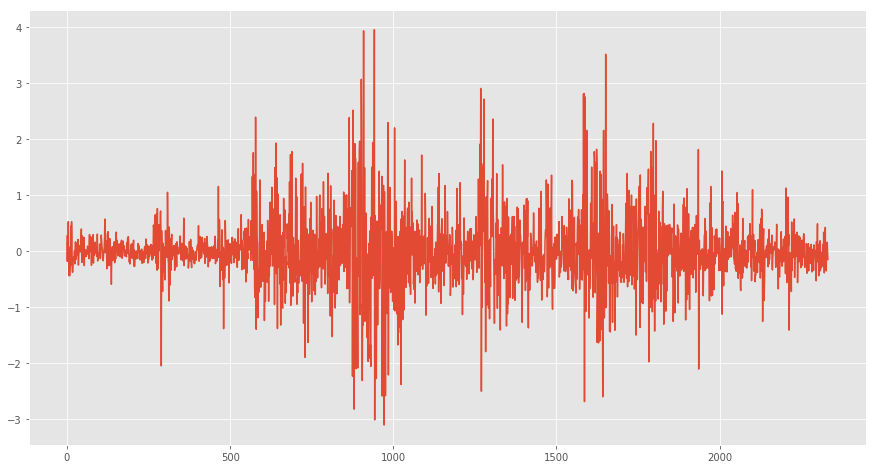

In [25]:
plt.plot(resid_vixcm60)

In [26]:
run_ljung_box(resid_vixcm60, 80)

Ljung-Box Test


Now we can check how the model is performing:

In [27]:
H = train[['VIX', 'VIXCM60', 'SPY']].dropna()
res = []
for date, row in test.iterrows(): 
    v = VECM(H[['VIX', 'VIXCM60']], exog=H['SPY'], deterministic='li', k_ar_diff=20)
    f = v.fit()
    res += [f.predict(steps=1, exog_fc=test['SPY'])[0][1]]
    H = H.append(row[['VIX', 'VIXCM60', 'SPY']])
    H = H[1:].dropna()

In [28]:
plot_df = pd.DataFrame()
plot_df['Date'] = test.iloc[:, 0].values
plot_df['VIXCM60_actual'] = test.iloc[:, 5].values
plot_df['VIXCM60_predicted'] = res

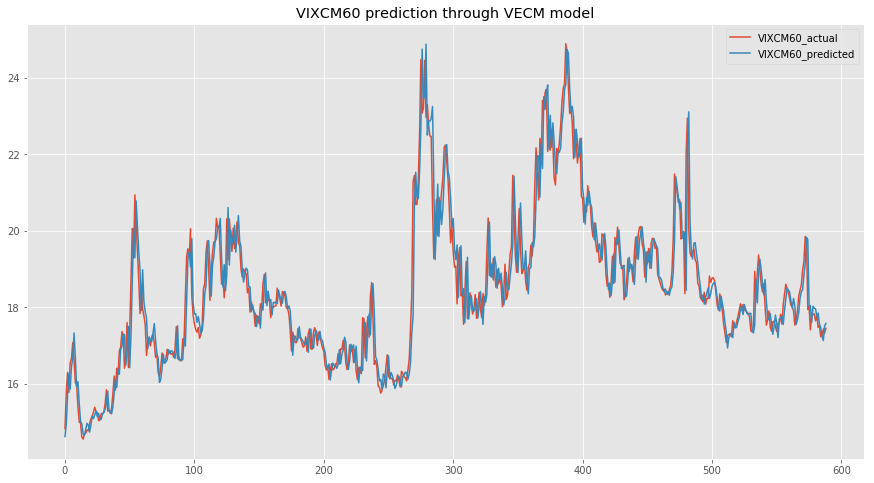

In [29]:
plot_df.VIXCM60_actual.plot()
plot_df.VIXCM60_predicted.plot()
plt.title("VIXCM60 prediction through VECM model")
plt.legend()

In [30]:
ar_error2 = measure_error(plot_df['VIXCM60_actual'].values, plot_df['VIXCM60_predicted'].values, label='VECM_60')
print(ar_error2)

RMSE = 0.619971615010414
RMSE_pcent = 0.03360636343771486
label = VECM_60
{'RMSE': 0.619971615010414, 'RMSE_pcent': 0.03360636343771486, 'label': 'VECM_60'}


In [33]:
make_money(plot_df.VIXCM60_actual, plot_df.VIXCM60_predicted)

Total profit or loss: -8.6022
Number of correct days: 301
total incorrect days: 287


### <font color='#114B5F'><p style="text-align: center;"><a id='vecm90-anchor'></a>VIXCM90</p></font>

##### VIXCM90

First let's take a look at the plotted data: 

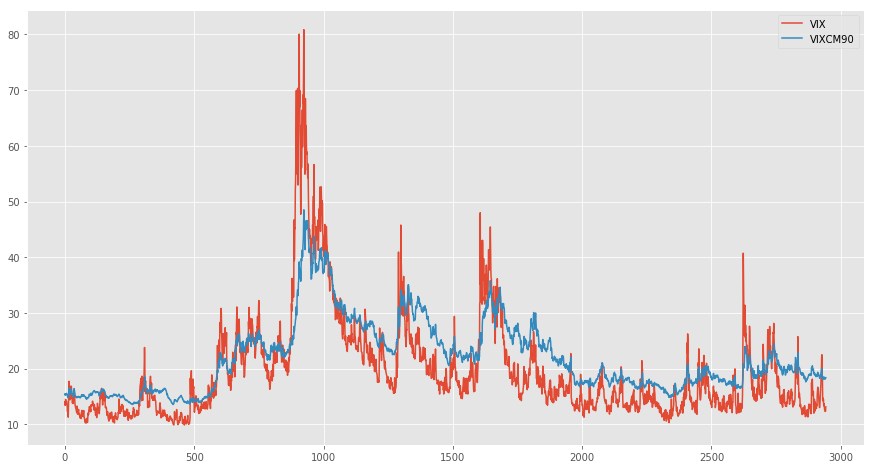

In [34]:
df_data.VIX.plot(label='VIX')
df_data.VIXCM90.plot(label='VIXCM90')
plt.legend()

The two variables look cointegrated, but let's run a Johansen Test to be sure:

In [35]:
d = {'vix': df_data['VIX'],
     'vixcm90':df_data['VIXCM90']
    }
df = pd.DataFrame(d)
c = coint_johansen(df,1,63)
c

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.0345 16.1619 18.3985 23.1485
r = 1 	 7.0617 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.9729 15.0006 17.1481 21.7465
r = 1 	 7.0617 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.38643582 -0.07550673]
 [-0.42911003  0.25519026]]
--------------------------------------------------
eigenvalues:
 [0.00794771 0.00244981]
--------------------------------------------------


Now we can build the model:

In [36]:
H = train[['VIX', 'VIXCM90']].dropna()
v = VECM(H, deterministic='li',exog=train['SPY'], k_ar_diff=20)
f = v.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation VIX
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1          -0.0003      0.000     -0.687      0.492      -0.001       0.001
L1.VIX         -0.3300      0.036     -9.224      0.000      -0.400      -0.260
L1.VIXCM90      0.6012      0.123      4.897      0.000       0.361       0.842
L2.VIX         -0.1274      0.036     -3.499      0.000      -0.199      -0.056
L2.VIXCM90     -0.0456      0.123     -0.370      0.711      -0.287       0.196
L3.VIX         -0.0130      0.036     -0.356      0.722      -0.084       0.059
L3.VIXCM90     -0.2710      0.123     -2.197      0.028      -0.513      -0.029
L4.VIX         -0.0855      0.036     -2.346      0.019      -0.157      -0.014
L4.VIXCM90     -0.0476      0.123     -0.386      0.700      -0.289       0.194
L5.VIX          0.0202      0.036      0.553      0.580      -0.051       0.092
L5.VIXCM90     -0.2812      0.123     -2.282      0.023      -0.523      -0.040
L6.VIX         -0.0125      0.037     -0.341      0.733      -0.084       0.059
L6.VIXCM90     -0.0312      0.123     -0.253      0.800      -0.273       0.211
L7.VIX         -0.0775      0.037     -2.120      0.034      -0.149      -0.006
L7.VIXCM90      0.0171      0.124      0.138      0.890      -0.225       0.259
L8.VIX          0.0228      0.037      0.623      0.533      -0.049       0.094
L8.VIXCM90     -0.1166      0.123     -0.945      0.345      -0.359       0.125
L9.VIX          0.0387      0.037      1.059      0.290      -0.033       0.110
L9.VIXCM90     -0.1416      0.123     -1.147      0.251      -0.383       0.100
L10.VIX         0.1620      0.037      4.434      0.000       0.090       0.234
L10.VIXCM90    -0.2312      0.124     -1.871      0.061      -0.473       0.011
L11.VIX         0.0099      0.037      0.269      0.788      -0.062       0.082
L11.VIXCM90     0.0697      0.123      0.565      0.572      -0.172       0.312
L12.VIX        -0.0693      0.037     -1.890      0.059      -0.141       0.003
L12.VIXCM90     0.2686      0.123      2.180      0.029       0.027       0.510
L13.VIX         0.0069      0.037      0.188      0.851      -0.065       0.079
L13.VIXCM90    -0.0892      0.123     -0.724      0.469      -0.331       0.153
L14.VIX         0.1127      0.036      3.099      0.002       0.041       0.184
L14.VIXCM90    -0.4459      0.123     -3.623      0.000      -0.687      -0.205
L15.VIX         0.0487      0.036      1.340      0.180      -0.023       0.120
L15.VIXCM90    -0.1032      0.123     -0.839      0.401      -0.344       0.138
L16.VIX         0.1249      0.036      3.450      0.001       0.054       0.196
L16.VIXCM90    -0.2495      0.123     -2.035      0.042      -0.490      -0.009
L17.VIX         0.0165      0.036      0.457      0.648      -0.054       0.087
L17.VIXCM90     0.1683      0.123      1.372      0.170      -0.072       0.409
L18.VIX        -0.0113      0.036     -0.314      0.754      -0.082       0.059
L18.VIXCM90    -0.0790      0.123     -0.645      0.519      -0.319       0.161
L19.VIX         0.0603      0.036      1.696      0.090      -0.009       0.130
L19.VIXCM90    -0.1572      0.123     -1.283      0.200      -0.397       0.083
L20.VIX         0.0730      0.035      2.111      0.035       0.005       0.141
L20.VIXCM90    -0.1793      0.121     -1.478      0.140      -0.417       0.059
Det. terms outside the coint. relation & lagged endog. parameters for equation VIXCM90
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
exog1           0.0002

In [37]:
# getting the lag to remove residual information
resid_vixcm90 = []
for i in range(len(f.resid)):
    resid_vixcm90 += [f.resid[i][1]]

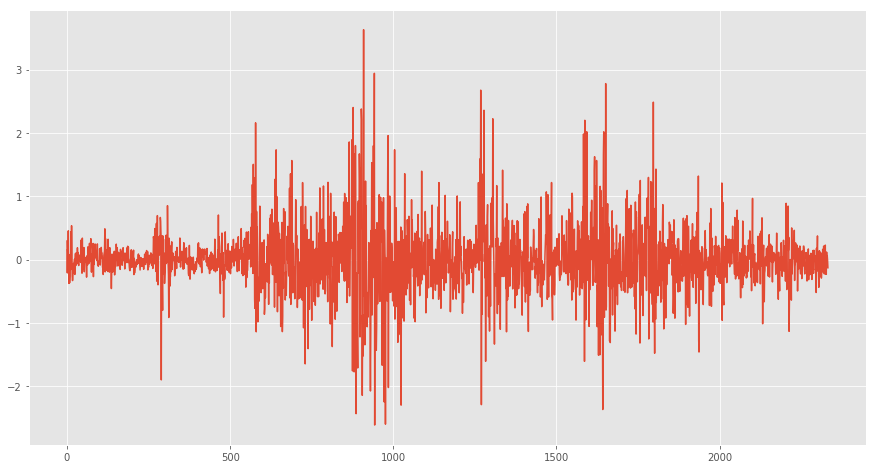

In [38]:
plt.plot(resid_vixcm90)

In [39]:
run_ljung_box(resid_vixcm90, 80)

Ljung-Box Test


Now we can check how the model is performing:

In [40]:
H = train[['VIX', 'VIXCM90', 'SPY']].dropna()
res = []
for date, row in test.iterrows(): 
    v = VECM(H[['VIX', 'VIXCM90']], exog=H['SPY'], deterministic='li', k_ar_diff=20)
    f = v.fit()
    res += [f.predict(steps=1, exog_fc=test['SPY'])[0][1]]
    H = H.append(row[['VIX', 'VIXCM90', 'SPY']])
    H = H[1:].dropna()

In [41]:
plot_df = pd.DataFrame()
plot_df['Date'] = test.iloc[:,0].values
plot_df['VIXCM90_actual'] = test.iloc[:, 6].values
plot_df['VIXCM90_predicted'] = res

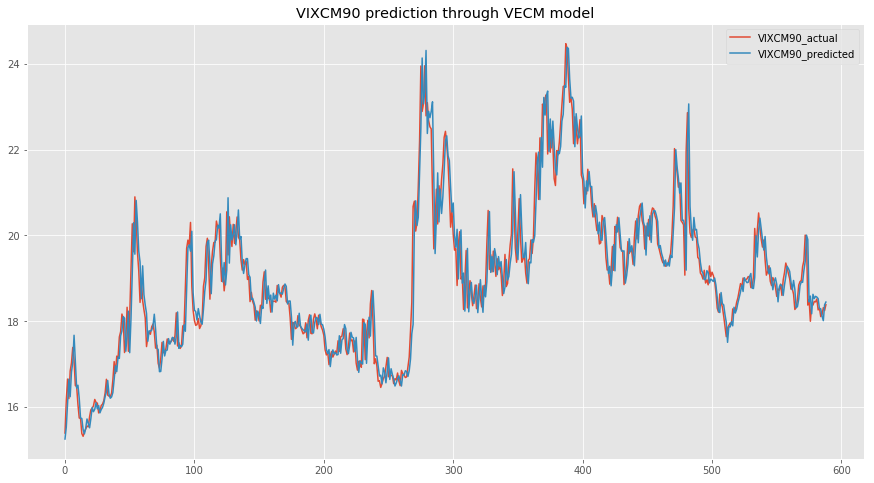

In [42]:
plot_df.VIXCM90_actual.plot()
plot_df.VIXCM90_predicted.plot()
plt.title("VIXCM90 prediction through VECM model")
plt.legend()

In [43]:
ar_error2 = measure_error(plot_df['VIXCM90_actual'].values, plot_df['VIXCM90_predicted'].values, label='VECM_90')
print(ar_error2)

RMSE = 0.5184302696563623
RMSE_pcent = 0.027288800658595697
label = VECM_90
{'RMSE': 0.5184302696563623, 'RMSE_pcent': 0.027288800658595697, 'label': 'VECM_90'}


In [44]:
make_money(plot_df.VIXCM90_actual, plot_df.VIXCM90_predicted)

Total profit or loss: -13.8828
Number of correct days: 286
total incorrect days: 302


### <font color='#114B5F'><p style="text-align: center;"><a id='vecm120-anchor'></a>VIXCM120</p></font>

##### VIXCM120

First let's take a look at the plotted data: 

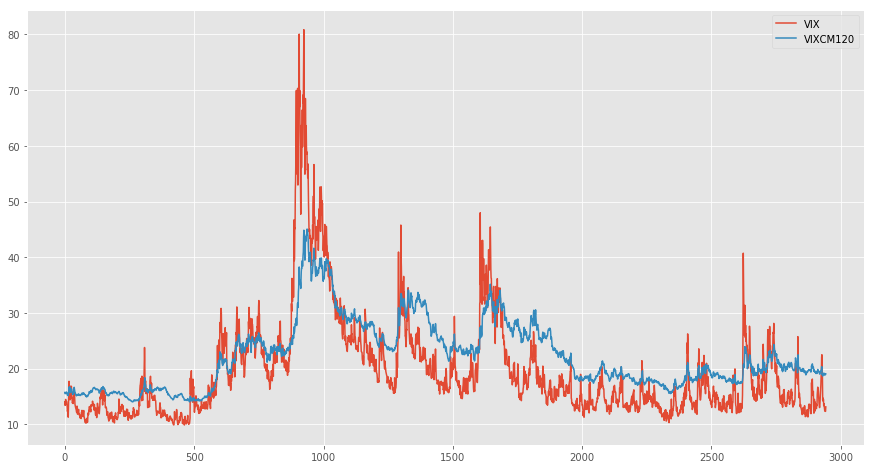

In [59]:
df_data.VIX.plot(label='VIX')
df_data.VIXCM120.plot(label='VIXCM120')
plt.legend()

The two variables look cointegrated, but let's run a Johansen Test to be sure:

In [60]:
d = {'vix': df_data['VIX'],
     'vixcm120':df_data['VIXCM120']
    }
df = pd.DataFrame(d)
c = coint_johansen(df,1,63)
c

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.3306 16.1619 18.3985 23.1485
r = 1 	 6.8779 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.4527 15.0006 17.1481 21.7465
r = 1 	 6.8779 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.3257479  -0.08536839]
 [-0.35188173  0.27314798]]
--------------------------------------------------
eigenvalues:
 [0.00673399 0.00238613]
--------------------------------------------------


Now we can build the model:

In [63]:
H = train[['VIX', 'VIXCM120']].dropna()
v = VECM(H, deterministic='li', exog=train['SPY'], k_ar_diff=20)
f = v.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation VIX
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
exog1           -0.0005      0.000     -1.090      0.276      -0.001       0.000
L1.VIX          -0.3271      0.033    -10.048      0.000      -0.391      -0.263
L1.VIXCM120      0.7426      0.124      5.999      0.000       0.500       0.985
L2.VIX          -0.1192      0.033     -3.579      0.000      -0.185      -0.054
L2.VIXCM120     -0.0553      0.125     -0.443      0.657      -0.300       0.189
L3.VIX          -0.0321      0.033     -0.964      0.335      -0.097       0.033
L3.VIXCM120     -0.2460      0.125     -1.972      0.049      -0.490      -0.002
L4.VIX          -0.1220      0.033     -3.658      0.000      -0.187      -0.057
L4.VIXCM120      0.1987      0.125      1.593      0.111      -0.046       0.443
L5.VIX           0.0409      0.033      1.223      0.221      -0.025       0.106
L5.VIXCM120     -0.4333      0.125     -3.475      0.001      -0.678      -0.189
L6.VIX           0.0269      0.033      0.805      0.421      -0.039       0.092
L6.VIXCM120     -0.2042      0.125     -1.635      0.102      -0.449       0.041
L7.VIX          -0.0694      0.033     -2.074      0.038      -0.135      -0.004
L7.VIXCM120      0.0257      0.125      0.205      0.837      -0.219       0.271
L8.VIX           0.0205      0.033      0.615      0.539      -0.045       0.086
L8.VIXCM120     -0.1645      0.125     -1.317      0.188      -0.409       0.080
L9.VIX           0.0229      0.033      0.685      0.494      -0.043       0.088
L9.VIXCM120     -0.0369      0.125     -0.295      0.768      -0.282       0.208
L10.VIX          0.1667      0.033      4.995      0.000       0.101       0.232
L10.VIXCM120    -0.3038      0.125     -2.434      0.015      -0.548      -0.059
L11.VIX          0.0147      0.034      0.437      0.662      -0.051       0.080
L11.VIXCM120     0.0343      0.125      0.275      0.783      -0.210       0.279
L12.VIX         -0.0732      0.033     -2.184      0.029      -0.139      -0.008
L12.VIXCM120     0.3736      0.125      2.994      0.003       0.129       0.618
L13.VIX          0.0361      0.033      1.079      0.281      -0.030       0.102
L13.VIXCM120    -0.2547      0.125     -2.037      0.042      -0.500      -0.010
L14.VIX          0.0898      0.033      2.701      0.007       0.025       0.155
L14.VIXCM120    -0.4045      0.125     -3.241      0.001      -0.649      -0.160
L15.VIX          0.0180      0.033      0.542      0.588      -0.047       0.083
L15.VIXCM120     0.0403      0.125      0.322      0.747      -0.204       0.285
L16.VIX          0.1174      0.033      3.548      0.000       0.053       0.182
L16.VIXCM120    -0.2830      0.124     -2.274      0.023      -0.527      -0.039
L17.VIX          0.0158      0.033      0.478      0.633      -0.049       0.081
L17.VIXCM120     0.1993      0.125      1.600      0.110      -0.045       0.443
L18.VIX         -0.0484      0.033     -1.469      0.142      -0.113       0.016
L18.VIXCM120     0.0854      0.125      0.685      0.493      -0.159       0.330
L19.VIX          0.0501      0.033      1.536      0.125      -0.014       0.114
L19.VIXCM120    -0.1705      0.124     -1.370      0.171      -0.414       0.073
L20.VIX          0.0710      0.032      2.240      0.025       0.009       0.133
L20.VIXCM120    -0.1641      0.123     -1.332      0.183      -0.406       0.077
Det. terms outside the coint. relation & lagged endog. parameters for equation VIXCM120
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [64]:
# getting the lag to remove residual information
resid_vixcm120 = []
for i in range(len(f.resid)):
    resid_vixcm120 += [f.resid[i][1]]

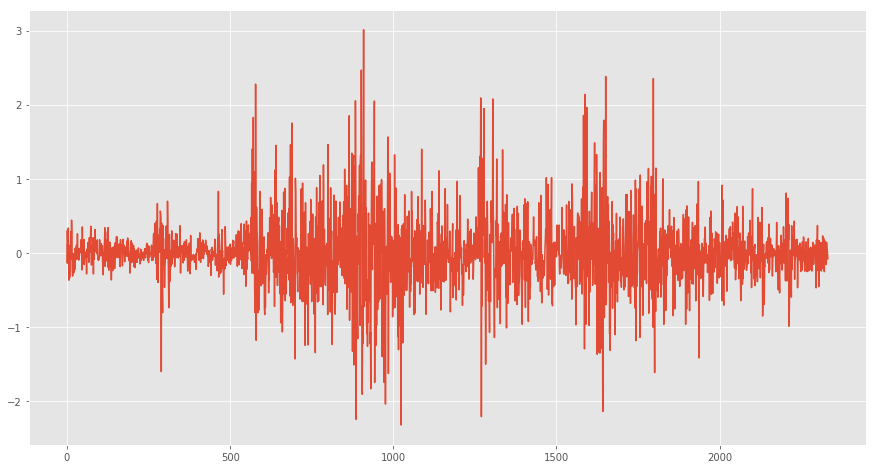

In [66]:
plt.plot(resid_vixcm120)

In [67]:
run_ljung_box(resid_vixcm120, 80)

Ljung-Box Test


Now we can check how the model is performing:

In [68]:
H = train[['VIX', 'VIXCM120', 'SPY']].dropna()
res = []
for date, row in test.iterrows(): 
    v = VECM(H[['VIX', 'VIXCM120']], exog=H['SPY'], deterministic='li', k_ar_diff=20)
    f = v.fit()
    res += [f.predict(steps=1, exog_fc=test['SPY'])[0][1]]
    H = H.append(row[['VIX', 'VIXCM120', 'SPY']])
    H = H[1:].dropna()

In [69]:
plot_df = pd.DataFrame()
plot_df['Date'] = test.iloc[:,0].values
plot_df['VIXCM120_actual'] = test.iloc[:,7].values
plot_df['VIXCM120_predicted'] = res

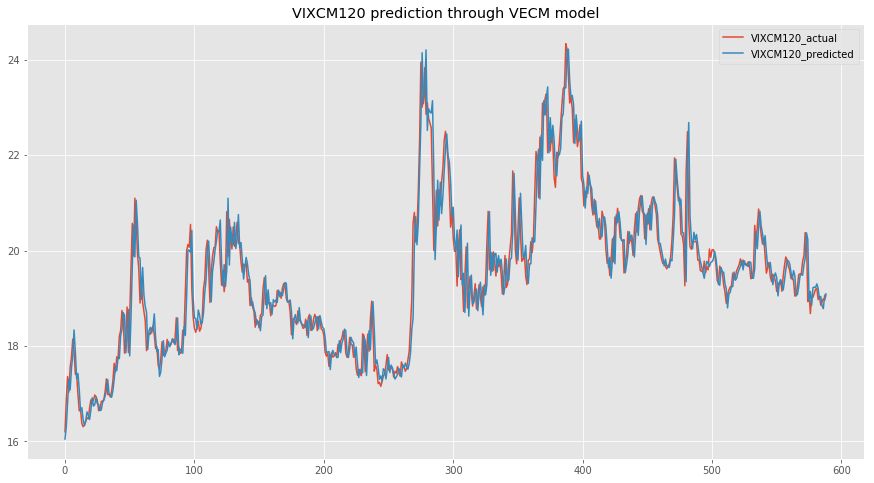

In [70]:
plot_df.VIXCM120_actual.plot()
plot_df.VIXCM120_predicted.plot()
plt.title("VIXCM120 prediction through VECM model")
plt.legend()

In [71]:
ar_error2 = measure_error(plot_df['VIXCM120_actual'].values, plot_df['VIXCM120_predicted'].values, label='VECM')
print(ar_error2)

RMSE = 0.4581289208624565
RMSE_pcent = 0.023545101076493956
label = VECM
{'RMSE': 0.4581289208624565, 'RMSE_pcent': 0.023545101076493956, 'label': 'VECM'}


In [72]:
make_money(plot_df.VIXCM120_actual, plot_df.VIXCM120_predicted)

Total profit or loss: -7.5644
Number of correct days: 294
total incorrect days: 294


### <font color='#114B5F'><p style="text-align: center;"><a id='vecm150-anchor'></a>VIXCM150</p></font>

##### VIXCM150

First let's take a look at the plotted data: 

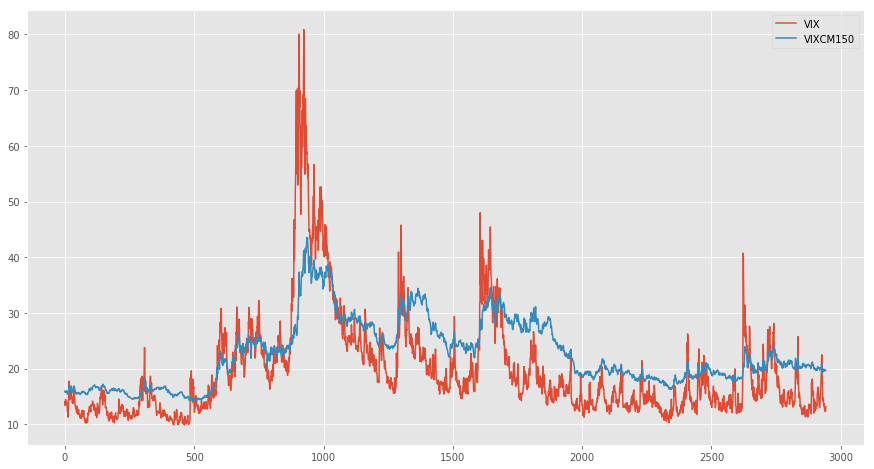

In [73]:
df_data.VIX.plot(label='VIX')
df_data.VIXCM150.plot(label='VIXCM150')
plt.legend()

The two variables look cointegrated, but let's run a Johansen Test to be sure:

In [74]:
d = {'vix': df_data['VIX'],
     'vixcm150':df_data['VIXCM150']
    }
df = pd.DataFrame(d)
c = coint_johansen(df,1,63)
c

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.2241 16.1619 18.3985 23.1485
r = 1 	 6.6399 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5842 15.0006 17.1481 21.7465
r = 1 	 6.6399 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.2736747  -0.08686034]
 [-0.28087418  0.27910247]]
--------------------------------------------------
eigenvalues:
 [0.00643429 0.00230366]
--------------------------------------------------


Now we can build the model:

In [75]:
H = train[['VIX', 'VIXCM150']].dropna()
v = VECM(H, deterministic='li', exog=train['SPY'], k_ar_diff=20)
f = v.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
Det. terms outside the coint. relation & lagged endog. parameters for equation VIX
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
exog1           -0.0006      0.000     -1.408      0.159      -0.001       0.000
L1.VIX          -0.2774      0.028     -9.962      0.000      -0.332      -0.223
L1.VIXCM150      0.6254      0.107      5.841      0.000       0.416       0.835
L2.VIX          -0.1153      0.029     -4.033      0.000      -0.171      -0.059
L2.VIXCM150     -0.0241      0.108     -0.222      0.824      -0.236       0.188
L3.VIX          -0.0570      0.029     -1.995      0.046      -0.113      -0.001
L3.VIXCM150     -0.1497      0.108     -1.386      0.166      -0.361       0.062
L4.VIX          -0.1193      0.029     -4.166      0.000      -0.175      -0.063
L4.VIXCM150      0.2803      0.108      2.599      0.009       0.069       0.492
L5.VIX           0.0300      0.029      1.044      0.297      -0.026       0.086
L5.VIXCM150     -0.4177      0.108     -3.868      0.000      -0.629      -0.206
L6.VIX           0.0408      0.029      1.423      0.155      -0.015       0.097
L6.VIXCM150     -0.3165      0.108     -2.930      0.003      -0.528      -0.105
L7.VIX          -0.0588      0.029     -2.054      0.040      -0.115      -0.003
L7.VIXCM150      0.0207      0.108      0.192      0.848      -0.191       0.233
L8.VIX           0.0133      0.029      0.466      0.641      -0.043       0.069
L8.VIXCM150     -0.1734      0.108     -1.605      0.109      -0.385       0.038
L9.VIX           0.0109      0.029      0.383      0.702      -0.045       0.067
L9.VIXCM150      0.0408      0.108      0.377      0.706      -0.171       0.253
L10.VIX          0.1531      0.028      5.374      0.000       0.097       0.209
L10.VIXCM150    -0.2813      0.108     -2.609      0.009      -0.493      -0.070
L11.VIX          0.0278      0.029      0.973      0.330      -0.028       0.084
L11.VIXCM150    -0.0432      0.108     -0.401      0.689      -0.255       0.168
L12.VIX         -0.0454      0.029     -1.589      0.112      -0.101       0.011
L12.VIXCM150     0.3075      0.108      2.849      0.004       0.096       0.519
L13.VIX          0.0301      0.029      1.051      0.293      -0.026       0.086
L13.VIXCM150    -0.2622      0.108     -2.426      0.015      -0.474      -0.050
L14.VIX          0.0487      0.028      1.711      0.087      -0.007       0.104
L14.VIXCM150    -0.2528      0.108     -2.338      0.019      -0.465      -0.041
L15.VIX          0.0039      0.028      0.137      0.891      -0.052       0.059
L15.VIXCM150     0.0855      0.108      0.790      0.429      -0.126       0.297
L16.VIX          0.0885      0.028      3.131      0.002       0.033       0.144
L16.VIXCM150    -0.2076      0.108     -1.922      0.055      -0.419       0.004
L17.VIX          0.0306      0.028      1.087      0.277      -0.025       0.086
L17.VIXCM150     0.1457      0.108      1.349      0.177      -0.066       0.357
L18.VIX         -0.0599      0.028     -2.126      0.033      -0.115      -0.005
L18.VIXCM150     0.1864      0.108      1.725      0.084      -0.025       0.398
L19.VIX          0.0328      0.028      1.172      0.241      -0.022       0.088
L19.VIXCM150    -0.1139      0.108     -1.054      0.292      -0.326       0.098
L20.VIX          0.0691      0.027      2.544      0.011       0.016       0.122
L20.VIXCM150    -0.1710      0.107     -1.596      0.110      -0.381       0.039
Det. terms outside the coint. relation & lagged endog. parameters for equation VIXCM150
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [76]:
# getting the lag to remove residual information
resid_vixcm150 = []
for i in range(len(f.resid)):
    resid_vixcm150 += [f.resid[i][1]]

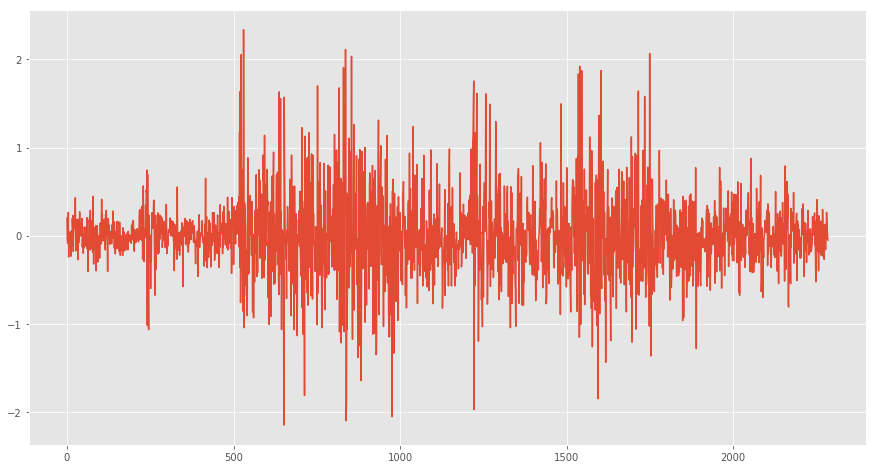

In [190]:
plt.plot(resid_vixcm150)

In [77]:
run_ljung_box(resid_vixcm150, 80)

Ljung-Box Test


Now we can check how the model is performing:

In [78]:
H = train[['VIX', 'VIXCM150', 'SPY']].dropna()
res = []
for date, row in test.iterrows(): 
    v = VECM(H[['VIX', 'VIXCM150']], exog=H['SPY'], deterministic='li', k_ar_diff=20)
    f = v.fit()
    res += [f.predict(steps=1, exog_fc=test['SPY'])[0][1]]
    H = H.append(row[['VIX', 'VIXCM150', 'SPY']])
    H = H[1:].dropna()

In [79]:
plot_df = pd.DataFrame()
plot_df['Date'] = test.iloc[:, 0].values
plot_df['VIXCM150_actual'] = test.iloc[:,8].values
plot_df['VIXCM150_predicted'] = res

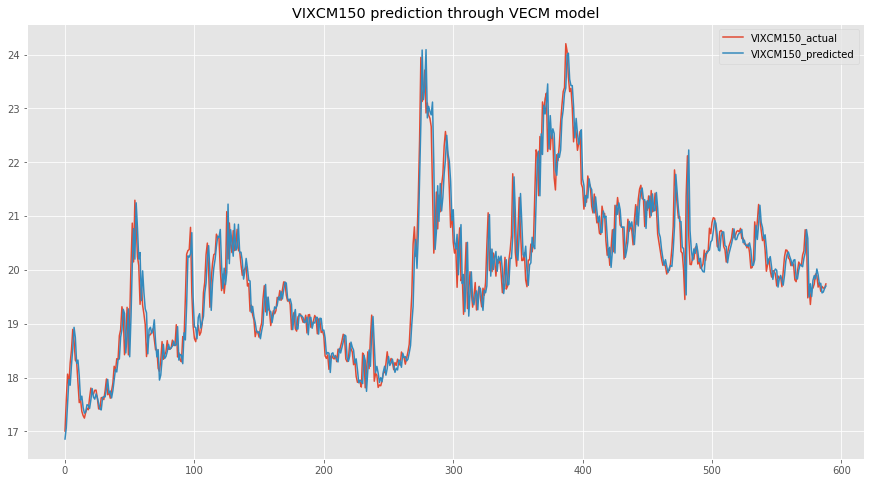

In [80]:
plot_df.VIXCM150_actual.plot()
plot_df.VIXCM150_predicted.plot()
plt.title("VIXCM150 prediction through VECM model")
plt.legend()

In [81]:
ar_error2 = measure_error(plot_df['VIXCM150_actual'].values, plot_df['VIXCM150_predicted'].values, label='VECM')
print(ar_error2)

RMSE = 0.39943060263751484
RMSE_pcent = 0.020057050701287188
label = VECM
{'RMSE': 0.39943060263751484, 'RMSE_pcent': 0.020057050701287188, 'label': 'VECM'}


In [82]:
make_money(plot_df.VIXCM150_actual, plot_df.VIXCM150_predicted)

Total profit or loss: -5.7534
Number of correct days: 290
total incorrect days: 298


### <font color='#114B5F'><p style="text-align: center;"><a id='vecm_summary-anchor'></a>Summary of VECM Models</p></font>

### Summary of VECM Models:

Model  | RMSE | PnL
--|--|--
VIXCM30 | 0.8218564 | 17.6314
VIXCM60 | 0.6199716 | -8.6022
VIXCM90 | 0.5184302 | -13.8828
VIXCM120| 0.4581289 | -7.5644
VIXCM150| 0.3994306 | -5.7534



## <font color='#114B5F'><p style="text-align: center;"><a id='ar-anchor'></a>AR Models</p></font>

## <font color='#114B5F'><p><b>AR Models</b></p></font>
<ol><li><a href='#ar30-anchor'>VIXCM30 Premium</a></li>
    <li><a href='#ar60-anchor'>VIXCM60 Premium</a></li>
    <li><a href='#ar90-anchor'>VIXCM90 Premium</a></li>
    <li><a href='#ar120-anchor'>VIXCM120 Premium</a></li>
    <li><a href='#ar150-anchor'>VIXCM150 Premium</a></li>
    <li><a href='#ar_summary-anchor'>Summary of AR Models</a></li>
</ol>

### Defining New Premium Variables:

For our AR and ARMA models we will try to forecast the premium of each VIX future.  Since the price of these futures is the VIX + a premium (cost of carry) we can create a variable for the premium by subtracting the VIX from the price of any given future.  We do this for each future below.  After running the model on these premium prices, we will add the most recent VIX price back to the premium to find the VIXCM future price for the next day.

In [40]:
df_data.set_index('Date', inplace= True)

In [41]:
df_data.head()

SPY   RealVol    VIX    VIXCM30    VIXCM60    VIXCM90  \
Date                                                                      
2005-03-23  92.578594  9.120305  14.06  14.506154  15.065909  15.454545   
2005-03-24  92.689358  6.457921  13.42  14.225263  14.894773  15.242500   
2005-03-28  92.823878  5.578653  13.75  14.398649  14.993636  15.320909   
2005-03-29  92.206709  9.290422  14.49  14.931667  15.219773  15.458409   
2005-03-30  93.512316  7.313855  13.64  14.428571  15.091364  15.398182   

             VIXCM120   VIXCM150   spy_ret      variance  
Date                                                      
2005-03-23  15.739375  15.955000       NaN           NaN  
2005-03-24  15.524375  15.768125  0.001196  6.802115e-07  
2005-03-28  15.586250  15.820625  0.001451  1.165579e-06  
2005-03-29  15.667813  15.864688 -0.006649  4.928736e-05  
2005-03-30  15.600312  15.764375  0.014160  1.901057e-04

In [42]:
df_data['VIXCM30_Premium'] = (df_data['VIXCM30']-df_data['VIX'])

In [43]:
df_data['VIXCM60_Premium'] = (df_data['VIXCM60']-df_data['VIX'])

In [44]:
df_data['VIXCM90_Premium'] = (df_data['VIXCM90']-df_data['VIX'])

In [45]:
df_data['VIXCM120_Premium'] = (df_data['VIXCM120']-df_data['VIX'])

In [46]:
df_data['VIXCM150_Premium'] = (df_data['VIXCM150']-df_data['VIX'])

#### Now we will check if all of the premium variables are stationary:

VIXCM30 Premium

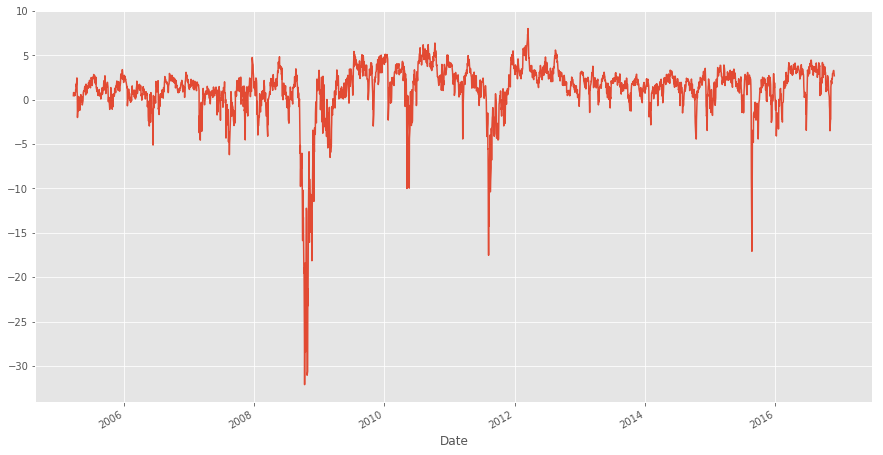

In [47]:
df_data.VIXCM30_Premium.plot()

In [48]:
run_ad_fuller(df_data.VIXCM30_Premium)

ADF Statistic: -6.546746
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


It is Stationary!

VIXCM60 Premium

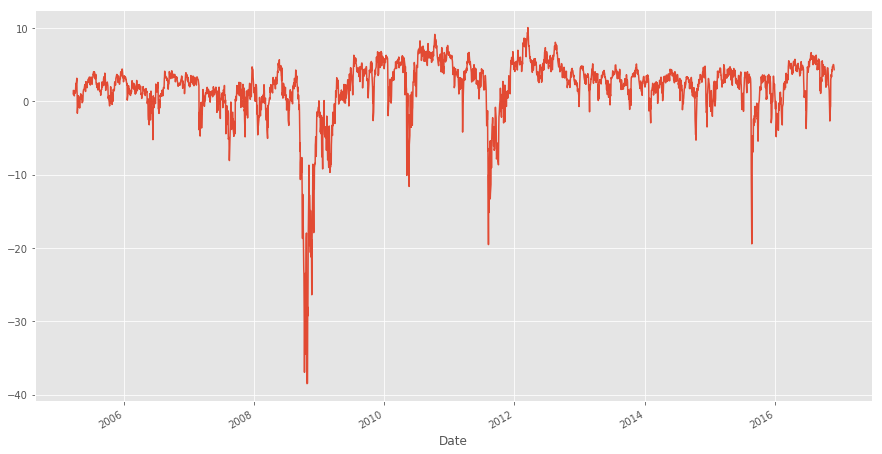

In [49]:
df_data.VIXCM60_Premium.plot()

In [50]:
run_ad_fuller(df_data.VIXCM60_Premium)

ADF Statistic: -5.490771
p-value: 0.000002
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


It is Stationary!

VIXCM90 Premium

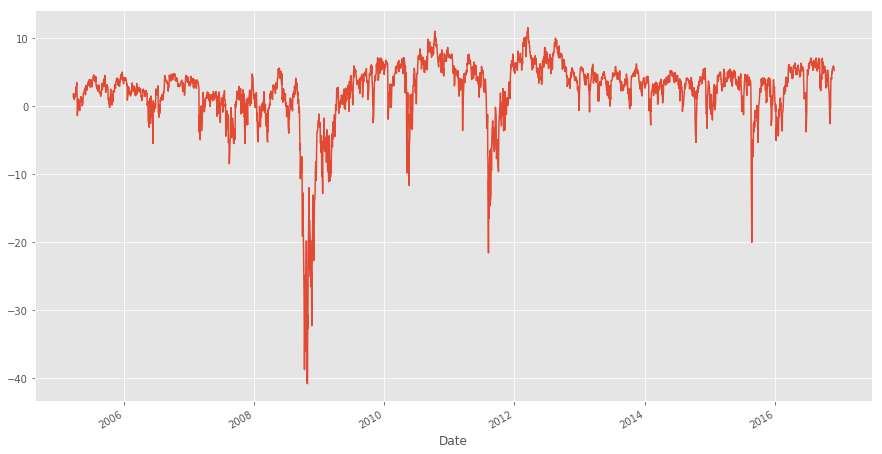

In [51]:
df_data.VIXCM90_Premium.plot()

In [52]:
run_ad_fuller(df_data.VIXCM90_Premium)

ADF Statistic: -5.085105
p-value: 0.000015
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


It is Stationary!

VIXCM120 Premium

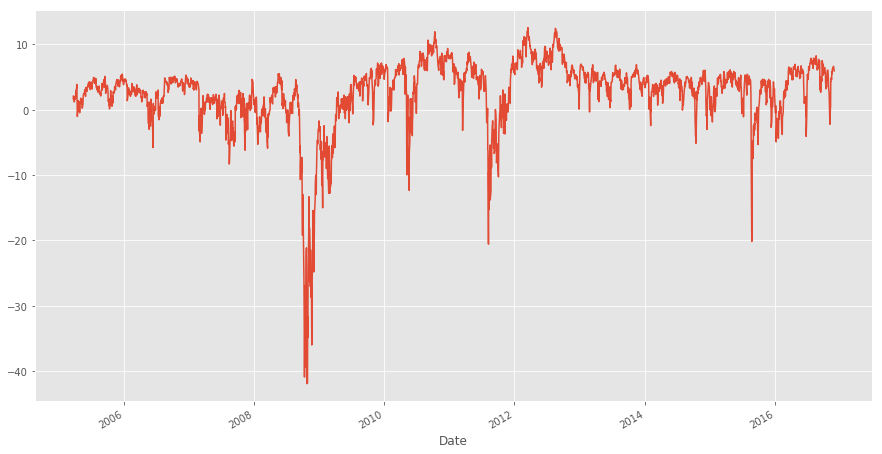

In [53]:
df_data.VIXCM120_Premium.plot()

In [54]:
run_ad_fuller(df_data.VIXCM120_Premium.dropna())

ADF Statistic: -4.742800
p-value: 0.000070
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


It is Stationary!

VIXCM150 Premium

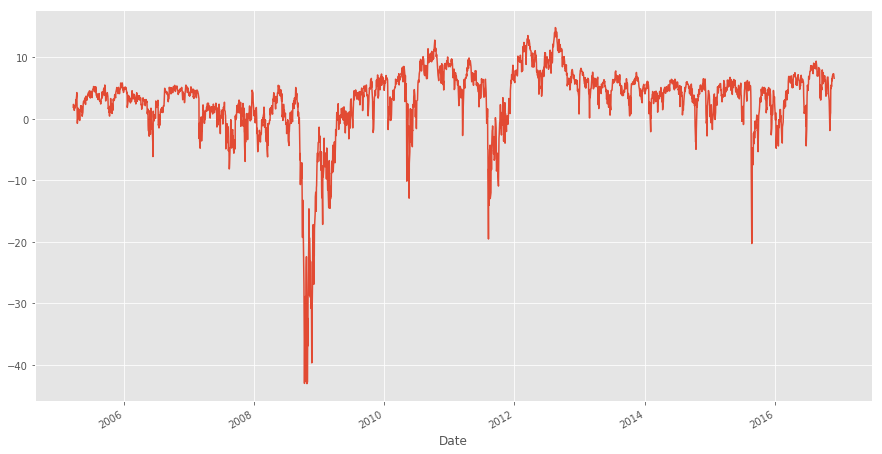

In [55]:
df_data.VIXCM150_Premium.plot()

In [56]:
run_ad_fuller(df_data.VIXCM150_Premium.dropna())

ADF Statistic: -4.555457
p-value: 0.000156
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


It is Stationary!

### <font color='#114B5F'><p style="text-align: center;"><a id='ar30-anchor'></a>VIXCM30 Premium</p></font>

#### AR Model for VIXCM30 Premium

First we will split the data into test and training data:

In [57]:
train,test = train_test_split(df_data, test_size=0.2, shuffle=False)
print('train: ',len(train))
print('test : ',len(test))
train.tail(5)

train:  2354
test :  589


SPY   RealVol    VIX    VIXCM30  VIXCM60    VIXCM90  \
Date                                                                     
2014-07-23  189.716544  3.895231  11.52  13.471053   14.396  15.210526   
2014-07-24  189.726090  3.964469  11.84  13.692105   14.578  15.310526   
2014-07-25  188.837875  5.437378  12.69  14.005263   14.806  15.476316   
2014-07-28  188.914283  6.551183  12.56  13.897368   14.726  15.368421   
2014-07-29  188.102462  6.450938  13.28  14.002632   14.700  15.331579   

             VIXCM120   VIXCM150   spy_ret      variance  VIXCM30_Premium  \
Date                                                                        
2014-07-23  15.990909  16.771292  0.002220  3.416250e-06         1.951053   
2014-07-24  16.072727  16.834928  0.000050  1.032740e-07         1.852105   
2014-07-25  16.211364  16.946411 -0.004682  2.553529e-05         1.315263   
2014-07-28  16.136364  16.904306  0.000405  1.085231e-09         1.337368   
2014-07-29  16.118182  16.904785 -0.004297  2.179938e-05         0.722632   

            VIXCM60_Premium  VIXCM90_Premium  VIXCM120_Premium  \
Date                                                             
2014-07-23            2.876         3.690526          4.470909   
2014-07-24            2.738         3.470526          4.232727   
2014-07-25            2.116         2.786316          3.521364   
2014-07-28            2.166         2.808421          3.576364   
2014-07-29            1.420         2.051579          2.838182   

            VIXCM150_Premium  
Date                          
2014-07-23          5.251292  
2014-07-24          4.994928  
2014-07-25          4.256411  
2014-07-28          4.344306  
2014-07-29          3.624785

Now we will look at the PACF plot of the premimums:

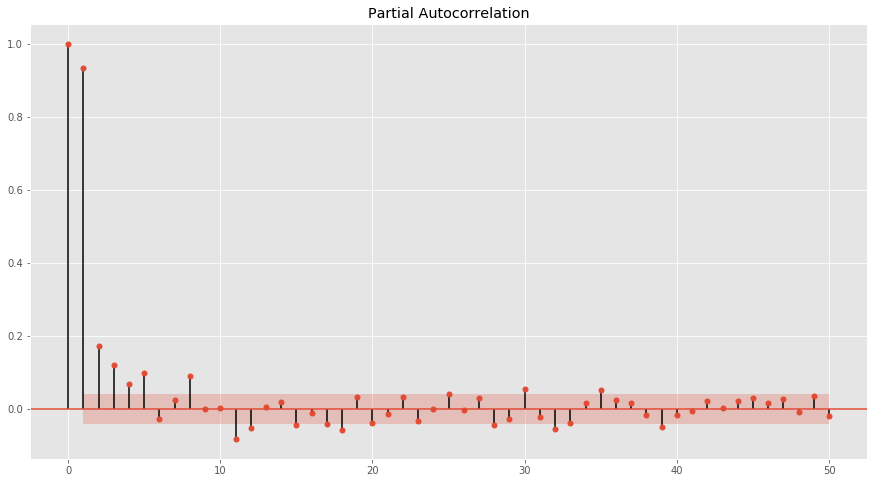

In [58]:
plot_pacf(train['VIXCM30_Premium'],lags=50)
plt.show()

In [59]:
# train autoregression
ar_model = AR(train['VIXCM30_Premium'])

Now we will check what order model is best from AIC and BIC scores:

In [60]:
aic = ar_model.select_order(maxlag=30,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=30,ic='bic',trend='nc')

In [61]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 30
model order (BIC): 8


Above we can see that the AIC score suggests 30 lags is the best, but this is the max lag we allowed it to use, so we will increase the max to see if it tells us something different.

In [62]:
aic = ar_model.select_order(maxlag=50,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=50,ic='bic',trend='nc')

In [63]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 49
model order (BIC): 8


We will try order =8 since it is the simplest model:

In [64]:
model_fit = ar_model.fit(maxlag=8)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 8
Coefficients: const                 0.040676
L1.VIXCM30_Premium    0.739705
L2.VIXCM30_Premium    0.066149
L3.VIXCM30_Premium    0.052504
L4.VIXCM30_Premium   -0.003647
L5.VIXCM30_Premium    0.110634
L6.VIXCM30_Premium   -0.049825
L7.VIXCM30_Premium   -0.042842
L8.VIXCM30_Premium    0.089621
dtype: float64


In [65]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.191782092547236


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [66]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test
lag:  10 | p_value: 0.0275 | still has information
lag:  11 | p_value: 0.0354 | still has information
lag:  12 | p_value: 0.0318 | still has information
lag:  13 | p_value: 0.0450 | still has information
lag:  14 | p_value: 0.0258 | still has information
lag:  15 | p_value: 0.0349 | still has information
lag:  16 | p_value: 0.0264 | still has information
lag:  17 | p_value: 0.0330 | still has information
lag:  18 | p_value: 0.0098 | still has information
lag:  19 | p_value: 0.0072 | still has information
lag:  20 | p_value: 0.0106 | still has information
lag:  21 | p_value: 0.0058 | still has information
lag:  22 | p_value: 0.0078 | still has information
lag:  23 | p_value: 0.0072 | still has information
lag:  24 | p_value: 0.0072 | still has information
lag:  25 | p_value: 0.0090 | still has information
lag:  26 | p_value: 0.0087 | still has information
lag:  27 | p_value: 0.0035 | still has information
lag:  28 | p_value: 0.0049 | still has information
lag:  29 | p_val

Now we will try order =49 to see if we can caputure this missing information:

In [67]:
model_fit = ar_model.fit(maxlag=49)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 49
Coefficients: const                  0.047729
L1.VIXCM30_Premium     0.734760
L2.VIXCM30_Premium     0.073003
L3.VIXCM30_Premium     0.054725
L4.VIXCM30_Premium     0.006517
L5.VIXCM30_Premium     0.089636
L6.VIXCM30_Premium    -0.042873
L7.VIXCM30_Premium    -0.024546
L8.VIXCM30_Premium     0.086363
L9.VIXCM30_Premium     0.006226
L10.VIXCM30_Premium    0.077364
L11.VIXCM30_Premium   -0.058672
L12.VIXCM30_Premium   -0.046534
L13.VIXCM30_Premium    0.010955
L14.VIXCM30_Premium    0.045101
L15.VIXCM30_Premium   -0.023944
L16.VIXCM30_Premium    0.019762
L17.VIXCM30_Premium   -0.010226
L18.VIXCM30_Premium   -0.065961
L19.VIXCM30_Premium    0.061991
L20.VIXCM30_Premium   -0.034029
L21.VIXCM30_Premium   -0.036764
L22.VIXCM30_Premium    0.041656
L23.VIXCM30_Premium   -0.023595
L24.VIXCM30_Premium   -0.014847
L25.VIXCM30_Premium    0.038173
L26.VIXCM30_Premium   -0.023949
L27.VIXCM30_Premium    0.057672
L28.VIXCM30_Premium   -0.028205
L29.VIXCM30_Premium   -0.055332
L30.VIXCM30_Premiu

In [68]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.1719350672913336


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [69]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test


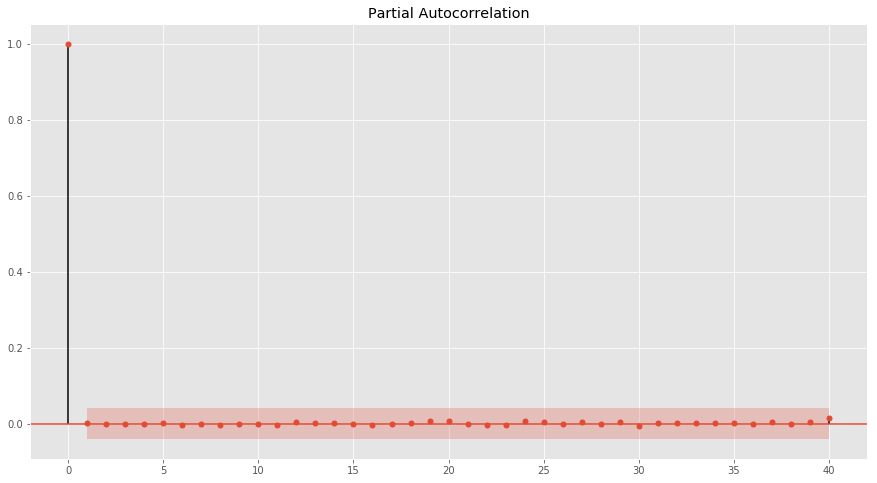

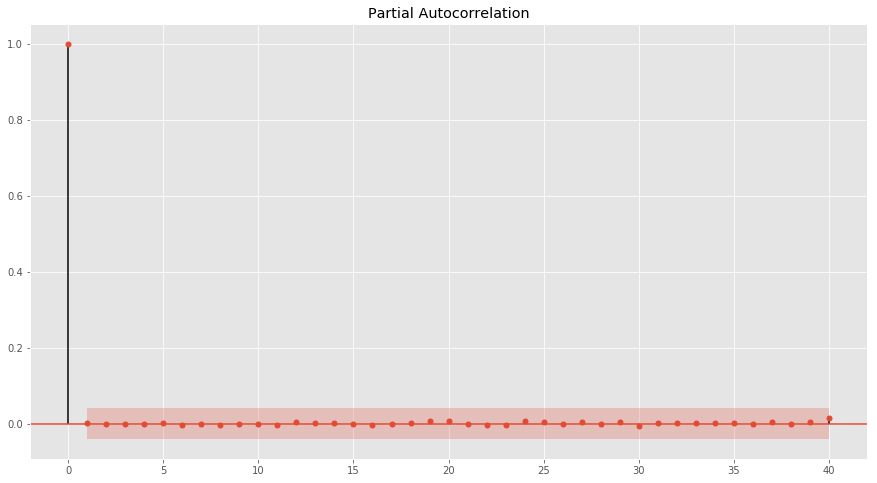

In [70]:
plot_pacf(model_fit.resid, lags=40) # PACF looks good

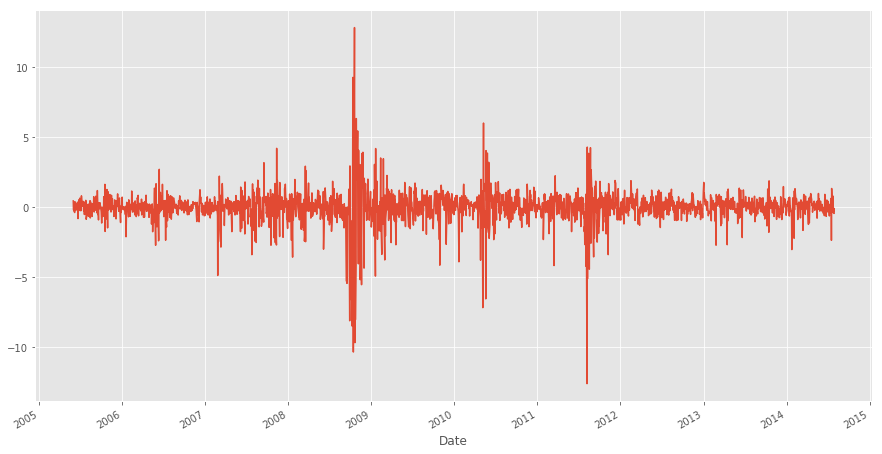

In [71]:
model_fit.resid.plot()

In [72]:
run_ad_fuller(model_fit.resid)

ADF Statistic: -47.950249
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


This model seems to caputure all the data so we will move forward.

Let's check to see how our model is performing on our test data:

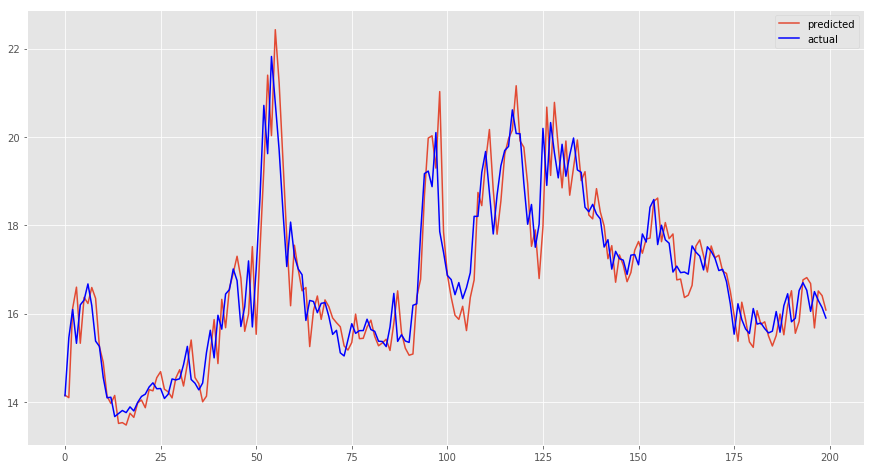

In [464]:
H = train['VIXCM30_Premium'].tolist()
AR_ORDER = 49
AR_prem = []
AR_PRED=[]
VIX = []
ACTUAL_FUTURE=[]
ACTUAL_prem = []
n = 0
for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 5)[0]
    AR_prem += [y_hat]
    AR_PRED+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM30_Premium']]
    ACTUAL_prem += [row['VIXCM30_Premium']]
    ACTUAL_FUTURE+=[row['VIXCM30']]
    n += 1

# plotting the first 200 points
plt.plot(AR_PRED[:200], label='predicted')
plt.plot(ACTUAL_FUTURE[:200], color='b', label='actual')
plt.legend()

Confusion Matrix
Raw
[[176 132]
 [160 120]]
Normalized
[[0.29931973 0.2244898 ]
 [0.27210884 0.20408163]]


{'cm': array([[176, 132],
        [160, 120]]), 'cm_norm': array([[0.29931973, 0.2244898 ],
        [0.27210884, 0.20408163]])}

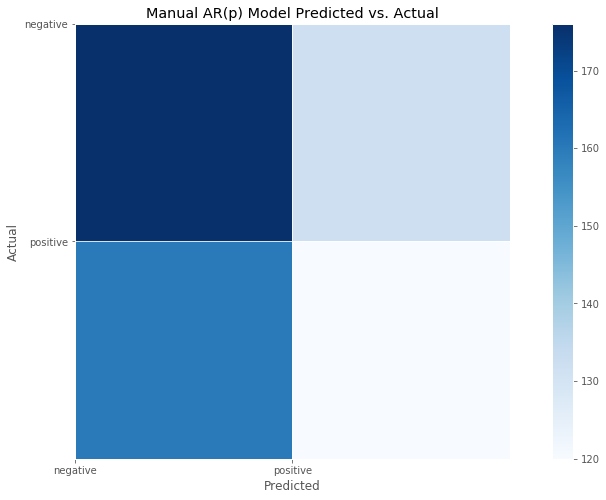

In [465]:
plot_confusion_matrix(ACTUAL_FUTURE, AR_PRED)

In [466]:
ar_error2 = measure_error(ACTUAL_FUTURE, AR_PRED, label='AR(49)')
print(ar_error2)

RMSE = 0.8488649610470695
RMSE_pcent = 0.048114657402919224
label = AR(49)
{'RMSE': 0.8488649610470695, 'RMSE_pcent': 0.048114657402919224, 'label': 'AR(49)'}


#### Check to see how much money could be made out of sample:

In [76]:
make_money(ACTUAL_FUTURE, AR_PRED)

Total profit or loss: 5.9271
Number of correct days: 298
total incorrect days: 290


### <font color='#114B5F'><p style="text-align: center;"><a id='ar60-anchor'></a>VIXCM60 Premium</p></font>

#### AR Model for VIXCM60 Premium

First we will look at the PACF plot of the premimums:

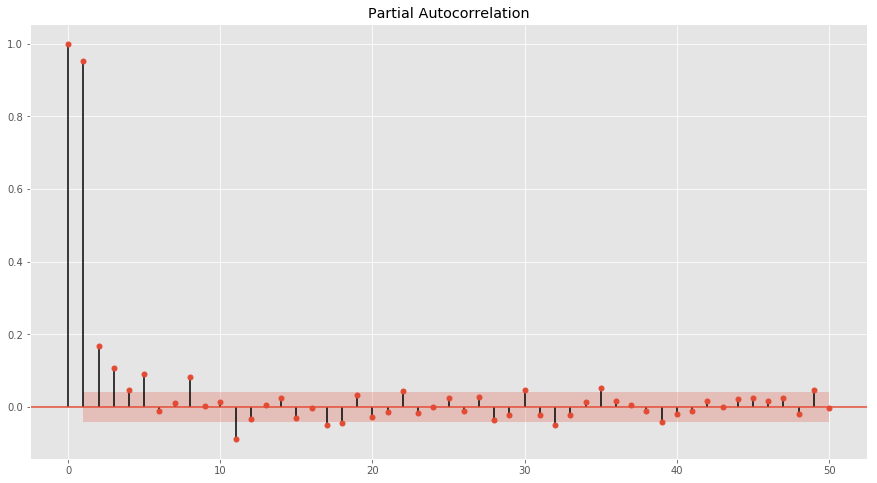

In [205]:
plot_pacf(train['VIXCM60_Premium'],lags=50)
plt.show()

In [206]:
# train autoregression
ar_model = AR(train['VIXCM60_Premium'])

Now we will check what order model is best from AIC and BIC scores:

In [207]:
aic = ar_model.select_order(maxlag=30,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=30,ic='bic',trend='nc')

In [208]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 30
model order (BIC): 5


Above we can see that the AIC score suggests 30 lags is the best, but this is the max lag we allowed it to use, so we will increase the max to see if it tells us something different.

In [209]:
aic = ar_model.select_order(maxlag=50,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=50,ic='bic',trend='nc')

In [210]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 35
model order (BIC): 5


We will try order =5 since it is the simplest model:

In [211]:
model_fit = ar_model.fit(maxlag=5)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 5
Coefficients: const                 0.053017
L1.VIXCM60_Premium    0.769673
L2.VIXCM60_Premium    0.070797
L3.VIXCM60_Premium    0.064153
L4.VIXCM60_Premium   -0.024588
L5.VIXCM60_Premium    0.089369
dtype: float64


In [212]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.3704552438612214


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [213]:
run_ljung_box(model_fit.resid, lags=40)

Ljung-Box Test
lag:  10 | p_value: 0.0001 | still has information
lag:  11 | p_value: 0.0002 | still has information
lag:  12 | p_value: 0.0002 | still has information
lag:  13 | p_value: 0.0004 | still has information
lag:  14 | p_value: 0.0002 | still has information
lag:  15 | p_value: 0.0004 | still has information
lag:  16 | p_value: 0.0002 | still has information
lag:  17 | p_value: 0.0003 | still has information
lag:  18 | p_value: 0.0001 | still has information
lag:  19 | p_value: 0.0001 | still has information
lag:  20 | p_value: 0.0002 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0001 | still has information
lag:  23 | p_value: 0.0001 | still has information
lag:  24 | p_value: 0.0001 | still has information
lag:  25 | p_value: 0.0002 | still has information
lag:  26 | p_value: 0.0002 | still has information
lag:  27 | p_value: 0.0001 | still has information
lag:  28 | p_value: 0.0001 | still has information
lag:  29 | p_val

Now we will try order = 35 to see if we can caputure this missing information:

In [214]:
model_fit = ar_model.fit(maxlag=35)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 35
Coefficients: const                  0.058063
L1.VIXCM60_Premium     0.770680
L2.VIXCM60_Premium     0.075459
L3.VIXCM60_Premium     0.058299
L4.VIXCM60_Premium    -0.020664
L5.VIXCM60_Premium     0.078253
L6.VIXCM60_Premium    -0.016905
L7.VIXCM60_Premium    -0.040313
L8.VIXCM60_Premium     0.073473
L9.VIXCM60_Premium     0.001452
L10.VIXCM60_Premium    0.092616
L11.VIXCM60_Premium   -0.074851
L12.VIXCM60_Premium   -0.030249
L13.VIXCM60_Premium   -0.005710
L14.VIXCM60_Premium    0.041038
L15.VIXCM60_Premium   -0.015750
L16.VIXCM60_Premium    0.033834
L17.VIXCM60_Premium   -0.022752
L18.VIXCM60_Premium   -0.054545
L19.VIXCM60_Premium    0.051477
L20.VIXCM60_Premium   -0.023131
L21.VIXCM60_Premium   -0.048491
L22.VIXCM60_Premium    0.049677
L23.VIXCM60_Premium   -0.005402
L24.VIXCM60_Premium   -0.010091
L25.VIXCM60_Premium    0.022448
L26.VIXCM60_Premium   -0.028361
L27.VIXCM60_Premium    0.051241
L28.VIXCM60_Premium   -0.018284
L29.VIXCM60_Premium   -0.052608
L30.VIXCM60_Premiu

In [215]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.350898393202161


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [216]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test


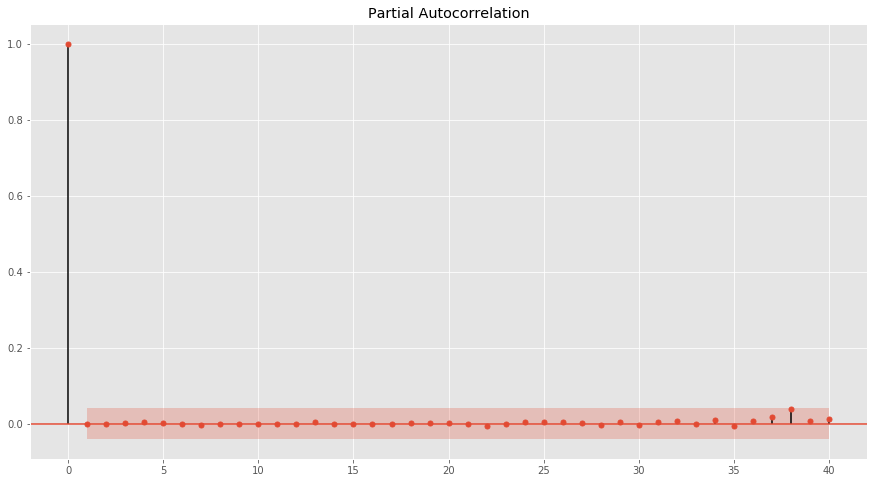

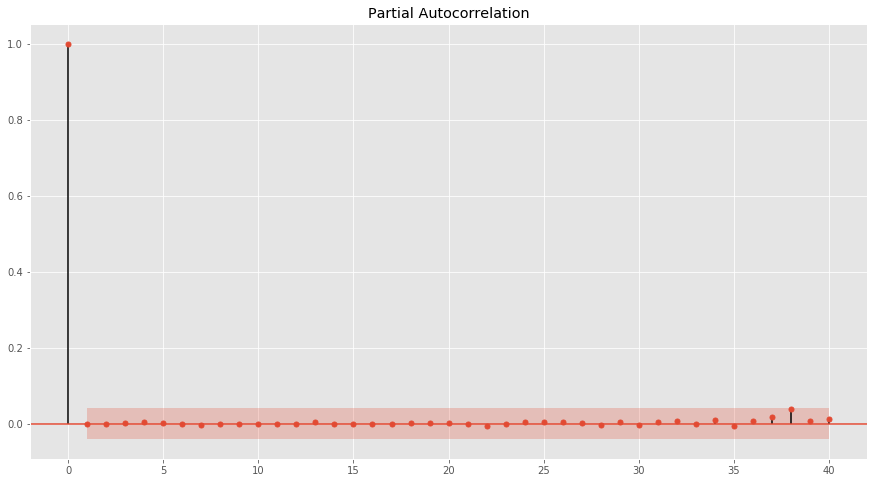

In [217]:
plot_pacf(model_fit.resid, lags=40) # PACF looks good

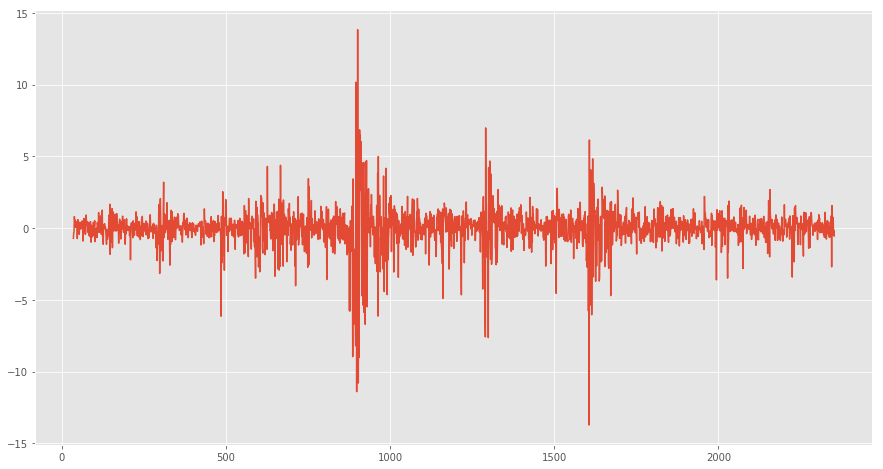

In [218]:
model_fit.resid.plot()

In [219]:
run_ad_fuller(model_fit.resid)

ADF Statistic: -48.165053
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


This model seems to caputure all the data so we will move forward.

Let's check to see how our model is performing on our test data:

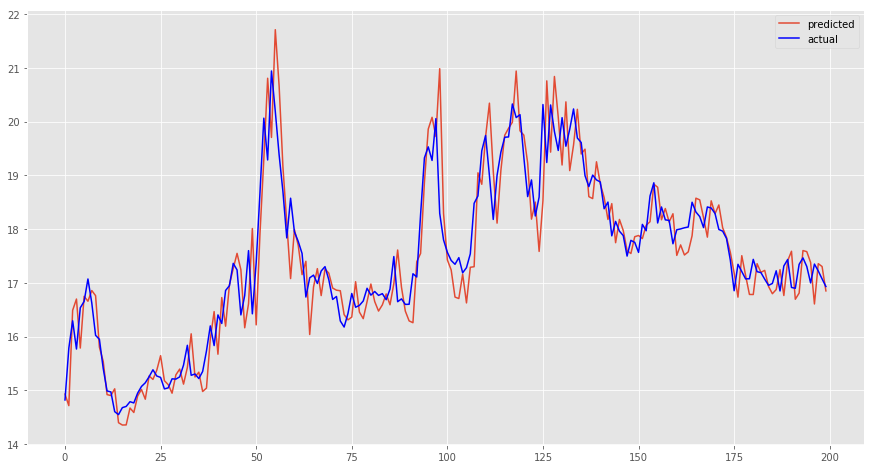

In [220]:
H = train['VIXCM60_Premium'].tolist()
AR_ORDER = 35
AR_prem1 = []
AR_PRED1=[]
VIX = []
ACTUAL_FUTURE1=[]
n = 0
for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]
ACTUAL_prem1 = []
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 5)[0]
    AR_prem1 += [y_hat]
    AR_PRED1+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM60_Premium']]
    ACTUAL_prem1 += [row['VIXCM60_Premium']]
    ACTUAL_FUTURE1+=[row['VIXCM60']]
    n += 1

# plotting the first 200 points
plt.plot(AR_PRED1[:200], label='predicted')
plt.plot(ACTUAL_FUTURE1[:200], color='b', label='actual')
plt.legend()

Confusion Matrix
Raw
[[169 132]
 [165 122]]
Normalized
[[0.28741497 0.2244898 ]
 [0.28061224 0.20748299]]


{'cm': array([[169, 132],
        [165, 122]]), 'cm_norm': array([[0.28741497, 0.2244898 ],
        [0.28061224, 0.20748299]])}

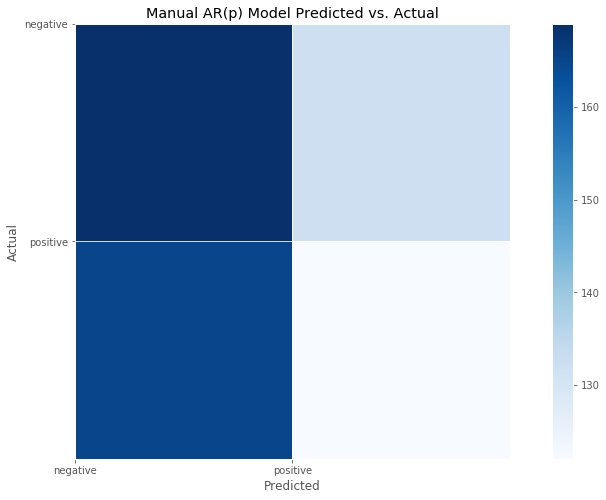

In [221]:
plot_confusion_matrix(ACTUAL_FUTURE1, AR_PRED1)

In [222]:
ar_error2 = measure_error(ACTUAL_FUTURE1, AR_PRED1, label='AR(35)')
print(ar_error2)

RMSE = 0.6675266219320293
RMSE_pcent = 0.036184144108954146
label = AR(35)
{'RMSE': 0.6675266219320293, 'RMSE_pcent': 0.036184144108954146, 'label': 'AR(35)'}


#### Check to see how much money could be made out of sample:

In [223]:
make_money(ACTUAL_FUTURE1,AR_PRED1)

Total profit or loss: 0.9495
Number of correct days: 291
total incorrect days: 297


### <font color='#114B5F'><p style="text-align: center;"><a id='ar90-anchor'></a>VIXCM90 Premium</p></font>

#### AR Model for VIXCM90 Premium

Now we will look at the PACF plot of the premimums:

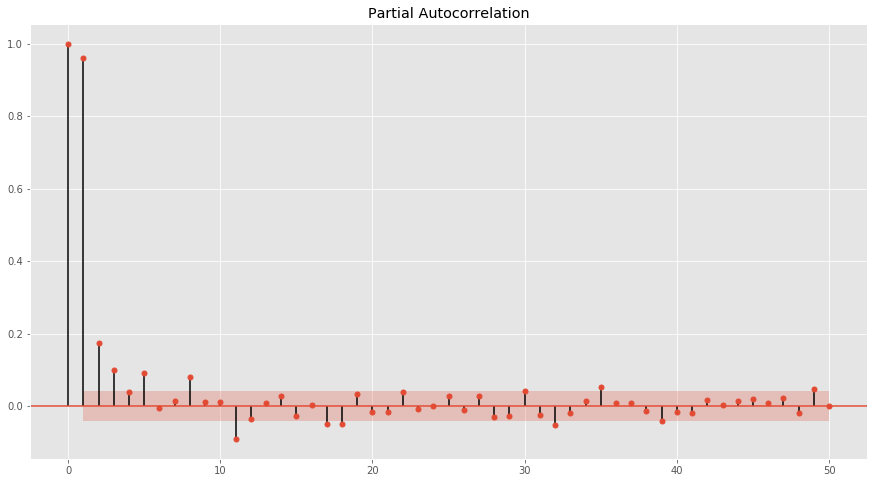

In [224]:
plot_pacf(train['VIXCM90_Premium'],lags=50)
plt.show()

In [225]:
# train autoregression
ar_model = AR(train['VIXCM90_Premium'])

Now we will check what order model is best from AIC and BIC scores:

In [226]:
aic = ar_model.select_order(maxlag=30,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=30,ic='bic',trend='nc')

In [227]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 30
model order (BIC): 5


Above we can see that the AIC score suggests 30 lags is the best, but this is the max lag we allowed it to use, so we will increase the max to see if it tells us something different.

In [228]:
aic = ar_model.select_order(maxlag=50,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=50,ic='bic',trend='nc')

In [229]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 35
model order (BIC): 5


We will try order = 5 since it is the simplest model:

In [230]:
model_fit = ar_model.fit(maxlag=5)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 5
Coefficients: const                 0.055619
L1.VIXCM90_Premium    0.769776
L2.VIXCM90_Premium    0.086111
L3.VIXCM90_Premium    0.058301
L4.VIXCM90_Premium   -0.030630
L5.VIXCM90_Premium    0.090508
dtype: float64


In [231]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.4572788232492344


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [232]:
run_ljung_box(model_fit.resid, lags=40)

Ljung-Box Test
lag:  10 | p_value: 0.0001 | still has information
lag:  11 | p_value: 0.0001 | still has information
lag:  12 | p_value: 0.0001 | still has information
lag:  13 | p_value: 0.0002 | still has information
lag:  14 | p_value: 0.0002 | still has information
lag:  15 | p_value: 0.0003 | still has information
lag:  16 | p_value: 0.0001 | still has information
lag:  17 | p_value: 0.0001 | still has information
lag:  18 | p_value: 0.0001 | still has information
lag:  19 | p_value: 0.0001 | still has information
lag:  20 | p_value: 0.0001 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0001 | still has information
lag:  23 | p_value: 0.0001 | still has information
lag:  24 | p_value: 0.0001 | still has information
lag:  25 | p_value: 0.0001 | still has information
lag:  26 | p_value: 0.0002 | still has information
lag:  27 | p_value: 0.0001 | still has information
lag:  28 | p_value: 0.0001 | still has information
lag:  29 | p_val

Now we will try order = 35 to see if we can caputure this missing information:

In [233]:
model_fit = ar_model.fit(maxlag=35)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 35
Coefficients: const                  0.058823
L1.VIXCM90_Premium     0.768462
L2.VIXCM90_Premium     0.092559
L3.VIXCM90_Premium     0.053360
L4.VIXCM90_Premium    -0.026933
L5.VIXCM90_Premium     0.077405
L6.VIXCM90_Premium    -0.020206
L7.VIXCM90_Premium    -0.037089
L8.VIXCM90_Premium     0.069401
L9.VIXCM90_Premium     0.012646
L10.VIXCM90_Premium    0.089986
L11.VIXCM90_Premium   -0.076410
L12.VIXCM90_Premium   -0.035494
L13.VIXCM90_Premium   -0.006018
L14.VIXCM90_Premium    0.041574
L15.VIXCM90_Premium   -0.017509
L16.VIXCM90_Premium    0.042083
L17.VIXCM90_Premium   -0.021666
L18.VIXCM90_Premium   -0.061964
L19.VIXCM90_Premium    0.046902
L20.VIXCM90_Premium   -0.013907
L21.VIXCM90_Premium   -0.046341
L22.VIXCM90_Premium    0.040027
L23.VIXCM90_Premium    0.002175
L24.VIXCM90_Premium   -0.013742
L25.VIXCM90_Premium    0.025134
L26.VIXCM90_Premium   -0.027931
L27.VIXCM90_Premium    0.050044
L28.VIXCM90_Premium   -0.010551
L29.VIXCM90_Premium   -0.052993
L30.VIXCM90_Premiu

In [234]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.4367561404498372


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [235]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test


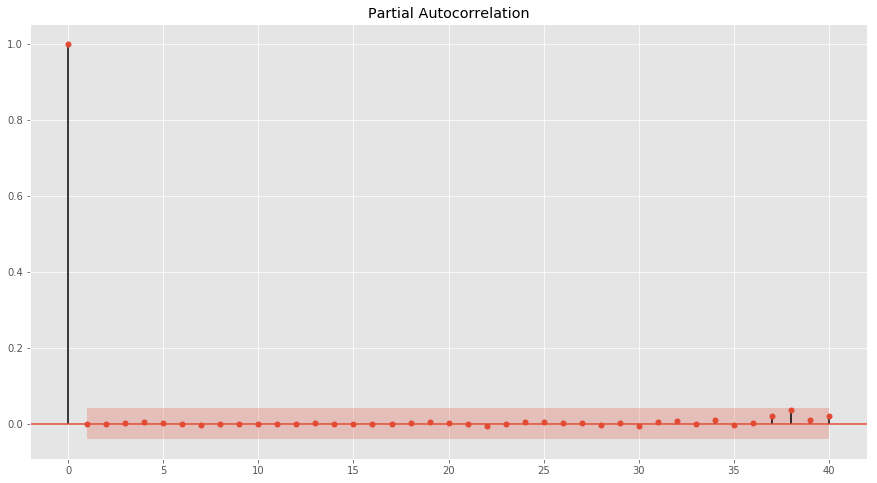

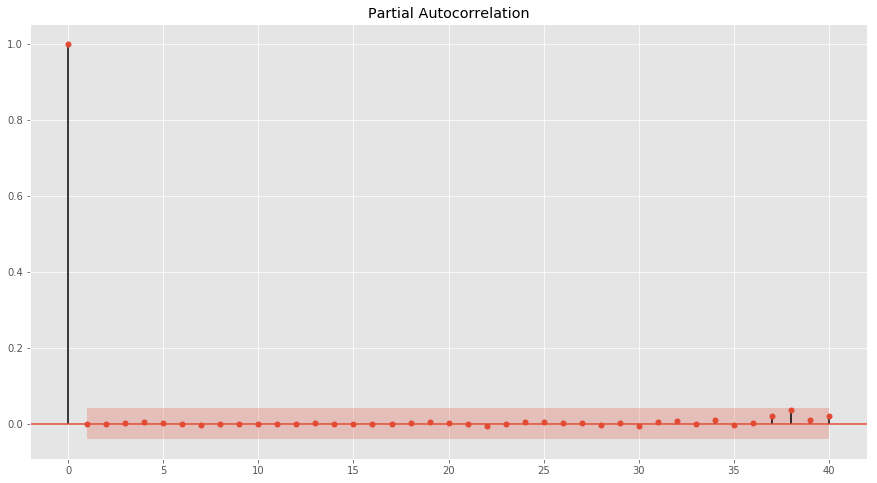

In [236]:
plot_pacf(model_fit.resid, lags=40) # PACF looks good

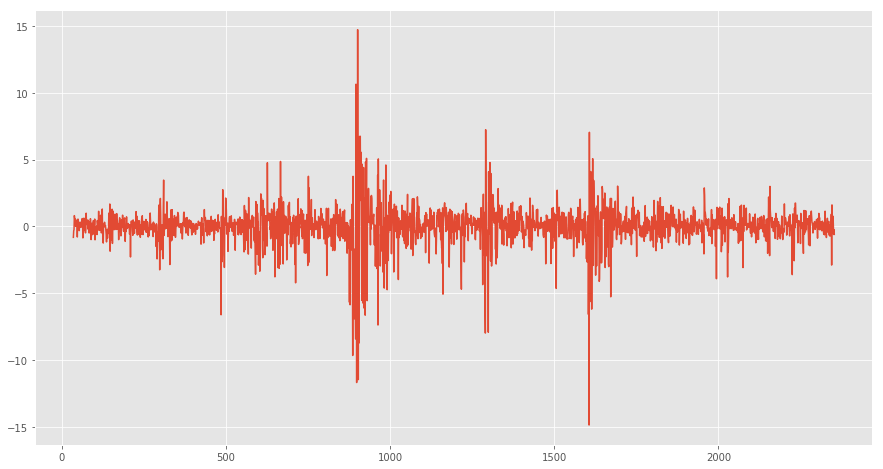

In [237]:
model_fit.resid.plot()

In [238]:
run_ad_fuller(model_fit.resid)

ADF Statistic: -48.148136
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


This model seems to caputure all the data so we will move forward.

Let's check to see how our model is performing on our test data:

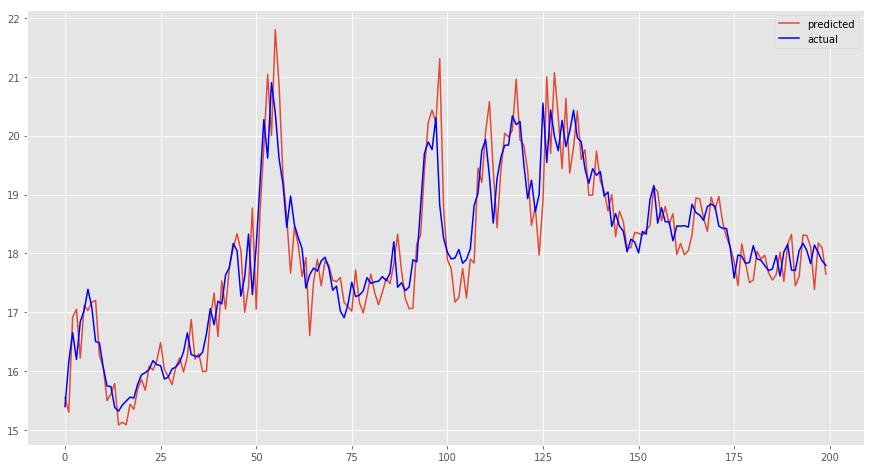

In [239]:
H = train['VIXCM90_Premium'].tolist()
AR_ORDER = 35
AR_prem2 = []
AR_PRED2=[]
VIX = []
ACTUAL_FUTURE2=[]
n = 0
for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]
ACTUAL_prem2 = []
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 5)[0]
    AR_prem2 += [y_hat]
    AR_PRED2+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM90_Premium']]
    ACTUAL_prem2 += [row['VIXCM90_Premium']]
    ACTUAL_FUTURE2+=[row['VIXCM90']]
    n += 1

# plotting the first 200 points
plt.plot(AR_PRED2[:200], label='predicted')
plt.plot(ACTUAL_FUTURE2[:200], color='b', label='actual')
plt.legend()

Confusion Matrix
Raw
[[160 134]
 [168 126]]
Normalized
[[0.27210884 0.22789116]
 [0.28571429 0.21428571]]


{'cm': array([[160, 134],
        [168, 126]]), 'cm_norm': array([[0.27210884, 0.22789116],
        [0.28571429, 0.21428571]])}

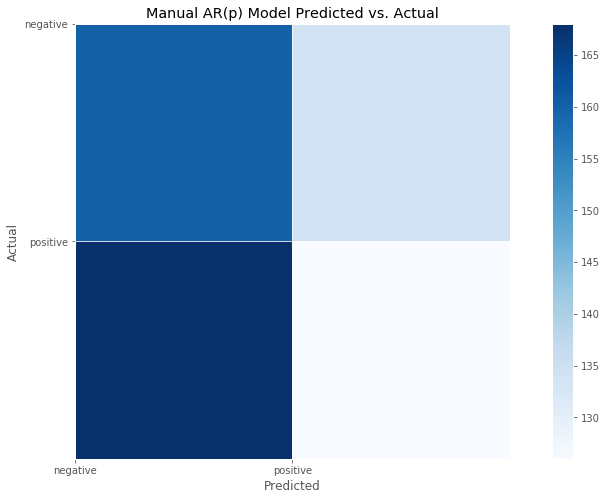

In [240]:
plot_confusion_matrix(ACTUAL_FUTURE2, AR_PRED2)

In [241]:
ar_error2 = measure_error(ACTUAL_FUTURE2, AR_PRED2, label='AR(35)')
print(ar_error2)

RMSE = 0.6043100435289301
RMSE_pcent = 0.031809285219358684
label = AR(35)
{'RMSE': 0.6043100435289301, 'RMSE_pcent': 0.031809285219358684, 'label': 'AR(35)'}


#### Check to see how much money could be made out of sample:

In [242]:
make_money(ACTUAL_FUTURE2, AR_PRED2)

Total profit or loss: 2.9856
Number of correct days: 286
total incorrect days: 302


### <font color='#114B5F'><p style="text-align: center;"><a id='ar120-anchor'></a>VIXCM120 Premium</p></font>

#### VIXCM120 Premium

First we will look at the PACF plot of the premimums:

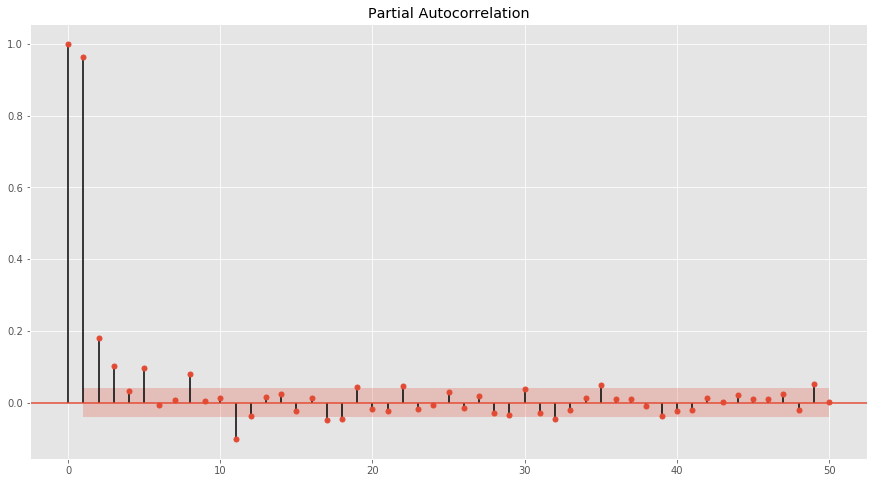

In [262]:
plot_pacf(train['VIXCM120_Premium'],lags=50)
plt.show()

In [263]:
# train autoregression
ar_model = AR(train['VIXCM120_Premium'])

Now we will check what order model is best from AIC and BIC scores:

In [264]:
aic = ar_model.select_order(maxlag=30,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=30,ic='bic',trend='nc')

In [265]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 30
model order (BIC): 5


Above we can see that the AIC score suggests 30 lags is the best, but this is the max lag we allowed it to use, so we will increase the max to see if it tells us something different.

In [266]:
aic = ar_model.select_order(maxlag=50,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=50,ic='bic',trend='nc')

In [267]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 35
model order (BIC): 5


We will try order = 5 since it is the simplest model:

In [268]:
model_fit = ar_model.fit(maxlag=5)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 5
Coefficients: const                  0.058267
L1.VIXCM120_Premium    0.766850
L2.VIXCM120_Premium    0.089744
L3.VIXCM120_Premium    0.064586
L4.VIXCM120_Premium   -0.040856
L5.VIXCM120_Premium    0.096360
dtype: float64


In [250]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.5162838219095407


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [251]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0000 | still has information
lag:  12 | p_value: 0.0000 | still has information
lag:  13 | p_value: 0.0001 | still has information
lag:  14 | p_value: 0.0001 | still has information
lag:  15 | p_value: 0.0001 | still has information
lag:  16 | p_value: 0.0000 | still has information
lag:  17 | p_value: 0.0000 | still has information
lag:  18 | p_value: 0.0000 | still has information
lag:  19 | p_value: 0.0000 | still has information
lag:  20 | p_value: 0.0000 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0000 | still has information
lag:  23 | p_value: 0.0000 | still has information
lag:  24 | p_value: 0.0000 | still has information
lag:  25 | p_value: 0.0000 | still has information
lag:  26 | p_value: 0.0000 | still has information
lag:  27 | p_value: 0.0000 | still has information
lag:  28 | p_value: 0.0000 | still has information
lag:  29 | p_val

Now we will try order = 35 to see if we can caputure this missing information:

In [252]:
model_fit = ar_model.fit(maxlag=35)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 35
Coefficients: const                   0.062413
L1.VIXCM120_Premium     0.768963
L2.VIXCM120_Premium     0.095499
L3.VIXCM120_Premium     0.056335
L4.VIXCM120_Premium    -0.033309
L5.VIXCM120_Premium     0.083427
L6.VIXCM120_Premium    -0.015385
L7.VIXCM120_Premium    -0.042856
L8.VIXCM120_Premium     0.070788
L9.VIXCM120_Premium     0.005830
L10.VIXCM120_Premium    0.099565
L11.VIXCM120_Premium   -0.087578
L12.VIXCM120_Premium   -0.040525
L13.VIXCM120_Premium    0.003309
L14.VIXCM120_Premium    0.032214
L15.VIXCM120_Premium   -0.019641
L16.VIXCM120_Premium    0.051833
L17.VIXCM120_Premium   -0.025325
L18.VIXCM120_Premium   -0.063755
L19.VIXCM120_Premium    0.058128
L20.VIXCM120_Premium   -0.012063
L21.VIXCM120_Premium   -0.054492
L22.VIXCM120_Premium    0.052034
L23.VIXCM120_Premium   -0.002868
L24.VIXCM120_Premium   -0.017726
L25.VIXCM120_Premium    0.027768
L26.VIXCM120_Premium   -0.022699
L27.VIXCM120_Premium    0.039281
L28.VIXCM120_Premium   -0.000798
L29.VIXCM120_Premium 

In [253]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.4936875650982426


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [254]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test


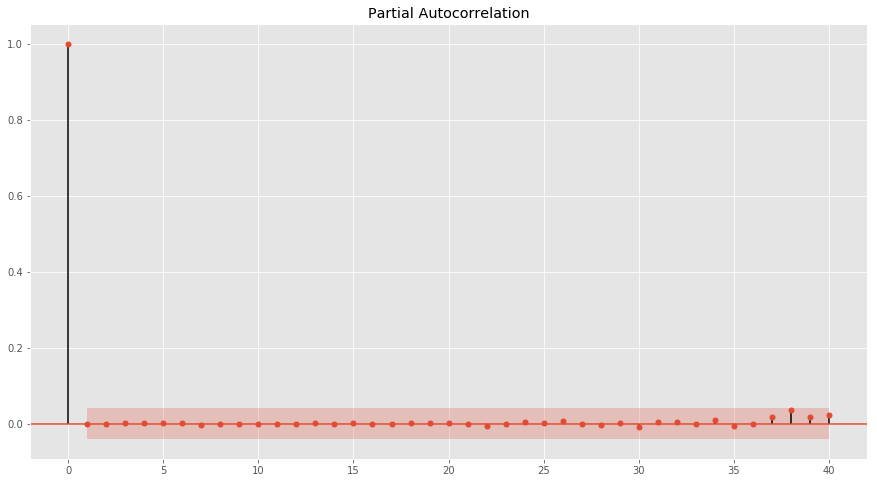

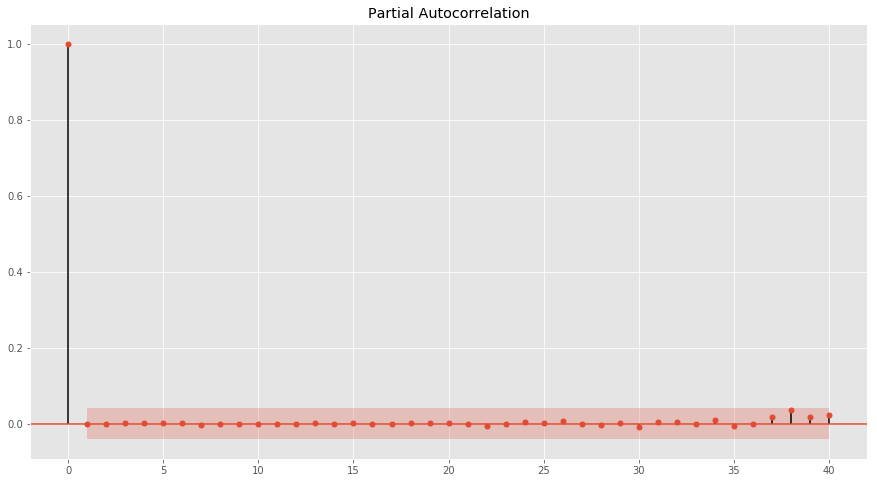

In [255]:
plot_pacf(model_fit.resid, lags=40) # PACF looks good

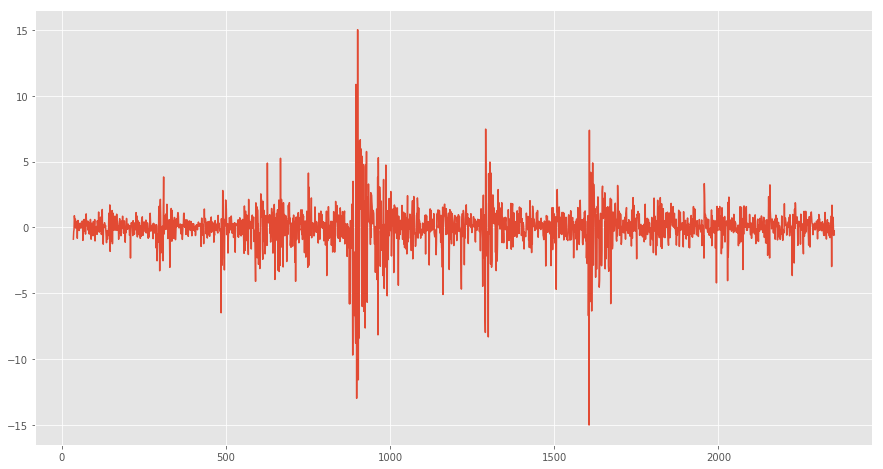

In [256]:
model_fit.resid.plot()

In [257]:
run_ad_fuller(model_fit.resid)

ADF Statistic: -48.151979
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


This model seems to caputure all the data so we will move forward.

Let's check to see how our model is performing on our test data:

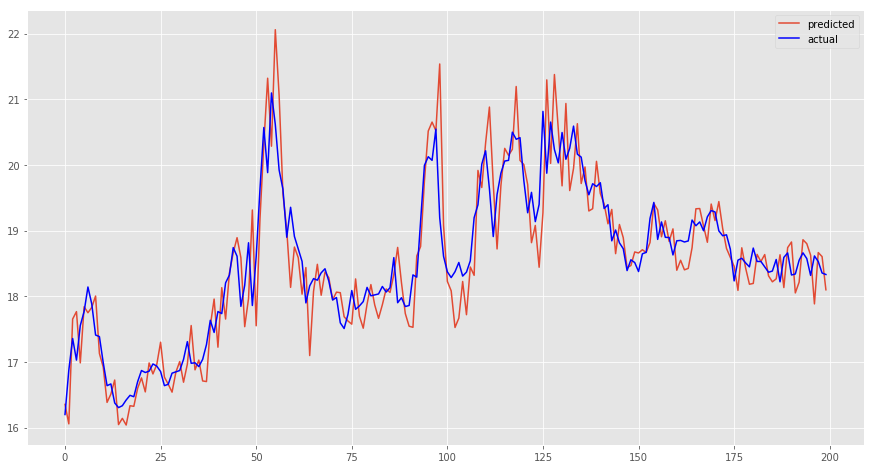

In [258]:
H = train['VIXCM120_Premium'].tolist()
AR_ORDER = 35
AR_prem3 = []
AR_PRED3=[]
VIX = []
ACTUAL_FUTURE3=[]
n = 0
for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]
ACTUAL_prem3 = []
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 5)[0]
    AR_prem3 += [y_hat]
    AR_PRED3+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM120_Premium']]
    ACTUAL_prem3 += [row['VIXCM120_Premium']]
    ACTUAL_FUTURE3+=[row['VIXCM120']]
    n += 1

# plotting the first 200 points
plt.plot(AR_PRED3[:200], label='predicted')
plt.plot(ACTUAL_FUTURE3[:200], color='b', label='actual')
plt.legend()

Confusion Matrix
Raw
[[154 132]
 [173 129]]
Normalized
[[0.26190476 0.2244898 ]
 [0.29421769 0.21938776]]


{'cm': array([[154, 132],
        [173, 129]]), 'cm_norm': array([[0.26190476, 0.2244898 ],
        [0.29421769, 0.21938776]])}

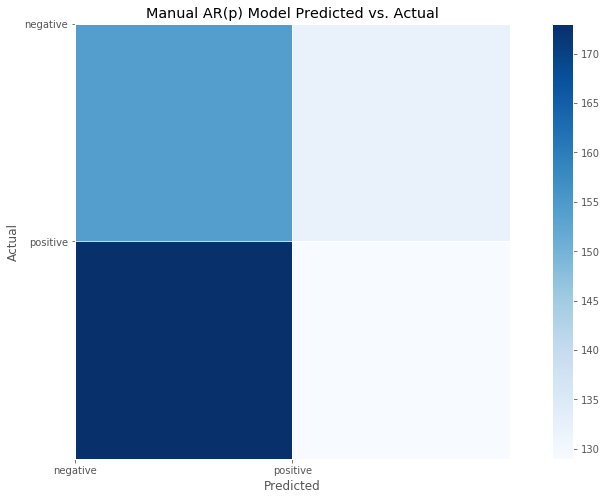

In [259]:
plot_confusion_matrix(ACTUAL_FUTURE3, AR_PRED3)

In [260]:
ar_error2 = measure_error(ACTUAL_FUTURE3, AR_PRED3, label='AR(35)')
print(ar_error2)

RMSE = 0.5713382942295682
RMSE_pcent = 0.029363389373415195
label = AR(35)
{'RMSE': 0.5713382942295682, 'RMSE_pcent': 0.029363389373415195, 'label': 'AR(35)'}


#### Check to see how much money could be made out of sample:

In [261]:
make_money(ACTUAL_FUTURE3, AR_PRED3)

Total profit or loss: 4.7723
Number of correct days: 283
total incorrect days: 305


### <font color='#114B5F'><p style="text-align: center;"><a id='ar150-anchor'></a>VIXCM150 Premium</p></font>

#### VIXCM150 Premium

First we will look at the PACF plot of the premimums:

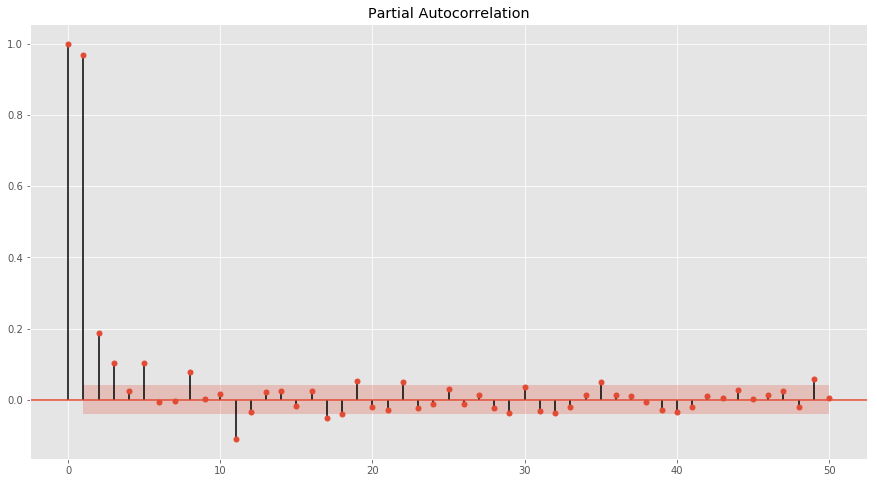

In [274]:
plot_pacf(train['VIXCM150_Premium'],lags=50)
plt.show()

In [275]:
# train autoregression
ar_model = AR(train['VIXCM150_Premium'])

Now we will check what order model is best from AIC and BIC scores:

In [276]:
aic = ar_model.select_order(maxlag=30,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=30,ic='bic',trend='nc')

In [277]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 30
model order (BIC): 5


Above we can see that the AIC score suggests 30 lags is the best, but this is the max lag we allowed it to use, so we will increase the max to see if it tells us something different.

In [278]:
aic = ar_model.select_order(maxlag=50,ic='aic',trend='nc')
bic = ar_model.select_order(maxlag=50,ic='bic',trend='nc')

In [279]:
print('model order (AIC): %d' % aic)
print('model order (BIC): %d' % bic)

model order (AIC): 49
model order (BIC): 11


We will try order = 11 since it is the simplest model:

In [305]:
model_fit = ar_model.fit(maxlag=11)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 11
Coefficients: const                   0.061096
L1.VIXCM150_Premium     0.767740
L2.VIXCM150_Premium     0.091239
L3.VIXCM150_Premium     0.072728
L4.VIXCM150_Premium    -0.054116
L5.VIXCM150_Premium     0.098360
L6.VIXCM150_Premium    -0.000875
L7.VIXCM150_Premium    -0.067692
L8.VIXCM150_Premium     0.080361
L9.VIXCM150_Premium    -0.000225
L10.VIXCM150_Premium    0.099617
L11.VIXCM150_Premium   -0.108832
dtype: float64


In [306]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.5721360055497136


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [307]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test
lag:  30 | p_value: 0.0346 | still has information
lag:  31 | p_value: 0.0362 | still has information
lag:  32 | p_value: 0.0466 | still has information
lag:  34 | p_value: 0.0090 | still has information
lag:  35 | p_value: 0.0120 | still has information
lag:  36 | p_value: 0.0143 | still has information
lag:  37 | p_value: 0.0186 | still has information
lag:  38 | p_value: 0.0093 | still has information
lag:  39 | p_value: 0.0101 | still has information
lag:  40 | p_value: 0.0130 | still has information
lag:  41 | p_value: 0.0155 | still has information
lag:  42 | p_value: 0.0184 | still has information
lag:  43 | p_value: 0.0092 | still has information
lag:  44 | p_value: 0.0118 | still has information
lag:  45 | p_value: 0.0120 | still has information
lag:  46 | p_value: 0.0142 | still has information
lag:  47 | p_value: 0.0132 | still has information
lag:  48 | p_value: 0.0010 | still has information
lag:  49 | p_value: 0.0014 | still has information
lag:  50 | p_val

Now we will try order = 49 to see if we can caputure this missing information:

In [308]:
model_fit = ar_model.fit(maxlag=49)
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
intercept = model_fit.params[0]
coeff = list(model_fit.params)[1:] # drop the intercept
coeff.reverse()

Lag: 49
Coefficients: const                   0.061411
L1.VIXCM150_Premium     0.769016
L2.VIXCM150_Premium     0.096952
L3.VIXCM150_Premium     0.062871
L4.VIXCM150_Premium    -0.037810
L5.VIXCM150_Premium     0.087700
L6.VIXCM150_Premium    -0.010294
L7.VIXCM150_Premium    -0.053452
L8.VIXCM150_Premium     0.072443
L9.VIXCM150_Premium     0.000395
L10.VIXCM150_Premium    0.108985
L11.VIXCM150_Premium   -0.098503
L12.VIXCM150_Premium   -0.045901
L13.VIXCM150_Premium    0.011974
L14.VIXCM150_Premium    0.023194
L15.VIXCM150_Premium   -0.017758
L16.VIXCM150_Premium    0.063046
L17.VIXCM150_Premium   -0.032031
L18.VIXCM150_Premium   -0.062360
L19.VIXCM150_Premium    0.062948
L20.VIXCM150_Premium   -0.006435
L21.VIXCM150_Premium   -0.060082
L22.VIXCM150_Premium    0.056023
L23.VIXCM150_Premium   -0.002980
L24.VIXCM150_Premium   -0.024719
L25.VIXCM150_Premium    0.030095
L26.VIXCM150_Premium   -0.012988
L27.VIXCM150_Premium    0.026033
L28.VIXCM150_Premium    0.001659
L29.VIXCM150_Premium 

In [309]:
print('RMSE (in sample):',np.sqrt(np.mean(model_fit.sigma2)))

RMSE (in sample): 1.5569022259180805


We will check to make sure that there is no information left in the residuals and that they are stationary:

In [310]:
run_ljung_box(model_fit.resid, lags=100)

Ljung-Box Test


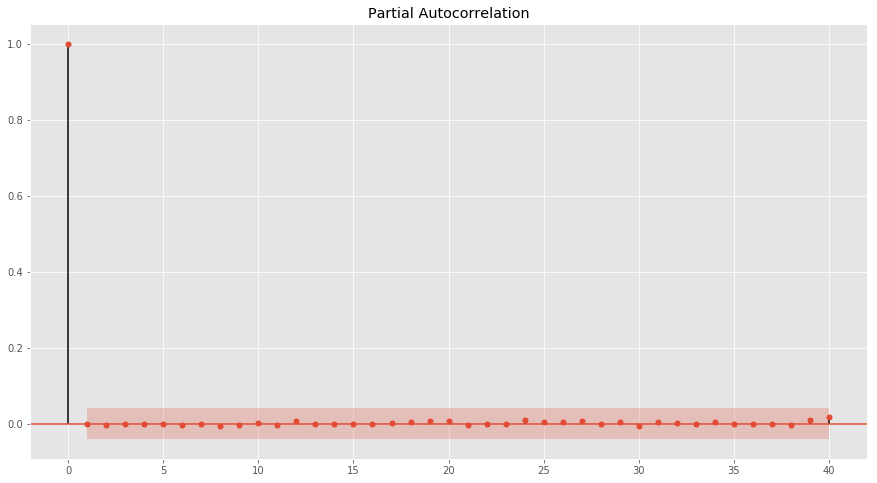

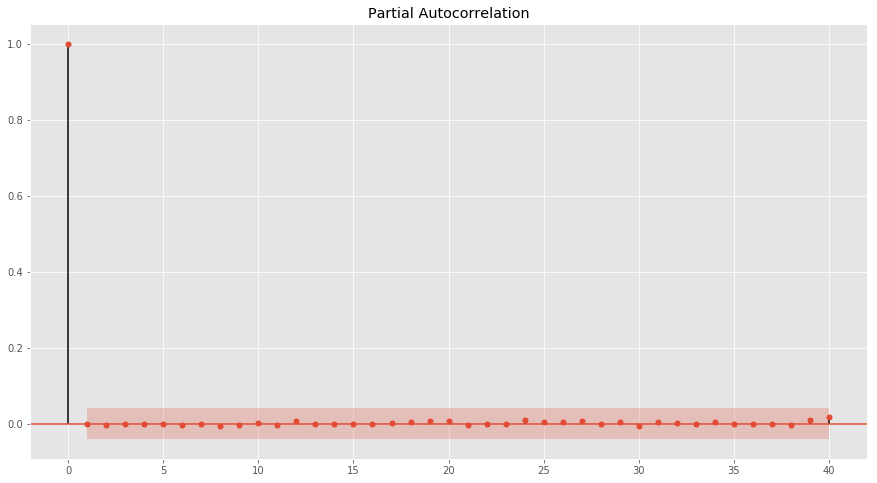

In [311]:
plot_pacf(model_fit.resid, lags=40) # PACF looks good

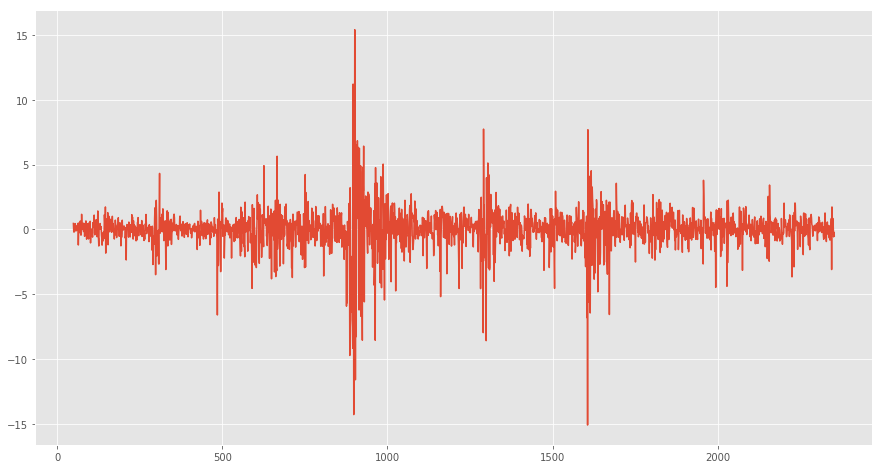

In [312]:
model_fit.resid.plot()

In [313]:
run_ad_fuller(model_fit.resid)

ADF Statistic: -47.991732
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

We reject the Null Hypothesis (H0) -- the time series is stationary


This model seems to caputure all the data so we will move forward.

Let's check to see how our model is performing on our test data:

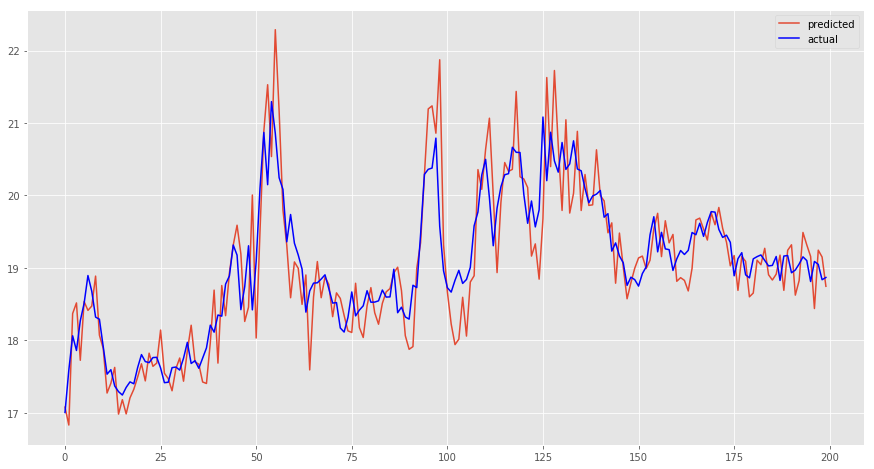

In [314]:
H = train['VIXCM150_Premium'].tolist()
AR_ORDER = 49
AR_prem4 = []
AR_PRED4=[]
VIX = []
ACTUAL_FUTURE4=[]
n = 0
for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]
ACTUAL_prem4 = []
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 5)[0]
    AR_prem4 += [y_hat]
    AR_PRED4+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM150_Premium']]
    ACTUAL_prem4 += [row['VIXCM150_Premium']]
    ACTUAL_FUTURE4+=[row['VIXCM150']]
    n += 1

# plotting the first 200 points
plt.plot(AR_PRED4[:200], label='predicted')
plt.plot(ACTUAL_FUTURE4[:200], color='b', label='actual')
plt.legend()

Confusion Matrix
Raw
[[153 135]
 [159 141]]
Normalized
[[0.26020408 0.22959184]
 [0.27040816 0.23979592]]


{'cm': array([[153, 135],
        [159, 141]]), 'cm_norm': array([[0.26020408, 0.22959184],
        [0.27040816, 0.23979592]])}

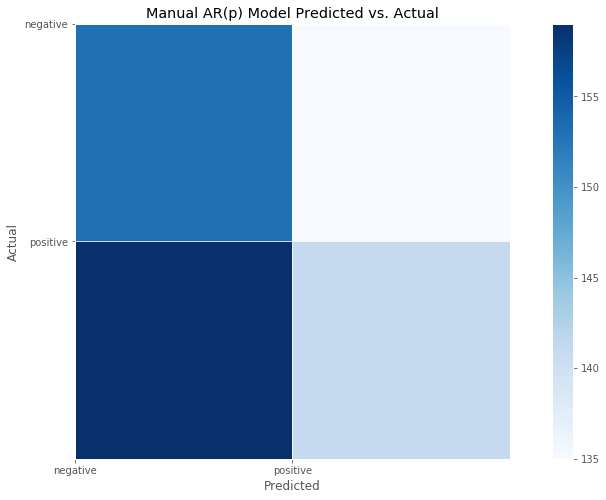

In [315]:
plot_confusion_matrix(ACTUAL_FUTURE4, AR_PRED4)

In [316]:
ar_error2 = measure_error(ACTUAL_FUTURE4, AR_PRED4, label='AR(49)')
print(ar_error2)

RMSE = 0.5579351162667225
RMSE_pcent = 0.02801621318220747
label = AR(49)
{'RMSE': 0.5579351162667225, 'RMSE_pcent': 0.02801621318220747, 'label': 'AR(49)'}


#### Check to see how much money could be made out of sample:

In [317]:
make_money(ACTUAL_FUTURE4, AR_PRED4)

Total profit or loss: 5.1826
Number of correct days: 294
total incorrect days: 294


### <font color='#114B5F'><p style="text-align: center;"><a id='ar_summary-anchor'></a>Summary of AR Models</p></font>

### Summary of AR Models:

data | model | RMSE_Percent | PnL 
--|--|--|--
VIXCM30_Premium | AR(49) | 0.04811 | +\$ 5.9271 
VIXCM60_Premium | AR(35) | 0.03618| +\$ 0.9495 
VIXCM90_Premium | AR(35) | 0.03180 | +\$ 2.9856 
VIXCM120_Premium | AR(35) | 0.02930 | +\$ 4.7723 
VIXCM150_Premium | AR(49) | 0.02801 | +\$ 5.1826 

Note - we did try to add rolling forecasts, limiting the look back to 180, 90, and 60 day, but this actually made the model perform worse, so we decided to keep all historical data.

## <font color='#114B5F'><p style="text-align: center;"><a id='arma-anchor'></a>ARMA</p></font>

### ARMA Models

*Note we will conclude that all variables used in the following model are stationary as we already checked above.

#### ARMA Model for VIXCM30 Premium

First let's take a look at the PACF and ACF:

In [318]:
X= train['VIXCM30_Premium']

[1.         0.93263131 0.89195702 0.86420381 0.84062773 0.82582195
 0.80192867 0.7817517  0.77243611 0.75746196 0.74231963 0.71630187
 0.68909109 0.66980097 0.65316705 0.63086905 0.60978293 0.58550488
 0.55986135 0.54301903 0.519158   0.49584697 0.47905112 0.45706396
 0.43962203 0.42561678 0.40758918 0.39513983 0.37418473 0.35365751
 0.34368655 0.32654458 0.30575451 0.28431679 0.26717804 0.26069954
 0.25273016 0.24239629 0.23019658 0.21311427 0.1994161 ]


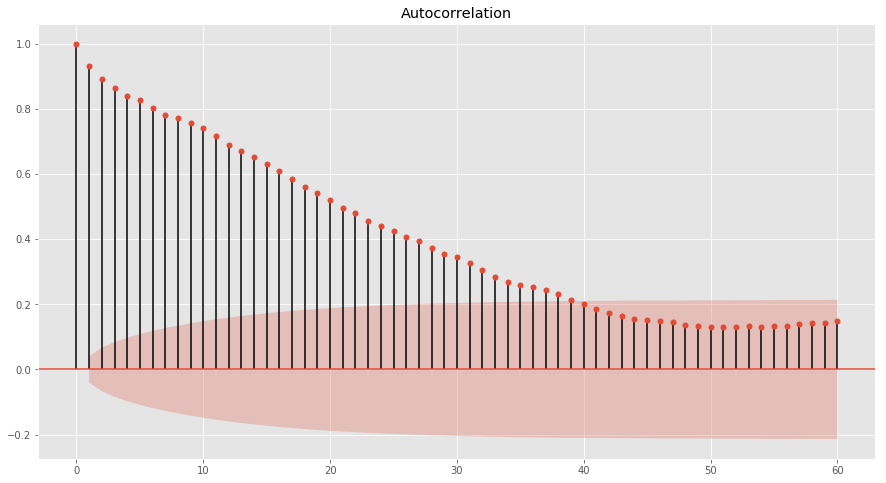

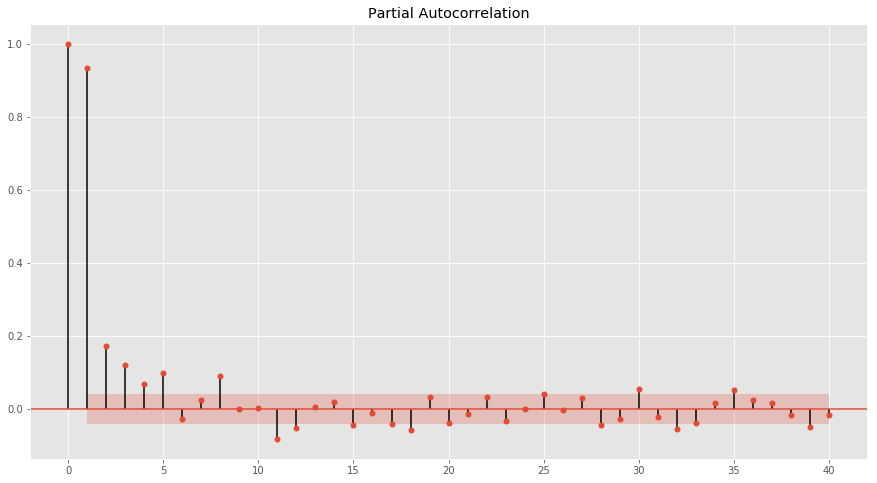

In [319]:
auto = acf(X)
print(auto)
y = plot_acf(X, lags=60)
plt.show()
y = plot_pacf(X, lags=40)
plt.show()

We will runa grid search to help us decide what p and q values to use in our model:

In [320]:
grid_result = run_grid_over_arma(X, p_lags=list(range(5)), q_lags=range(5))

['p(0)', 'n/a', '10572.12', ' 9608.72', ' 8927.59', ' 8681.60']
['p(1)', ' 7682.91', ' 7595.44', ' 7570.22', ' 7573.93', ' 7576.89']
['p(2)', ' 7619.48', ' 7564.96', ' 7572.30', ' 7580.01', 'n/a']
['p(3)', ' 7591.93', ' 7572.28', ' 7578.77', ' 7586.41', ' 7565.84']
['p(4)', ' 7588.03', ' 7579.89', ' 7587.41', 'n/a', 'n/a']
+------+----------+----------+----------+----------+----------+
| p\q  |  q (0)   |  q (1)   |  q (2)   |  q (3)   |  q (4)   |
+------+----------+----------+----------+----------+----------+
| p(0) |   n/a    | 10572.12 |  9608.72 |  8927.59 |  8681.60 |
| p(1) |  7682.91 |  7595.44 |  7570.22 |  7573.93 |  7576.89 |
| p(2) |  7619.48 |  7564.96 |  7572.30 |  7580.01 |   n/a    |
| p(3) |  7591.93 |  7572.28 |  7578.77 |  7586.41 |  7565.84 |
| p(4) |  7588.03 |  7579.89 |  7587.41 |   n/a    |   n/a    |
+------+----------+----------+----------+----------+----------+
bad values: [(0, 0), (2, 4), (4, 3), (4, 4)]
time required 9.743584871292114


In [321]:
b = sorted(list(grid_result.items()), key=lambda k: k[1])
print(b)

[((2, 1), 7564.957472965394), ((3, 4), 7565.8438456627155), ((1, 2), 7570.21967803622), ((3, 1), 7572.279762769047), ((2, 2), 7572.299550456719), ((1, 3), 7573.930732382952), ((1, 4), 7576.894075550767), ((3, 2), 7578.7665201778), ((4, 1), 7579.892549913009), ((2, 3), 7580.011855675479), ((3, 3), 7586.414384936876), ((4, 2), 7587.408023579574), ((4, 0), 7588.029367390866), ((3, 0), 7591.9328531265255), ((1, 1), 7595.437259910496), ((2, 0), 7619.4787994317485), ((1, 0), 7682.908739805367), ((0, 4), 8681.60204393116), ((0, 3), 8927.590315352254), ((0, 2), 9608.724979676586), ((0, 1), 10572.123910239005)]


We will try an ARMA(2,1) model and a ARMA (3,4) model:

First ARMA(2,1):

In [322]:
model = ARIMA(X, order=(2,0,1))
r = model.fit()
r.summary()
print('RMSE (in sample):',np.sqrt(np.mean(r.sigma2)))

RMSE (in sample): 1.1975193171875995


In [323]:
train1=train['VIXCM30_Premium'].dropna().tolist()
arima_model = ARIMA(train1, order=(2,0,1))
model_fit = arima_model.fit()

We can check to see if there is any information left in the residuals:

In [325]:
run_ljung_box(model_fit.resid,lags=40)

Ljung-Box Test
lag:   5 | p_value: 0.0245 | still has information
lag:   6 | p_value: 0.0342 | still has information
lag:   7 | p_value: 0.0024 | still has information
lag:   8 | p_value: 0.0006 | still has information
lag:   9 | p_value: 0.0005 | still has information
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0000 | still has information
lag:  12 | p_value: 0.0000 | still has information
lag:  13 | p_value: 0.0000 | still has information
lag:  14 | p_value: 0.0000 | still has information
lag:  15 | p_value: 0.0000 | still has information
lag:  16 | p_value: 0.0000 | still has information
lag:  17 | p_value: 0.0000 | still has information
lag:  18 | p_value: 0.0000 | still has information
lag:  19 | p_value: 0.0000 | still has information
lag:  20 | p_value: 0.0000 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0000 | still has information
lag:  23 | p_value: 0.0000 | still has information
lag:  24 | p_val

Unfortunately, there is still a lot of data left in the residuals.  We will check to see how this model performs out of sample regardless and then we will check to see if a model with a different order might capture more of this residual information.

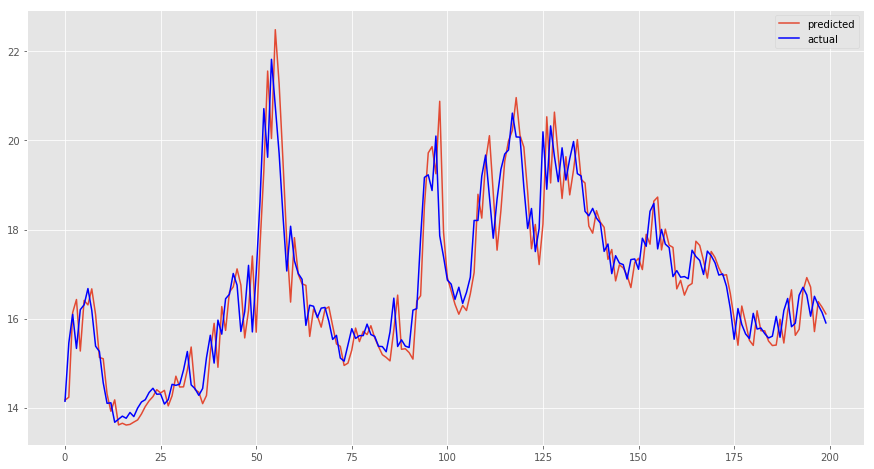

In [326]:
H = train['VIXCM30_Premium'].tolist()
ARIMA_ORDER = (2,0,1)
ARMA_prem4 = []
ARMA_PRED4=[]
VIX = []
ACTUAL_FUTURE4=[]
ACTUAL_prem4 = []
n = 0

for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]

for d,row in test.iterrows():
    arima_model = ARIMA(H, order=ARIMA_ORDER)
    arima_fit = arima_model.fit()
    y_hat = arima_fit.predict(start=len(H), end=len(H) + 5)[0]
    ARMA_prem4 += [y_hat]
    ARMA_PRED4+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM30_Premium']]
    ACTUAL_prem4 += [row['VIXCM30_Premium']]
    ACTUAL_FUTURE4+=[row['VIXCM30']]
    n += 1


# plotting the first 200 points
plt.plot(ARMA_PRED4[:200], label='predicted')
plt.plot(ACTUAL_FUTURE4[:200], color='b', label='actual')
plt.legend()

In [327]:
rolling_ar_errors = measure_error(ACTUAL_FUTURE4, ARMA_PRED4, label='Rolling ARIMA(%d,%d,%d)' % ARIMA_ORDER)

RMSE = 0.8369772457435734
RMSE_pcent = 0.047440847815554896
label = Rolling ARIMA(2,0,1)


Confusion Matrix
Raw
[[193 115]
 [181  99]]
Normalized
[[0.32823129 0.19557823]
 [0.30782313 0.16836735]]


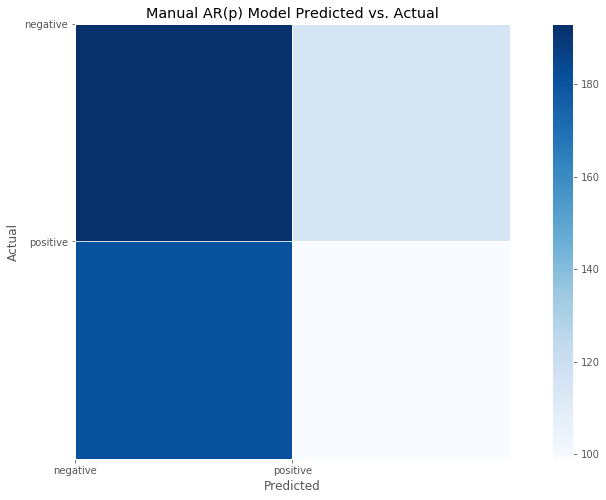

In [328]:
ar_cm = plot_confusion_matrix(ACTUAL_FUTURE4, ARMA_PRED4)

In [329]:
make_money(ACTUAL_FUTURE4, ARMA_PRED4)

Total profit or loss: 1.5630
Number of correct days: 294
total incorrect days: 294


Now let's try our ARMA (3,4) model to see if we can solve the issue of the information that is remaining in the residuals:

In [330]:
model2 = ARIMA(X, order=(3,0,4))
r2 = model2.fit()
r2.summary()
print('RMSE (in sample):',np.sqrt(np.mean(r2.sigma2)))

RMSE (in sample): 1.1897402525654754


In [331]:
arima_model = ARIMA(train1, order=(3,0,4))
model_fit2 = arima_model.fit()

In [332]:
run_ljung_box(r2.resid,lags=40)

Ljung-Box Test
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0001 | still has information
lag:  12 | p_value: 0.0001 | still has information
lag:  13 | p_value: 0.0001 | still has information
lag:  14 | p_value: 0.0001 | still has information
lag:  15 | p_value: 0.0000 | still has information
lag:  16 | p_value: 0.0001 | still has information
lag:  17 | p_value: 0.0001 | still has information
lag:  18 | p_value: 0.0001 | still has information
lag:  19 | p_value: 0.0002 | still has information
lag:  20 | p_value: 0.0003 | still has information
lag:  21 | p_value: 0.0002 | still has information
lag:  22 | p_value: 0.0003 | still has information
lag:  23 | p_value: 0.0005 | still has information
lag:  24 | p_value: 0.0004 | still has information
lag:  25 | p_value: 0.0005 | still has information
lag:  26 | p_value: 0.0008 | still has information
lag:  27 | p_value: 0.0005 | still has information
lag:  28 | p_value: 0.0007 | still has information
lag:  29 | p_val

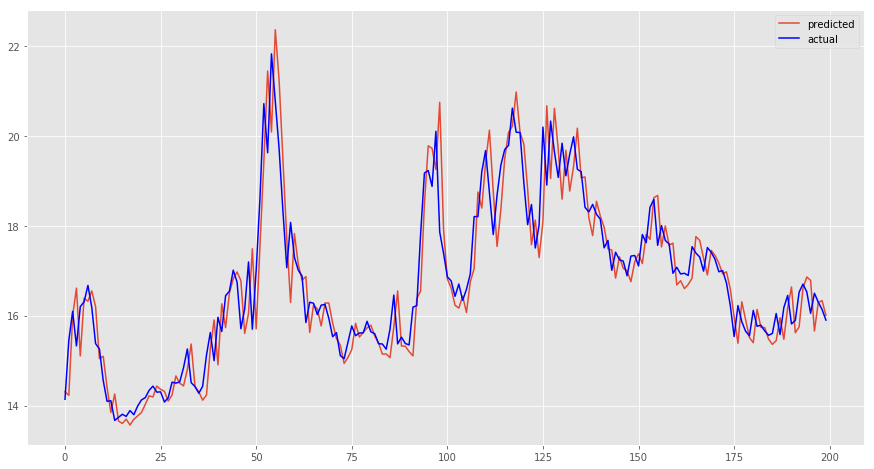

In [333]:
H = train['VIXCM30_Premium'].tolist()
ARIMA_ORDER = (3,0,4)
ARMA_prem = []
ARMA_PRED=[]
VIX = []
ACTUAL_FUTURE=[]
ACTUAL_prem = []
n = 0

for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]

for d,row in test.iterrows():
    arima_model = ARIMA(H, order=ARIMA_ORDER)
    arima_fit = arima_model.fit()
    y_hat = arima_fit.predict(start=len(H), end=len(H) + 5)[0]
    ARMA_prem += [y_hat]
    ARMA_PRED+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM30_Premium']]
    ACTUAL_prem += [row['VIXCM30_Premium']]
    ACTUAL_FUTURE+=[row['VIXCM30']]
    n += 1


# plotting the first 200 points
plt.plot(ARMA_PRED[:200], label='predicted')
plt.plot(ACTUAL_FUTURE[:200], color='b', label='actual')
plt.legend()

In [336]:
rolling_ar_errors2 = measure_error(ACTUAL_FUTURE, ARMA_PRED, label='Rolling ARIMA(%d,%d,%d)' % ARIMA_ORDER)

RMSE = 0.8361463719379066
RMSE_pcent = 0.04739375291785126
label = Rolling ARIMA(3,0,4)


Confusion Matrix
Raw
[[185 123]
 [165 115]]
Normalized
[[0.31462585 0.20918367]
 [0.28061224 0.19557823]]


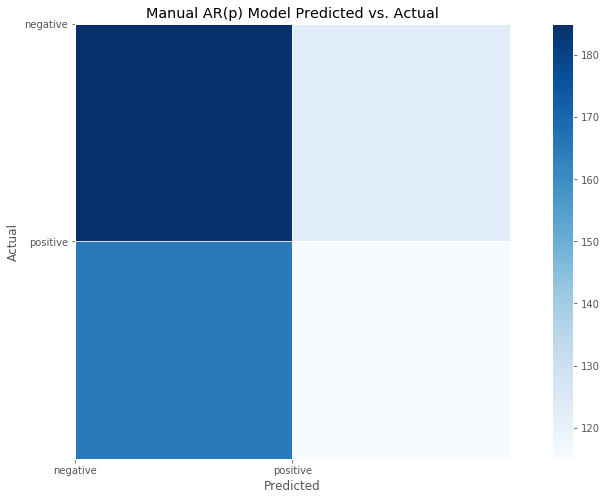

In [337]:
ar_cm2 = plot_confusion_matrix(ACTUAL_FUTURE, ARMA_PRED)

In [338]:
make_money(ACTUAL_FUTURE, ARMA_PRED)

Total profit or loss: 15.6848
Number of correct days: 302
total incorrect days: 286


data | model | First lag in Ljung Box| RMSE_Percent | PnL 
--|--|--|--|--
VIXCM30_Premium | ARMA(2,1) | 5| 0.04744 | +\$ 1.56300 
VIXCM30_Premium | ARMA(3,4) | 10| 0.04739| +\$ 15.6848 


We can see that this order model also has information left in the lagged residuals (but starting at 10 rather than 5) and it also performs slightly better than the ARMA(2,1) model.  This makes us a little cautious, but let's check if this problem persists in the ARMA models for the other Premium variables as well.  We will spot check with the VIXCM60 Premium.

#### ARMA Model for VIXCM60 Premium

First let's take a look at the PACF and ACF:

In [339]:
X2= train['VIXCM60_Premium']

[1.         0.95290316 0.92320006 0.90125888 0.88073219 0.86684725
 0.8488799  0.8317255  0.82183554 0.80894865 0.79688858 0.77657838
 0.75628295 0.74004291 0.72610523 0.70945886 0.69358428 0.67398217
 0.6540956  0.63959913 0.62170176 0.6032417  0.59016855 0.57442543
 0.56071146 0.54849787 0.53332192 0.52152519 0.50556092 0.48949031
 0.47956356 0.46535086 0.44882695 0.43283906 0.41861135 0.41088356
 0.40227172 0.39214396 0.38157287 0.36778869 0.35501799]


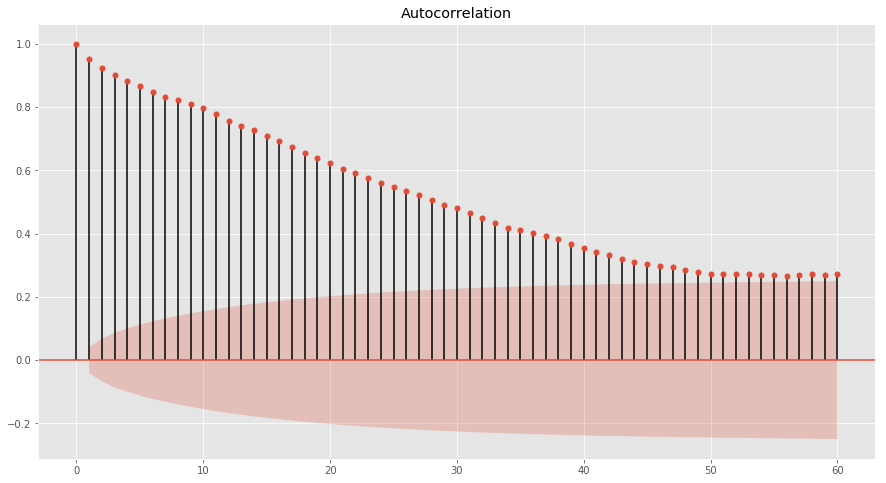

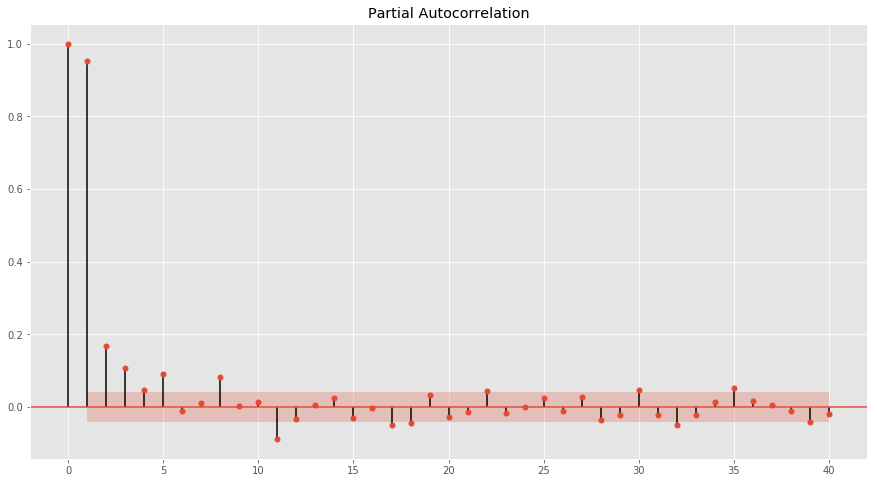

In [340]:
auto = acf(X2)
print(auto)
y = plot_acf(X2, lags=60)
plt.show()
y = plot_pacf(X2, lags=40)
plt.show()

We will run a grid search to help us decide what p and q values to use in our model:

In [341]:
grid_result = run_grid_over_arma(X2, p_lags=list(range(5)), q_lags=range(5))

['p(0)', 'n/a', '11908.22', '10764.37', ' 9956.62', ' 9580.24']
['p(1)', ' 8299.45', ' 8222.75', ' 8208.13', ' 8213.54', ' 8213.48']
['p(2)', ' 8240.40', ' 8202.76', ' 8210.53', ' 8218.27', ' 8219.33']
['p(3)', ' 8220.75', ' 8210.53', ' 8217.39', ' 8224.26', ' 8211.52']
['p(4)', ' 8223.52', ' 8218.26', ' 8223.89', 'n/a', 'n/a']
+------+----------+----------+----------+----------+----------+
| p\q  |  q (0)   |  q (1)   |  q (2)   |  q (3)   |  q (4)   |
+------+----------+----------+----------+----------+----------+
| p(0) |   n/a    | 11908.22 | 10764.37 |  9956.62 |  9580.24 |
| p(1) |  8299.45 |  8222.75 |  8208.13 |  8213.54 |  8213.48 |
| p(2) |  8240.40 |  8202.76 |  8210.53 |  8218.27 |  8219.33 |
| p(3) |  8220.75 |  8210.53 |  8217.39 |  8224.26 |  8211.52 |
| p(4) |  8223.52 |  8218.26 |  8223.89 |   n/a    |   n/a    |
+------+----------+----------+----------+----------+----------+
bad values: [(0, 0), (4, 3), (4, 4)]
time required 11.767310857772827


In [342]:
b = sorted(list(grid_result.items()), key=lambda k: k[1])
print(b)

[((2, 1), 8202.764414557952), ((1, 2), 8208.130009167802), ((2, 2), 8210.527132456586), ((3, 1), 8210.527162769662), ((3, 4), 8211.523492331788), ((1, 4), 8213.482916654084), ((1, 3), 8213.537119955572), ((3, 2), 8217.394445200434), ((4, 1), 8218.258294896628), ((2, 3), 8218.268074030846), ((2, 4), 8219.32718617729), ((3, 0), 8220.754381057428), ((1, 1), 8222.75177438938), ((4, 0), 8223.519608762306), ((4, 2), 8223.885593759196), ((3, 3), 8224.257522342912), ((2, 0), 8240.398729208286), ((1, 0), 8299.445989273678), ((0, 4), 9580.237456651997), ((0, 3), 9956.617795085402), ((0, 2), 10764.365937165772), ((0, 1), 11908.215104282828)]


Again we will try an ARMA(2,1) model:

In [343]:
model = ARIMA(X2, order=(2,0,1))
r = model.fit()
r.summary()
print('RMSE (in sample):',np.sqrt(np.mean(r.sigma2)))

RMSE (in sample): 1.3711005884788794


In [344]:
train2=train['VIXCM60_Premium'].dropna().tolist()
arima_model2 = ARIMA(train2, order=(2,0,1))
model_fit2 = arima_model2.fit()

We can check to see if there is any information left in the residuals:

In [345]:
run_ljung_box(model_fit2.resid,lags=40)

Ljung-Box Test
lag:   7 | p_value: 0.0113 | still has information
lag:   8 | p_value: 0.0072 | still has information
lag:   9 | p_value: 0.0108 | still has information
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0000 | still has information
lag:  12 | p_value: 0.0000 | still has information
lag:  13 | p_value: 0.0000 | still has information
lag:  14 | p_value: 0.0000 | still has information
lag:  15 | p_value: 0.0000 | still has information
lag:  16 | p_value: 0.0000 | still has information
lag:  17 | p_value: 0.0000 | still has information
lag:  18 | p_value: 0.0000 | still has information
lag:  19 | p_value: 0.0000 | still has information
lag:  20 | p_value: 0.0000 | still has information
lag:  21 | p_value: 0.0000 | still has information
lag:  22 | p_value: 0.0000 | still has information
lag:  23 | p_value: 0.0000 | still has information
lag:  24 | p_value: 0.0000 | still has information
lag:  25 | p_value: 0.0000 | still has information
lag:  26 | p_val

Unfortunately, there is still a lot of data left in the residuals.  But let's just check to see how the ARMA performs out of sample regardless.

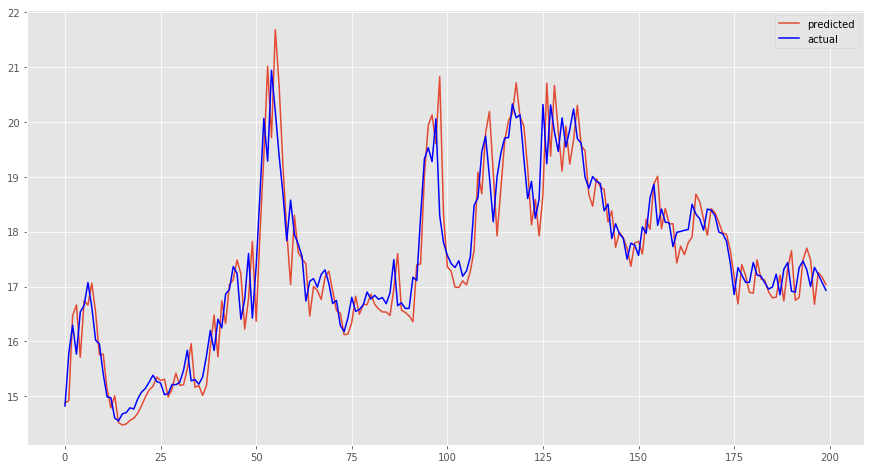

In [346]:
H = train['VIXCM60_Premium'].tolist()
ARIMA_ORDER = (2,0,1)
ARMA_prem2 = []
ARMA_PRED2=[]
VIX = []
ACTUAL_FUTURE2=[]
ACTUAL_prem2 = []
n = 0

for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]

for d,row in test.iterrows():
    arima_model = ARIMA(H, order=ARIMA_ORDER)
    arima_fit = arima_model.fit()
    y_hat = arima_fit.predict(start=len(H), end=len(H) + 5)[0]
    ARMA_prem2 += [y_hat]
    ARMA_PRED2+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM60_Premium']]
    ACTUAL_prem2 += [row['VIXCM60_Premium']]
    ACTUAL_FUTURE2+=[row['VIXCM60']]
    n += 1


# plotting the first 200 points
plt.plot(ARMA_PRED2[:200], label='predicted')
plt.plot(ACTUAL_FUTURE2[:200], color='b', label='actual')
plt.legend()

In [347]:
rolling_ar_errors = measure_error(ACTUAL_FUTURE2, ARMA_PRED2, label='Rolling ARIMA(%d,%d,%d)' % ARIMA_ORDER)

RMSE = 0.6519801144622868
RMSE_pcent = 0.03534142555932097
label = Rolling ARIMA(2,0,1)


Confusion Matrix
Raw
[[185 116]
 [184 103]]
Normalized
[[0.31462585 0.19727891]
 [0.31292517 0.17517007]]


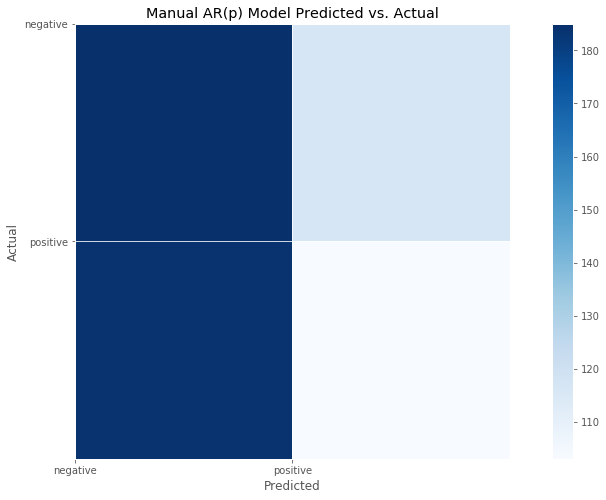

In [348]:
ar_cm = plot_confusion_matrix(ACTUAL_FUTURE2, ARMA_PRED2)

In [349]:
make_money(ACTUAL_FUTURE2, ARMA_PRED2)

Total profit or loss: -2.8920
Number of correct days: 288
total incorrect days: 300


Now let's try our ARMA (3,4) model to see if we can solve the issue of the information that is remaining in the residuals:

In [432]:
model2 = ARIMA(X, order=(3,0,4))
r2 = model2.fit()
r2.summary()
print('RMSE (in sample):',np.sqrt(np.mean(r2.sigma2)))

RMSE (in sample): 1.1897402525654754


In [433]:
arima_model = ARIMA(train1, order=(3,0,4))
model_fit2 = arima_model.fit()

In [434]:
run_ljung_box(r2.resid,lags=40)

Ljung-Box Test
lag:  10 | p_value: 0.0000 | still has information
lag:  11 | p_value: 0.0001 | still has information
lag:  12 | p_value: 0.0001 | still has information
lag:  13 | p_value: 0.0001 | still has information
lag:  14 | p_value: 0.0001 | still has information
lag:  15 | p_value: 0.0000 | still has information
lag:  16 | p_value: 0.0001 | still has information
lag:  17 | p_value: 0.0001 | still has information
lag:  18 | p_value: 0.0001 | still has information
lag:  19 | p_value: 0.0002 | still has information
lag:  20 | p_value: 0.0003 | still has information
lag:  21 | p_value: 0.0002 | still has information
lag:  22 | p_value: 0.0003 | still has information
lag:  23 | p_value: 0.0005 | still has information
lag:  24 | p_value: 0.0004 | still has information
lag:  25 | p_value: 0.0005 | still has information
lag:  26 | p_value: 0.0008 | still has information
lag:  27 | p_value: 0.0005 | still has information
lag:  28 | p_value: 0.0007 | still has information
lag:  29 | p_val

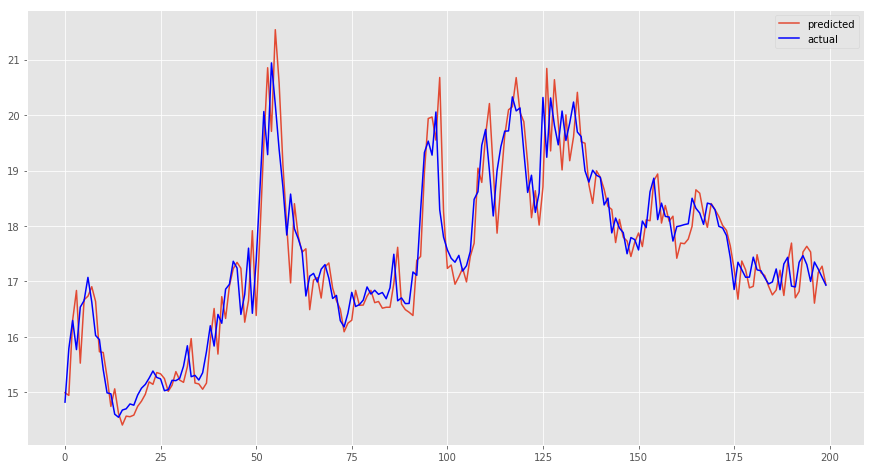

In [436]:
H = train['VIXCM60_Premium'].tolist()
ARIMA_ORDER = (3,0,4)
ARMA_prem = []
ARMA_PRED=[]
VIX = []
ACTUAL_FUTURE=[]
ACTUAL_prem = []
n = 0

for d,row in train.tail(1).iterrows():
    VIX +=[row['VIX']]

for d,row in test.iterrows():
    arima_model = ARIMA(H, order=ARIMA_ORDER)
    arima_fit = arima_model.fit()
    y_hat = arima_fit.predict(start=len(H), end=len(H) + 5)[0]
    ARMA_prem += [y_hat]
    ARMA_PRED+=[y_hat+VIX[-1]]
    VIX+=[row['VIX']]
    
    H += [row['VIXCM60_Premium']]
    ACTUAL_prem += [row['VIXCM60_Premium']]
    ACTUAL_FUTURE+=[row['VIXCM60']]
    n += 1


# plotting the first 200 points
plt.plot(ARMA_PRED[:200], label='predicted')
plt.plot(ACTUAL_FUTURE[:200], color='b', label='actual')
plt.legend()

In [437]:
rolling_ar_errors2 = measure_error(ACTUAL_FUTURE, ARMA_PRED, label='Rolling ARIMA(%d,%d,%d)' % ARIMA_ORDER)

RMSE = 0.6562020202035773
RMSE_pcent = 0.03557027942183079
label = Rolling ARIMA(3,0,4)


Confusion Matrix
Raw
[[190 111]
 [184 103]]
Normalized
[[0.32312925 0.18877551]
 [0.31292517 0.17517007]]


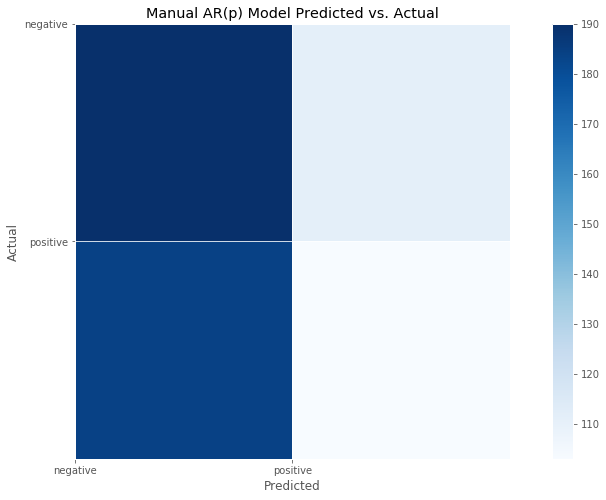

In [438]:
ar_cm2 = plot_confusion_matrix(ACTUAL_FUTURE, ARMA_PRED)

In [439]:
make_money(ACTUAL_FUTURE, ARMA_PRED)

Total profit or loss: -6.8196
Number of correct days: 293
total incorrect days: 295


data | model | First lag in Ljung Box| RMSE_Percent | PnL 
--|--|--|--|--
VIXCM60_Premium | ARMA(2,1) | 7| 0.03534 | -\$ 2.8920
VIXCM60_Premium | ARMA(3,4) | 10| 0.03557| -\$ 6.8196 


Again we see that when using the ARMA model, we find there is still information left in the residuals.  This makes us concerned that our ARMA models are not properly capturing all of the information available, but we feel a bit more confident that our AR models can.  Because of this, and the fact that our AR models look to be making us more money, we will choose to use the AR models to develop our strategy, rather than continue running more ARMA models (which is great since we prefer simpler models and ARMA models take much longer to run).


## <font color='#114B5F'><p style="text-align: center;"><a id='new_strategy-anchor'></a>Revised Strategy</p></font>

### Revising Our Buy/Sell Strategy

We decided to check how our PnL might change if we allow the sale or purchase of any given future to take over the 5 next days, rather than requiring this action to happen the very next day.  To do this, we created a new function, shown below, where the reccommendation (buy +1 or sell -1) follows the same strategy as before, buy if VIXCM30 is predicted to be higher tomorrow, sell if it is predicted to be lower. Then we will multiply the direction by $Future Price_{t*}$ - $Future Price_{t}$.  Where $t*$ is the optimal day (max or min) over the next 5 trading days.

For example, if the VIXCM30 was 20 today and the predicted VIXCM30 over the next 5 days were 21,22,24,19,20 respectively, our strategy would tells us to buy (+1) since 20<21 and then we would sell in 3 days because this is the date with the predicted highest VIXCM30 price (24).  Then let's day the real price on that 3rd say ends up being 23.  Our PnL would be (+1)*(23-20) = +3.

In [443]:
def make_money_week(actual,predicted):
    d = {'Predicted': predicted,
     'Actual': actual}
    PnL_df = pd.DataFrame(d)
    
    Total_PnL =0
    direction=0
    correct=0
    incorrect=0
    
    for i in range(0, (len(PnL_df)-1)):
        if PnL_df['Predicted'][i+1][0]>PnL_df['Actual'][i][0]:
            direction=1
            best_day=max(PnL_df['Predicted'][i+1])
            pos=np.unravel_index(np.argmax((PnL_df['Predicted'][i+1]), axis=None), (PnL_df['Predicted'][i+1]).shape)
            actual_sell=PnL_df['Actual'][i][pos]
        else:
            direction=-1
            best_day=min(PnL_df['Predicted'][i+1])
            pos=np.unravel_index(np.argmin((PnL_df['Predicted'][i+1]), axis=None), (PnL_df['Predicted'][i+1]).shape)
            actual_sell=PnL_df['Actual'][i][pos]
        daily_PnL= direction*(actual_sell-PnL_df['Actual'][i][0])
        Total_PnL+=daily_PnL
        if daily_PnL>=0:
            correct+=1
        else:
            incorrect+=1
            
    print('Total profit or loss: %.4f' % (Total_PnL))
    print('Number of correct days: %d' % (correct))
    print('total incorrect days: %d' % (incorrect))

In [426]:
ACTUAL_LIST_week=[]
for i in range(0,(len(test)-4)):
    new=[test.VIXCM30.iloc[i],test.VIXCM30.iloc[i+1],
         test.VIXCM30.iloc[i+2],test.VIXCM30.iloc[i+3],test.VIXCM30.iloc[i+4]]
    new=np.asarray(new)
    ACTUAL_LIST_week+=[new]

In [423]:
H = train['VIXCM30_Premium'].tolist()
AR_ORDER = 49
AR_PRED_week_lists=[]
VIX=[]
for d,row in train.tail(1).iterrows():
    VIX+=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 4)
    pred_list=[]
    pred=y_hat+VIX[-1]
    pred_list.append(pred)
    AR_PRED_week_lists+=pred_list
    VIX+=[row['VIX']] 
    H += [row['VIXCM30_Premium']]
    

In [427]:
make_money_week(ACTUAL_LIST_week,AR_PRED_week_lists[:-4])

Total profit or loss: 20.5517
Number of correct days: 336
total incorrect days: 248


In [440]:
ACTUAL_LIST_week60=[]
for i in range(0,(len(test)-4)):
    new=[test.VIXCM60.iloc[i],test.VIXCM60.iloc[i+1],
         test.VIXCM60.iloc[i+2],test.VIXCM60.iloc[i+3],test.VIXCM60.iloc[i+4]]
    new=np.asarray(new)
    ACTUAL_LIST_week60+=[new]

In [455]:
H = train['VIXCM60_Premium'].tolist()
AR_ORDER = 35
AR_PRED_week_lists60=[]
VIX=[]
for d,row in train.tail(1).iterrows():
    VIX+=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 4)
    pred_list=[]
    pred=y_hat+VIX[-1]
    pred_list.append(pred)
    AR_PRED_week_lists60+=pred_list
    VIX+=[row['VIX']] 
    H += [row['VIXCM60_Premium']]
    

In [456]:
make_money_week(ACTUAL_LIST_week60,AR_PRED_week_lists60[:-4])

Total profit or loss: 8.9814
Number of correct days: 349
total incorrect days: 235


In [445]:
ACTUAL_LIST_week90=[]
for i in range(0,(len(test)-4)):
    new=[test.VIXCM90.iloc[i],test.VIXCM90.iloc[i+1],
         test.VIXCM90.iloc[i+2],test.VIXCM90.iloc[i+3],test.VIXCM90.iloc[i+4]]
    new=np.asarray(new)
    ACTUAL_LIST_week90+=[new]

In [458]:
H = train['VIXCM90_Premium'].tolist()
AR_ORDER = 35
AR_PRED_week_lists90=[]
VIX=[]
for d,row in train.tail(1).iterrows():
    VIX+=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 4)
    pred_list=[]
    pred=y_hat+VIX[-1]
    pred_list.append(pred)
    AR_PRED_week_lists90+=pred_list
    VIX+=[row['VIX']] 
    H += [row['VIXCM90_Premium']]
    

In [459]:
make_money_week(ACTUAL_LIST_week90,AR_PRED_week_lists90[:-4])

Total profit or loss: 12.4234
Number of correct days: 348
total incorrect days: 236


In [448]:
ACTUAL_LIST_week120=[]
for i in range(0,(len(test)-4)):
    new=[test.VIXCM120.iloc[i],test.VIXCM120.iloc[i+1],
         test.VIXCM120.iloc[i+2],test.VIXCM120.iloc[i+3],test.VIXCM120.iloc[i+4]]
    new=np.asarray(new)
    ACTUAL_LIST_week120+=[new]

In [460]:
H = train['VIXCM120_Premium'].tolist()
AR_ORDER = 35
AR_PRED_week_lists120=[]
VIX=[]
for d,row in train.tail(1).iterrows():
    VIX+=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 4)
    pred_list=[]
    pred=y_hat+VIX[-1]
    pred_list.append(pred)
    AR_PRED_week_lists120+=pred_list
    VIX+=[row['VIX']] 
    H += [row['VIXCM120_Premium']]
    

In [461]:
make_money_week(ACTUAL_LIST_week120,AR_PRED_week_lists120[:-4])

Total profit or loss: 4.5694
Number of correct days: 351
total incorrect days: 233


In [451]:
ACTUAL_LIST_week150=[]
for i in range(0,(len(test)-4)):
    new=[test.VIXCM150.iloc[i],test.VIXCM150.iloc[i+1],
         test.VIXCM150.iloc[i+2],test.VIXCM150.iloc[i+3],test.VIXCM150.iloc[i+4]]
    new=np.asarray(new)
    ACTUAL_LIST_week150+=[new]

In [452]:
H = train['VIXCM150_Premium'].tolist()
AR_ORDER = 49
AR_PRED_week_lists150=[]
VIX=[]
for d,row in train.tail(1).iterrows():
    VIX+=[row['VIX']]
for d,row in test.iterrows():
    ar_model = AR(H)
    ar_fit = ar_model.fit(maxlag=AR_ORDER)
    y_hat = ar_fit.predict(start=len(H), end=len(H) + 4)
    pred_list=[]
    pred=y_hat+VIX[-1]
    pred_list.append(pred)
    AR_PRED_week_lists150+=pred_list
    VIX+=[row['VIX']] 
    H += [row['VIXCM150_Premium']]
    

In [454]:
make_money_week(ACTUAL_LIST_week150,AR_PRED_week_lists150[:-4])

Total profit or loss: 10.3753
Number of correct days: 363
total incorrect days: 221


data | model | PnL (over a week)
--|--|--
VIXCM30_Premium | AR(49) | +\$ 20.5517 
VIXCM60_Premium | AR(35) | +\$ 8.9814 
VIXCM90_Premium | AR(35) | +\$ 12.4234 
VIXCM120_Premium | AR(35) | +\$ 4.5694 
VIXCM150_Premium | AR(49) | +\$ 10.3753

Using this new strategy, we end up with higher profits for each model!

## <font color='#114B5F'><p style="text-align: center;"><a id='conclusion-anchor'></a>Conclusion</p></font>

After trying ARCH, GARCH, VECM, AR, and ARMA models we came to find that our AR models resulted in the most profitable strategy.  It is worth noting that the RSMEs for ARCH and GARCH models were the lowest, so they were the best fit, but these models were predicting the market volitality rather than the price of the futures.  In regards to predicting the VIX futures' prices, AR models did the best, but they still didn't result in a strong edge.  When revising our strategy to allow the sale or purchase of a future over the 5 next days, rather than requiring this action to happen the very next day, we improved our profits.